# Suitability Analysis: Best ZCTA Within the Boston Region to Live Without a Car 
UEP-239 Final Project\
By: Justina Cheng

The purpose of this suitability analysis is to find the best Zip Code Tabulation Area (ZCTA) within the Boston region to live without a car. The original self-serving conception was to find the best ZCTA for a Tufts University student and a Boston University (BU) student to live together without a car (i.e. somewhere equally convenient for both), but the scope was changed for a more general analysis. The locations of Tufts and BU were  still used as a guide and as landmarks for the analysis.

---

## Import Dependencies

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
from scipy import stats

import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

import osmnx as ox
import networkx as nx
from geopy.geocoders import Nominatim
from pyproj import CRS
from shapely.geometry import LineString, Point, Polygon, box

import rasterio
from rasterio.plot import show
from rasterio import features

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats

---

## Create and View Base Map of Boston Region Zip Code Tabulation Areas (ZCTAs)
To create a GeoDataFrame of the Boston Region ZCTAs, the following steps were used:
1. Massachusetts outline with detailed coastline was imported from MassGIS as a GeoDataFrame.
1. Massachusetts ZCTAs were imported from the Census Bureau as a GeoDataFrame.
1. The outline and ZCTAs GeoDataFrames were converted to the coordinate reference system (CRS) for the Massachusetts Mainland EPSG 6491.
1. Boundaries for the Boston Region Metropolitan Planning Organization (MPO) were imported from MassDOT as a GeoDataFrame, and the CRS was converted to EPSG 6491.
1. The Boston Region was extracted from the MPO.
1. Massachusetts ZCTAs within the Boston Region were extracted using the centroid of the ZCTAs.
1. Function `convert_n_clip` was created to convert a GDF to the CRS of another GDF and clip to the other's extent.
1. Function `read_n_clip` was created to read in a shapefile and use `convert_n_clip` to convert it to the CRS of another GDF and clip to the other's extent.
1. Massachusetts Surface Water data from MassGIS was processed with `read_n_clip` with the extent of Boston ZCTAs. 

### Massachusetts Coastline

In [2]:
# Import outline of detailed Massachusetts coastline.
outline_25k = gpd.read_file("./data/outline25k/OUTLINE25K_POLY.shp")
outline_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   AREA_ACRES  918 non-null    float64 
 1   OBJECTID    918 non-null    int64   
 2   SHAPE_AREA  918 non-null    float64 
 3   SHAPE_LEN   918 non-null    float64 
 4   geometry    918 non-null    geometry
dtypes: float64(3), geometry(1), int64(1)
memory usage: 36.0 KB


In [ ]:
# View first five rows.
outline_25k.head()

epsg:26986


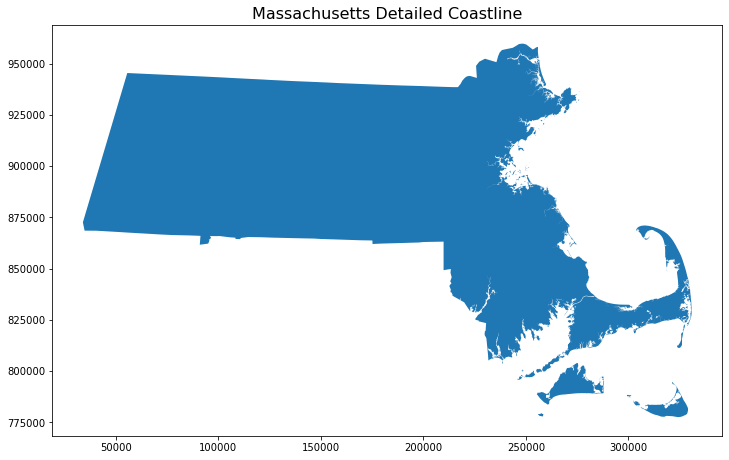

In [3]:
# View CRS and plot.
print(outline_25k.crs)
outline_25k.plot(figsize=(12,12))
plt.title('Massachusetts Detailed Coastline', fontsize=16)
plt.show()

### Massachusetts ZCTAs

In [4]:
# Import Zip Code Tabulation Areas within Massachusetts.
ma_zcta = gpd.read_file("./data/tl_2010_25_zcta500/tl_2010_25_zcta500.shp")
ma_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 47.1+ KB


In [ ]:
# View first five rows.
ma_zcta.head()

epsg:4269


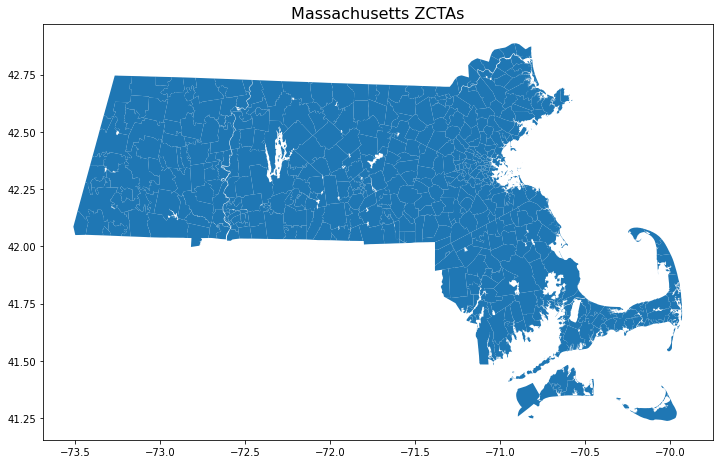

In [5]:
# View CRS and plot.
print(ma_zcta.crs)
ma_zcta.plot(figsize=(12,12))
plt.title('Massachusetts ZCTAs', fontsize=16)
plt.show()

In [6]:
# Convert CRSs to Massachusetts Mainland EPSG 6491.
outline_25k = outline_25k.to_crs('epsg:6491')
ma_zcta = ma_zcta.to_crs('epsg:6491')
# Confirm CRSs match.
outline_25k.crs == ma_zcta.crs

True

In [7]:
# Clip ZCTA GDF to 25k MA outline.
ma_zcta_25k = gpd.clip(ma_zcta, outline_25k)
ma_zcta_25k.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 501 entries, 0 to 500
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP00   501 non-null    object  
 1   ZCTA5CE00   501 non-null    object  
 2   GEOID00     501 non-null    object  
 3   CLASSFP00   501 non-null    object  
 4   MTFCC00     501 non-null    object  
 5   FUNCSTAT00  501 non-null    object  
 6   ALAND00     501 non-null    int64   
 7   AWATER00    501 non-null    int64   
 8   INTPTLAT00  501 non-null    object  
 9   INTPTLON00  501 non-null    object  
 10  PARTFLG00   501 non-null    object  
 11  geometry    501 non-null    geometry
dtypes: geometry(1), int64(2), object(9)
memory usage: 50.9+ KB


### Boston Region Metropolitan Planning Organization (MPO)

In [8]:
# Import boundaries from Boston Region Metropolitan Planning Organization.
mpo = gpd.read_file("./data/MPO_Boundaries/MPO_Boundaries.shp")
mpo.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    13 non-null     int64   
 1   MPO         13 non-null     object  
 2   created_us  0 non-null      object  
 3   created_da  13 non-null     object  
 4   last_edite  2 non-null      object  
 5   last_edi_1  13 non-null     object  
 6   GlobalID    13 non-null     object  
 7   ShapeSTAre  13 non-null     float64 
 8   ShapeSTLen  13 non-null     float64 
 9   geometry    13 non-null     geometry
dtypes: float64(2), geometry(1), int64(1), object(6)
memory usage: 1.1+ KB


In [9]:
# View MPO dataset.
mpo

OBJECTID                         MPO created_us  created_da last_edite  \
0          2                   Berkshire       None  1970-01-01       None   
1          3                    Cape Cod       None  1970-01-01       None   
2          4       Central Massachusetts       None  1970-01-01       None   
3          5                    Franklin       None  1970-01-01       None   
4          6                Montachusett       None  1970-01-01       None   
5          7           Martha's Vineyard       None  1970-01-01       None   
6          8            Merrimack Valley       None  1970-01-01       None   
7          9          Northern Middlesex       None  1970-01-01       None   
8         10                   Nantucket       None  1970-01-01       None   
9         11              Pioneer Valley       None  1970-01-01       None   
10        12               Boston Region       None  1970-01-01   DINOCCOD   
11        13                  Old Colony       None  1970-01-01   DINOCCOD   
12        14  Southeastern Massachusetts       None  1970-01-01       None   

    last_edi_1                                GlobalID    ShapeSTAre  \
0   1970-01-01  {08FDA544-18B0-412A-B442-287E53E987F7}  2.451015e+09   
1   1970-01-01  {B6CD90CF-2F7D-43F2-B251-FA7F8E00EF01}  1.067067e+09   
2   1970-01-01  {CC777E14-53C8-42AD-B421-71444DA0BB60}  2.487546e+09   
3   1970-01-01  {4804E708-6B89-4A85-9383-BD91F7589981}  1.876456e+09   
4   1970-01-01  {F315DA63-C9CF-40EE-8AA7-5ABA2E1FD528}  1.772355e+09   
5   1970-01-01  {84077DC9-D5D1-471D-9A64-1E5748F80B92}  2.757449e+08   
6   1970-01-01  {C09CD5BA-4FE1-45DD-838E-19F2ECF618DB}  7.188680e+08   
7   1970-01-01  {5B2D231C-F8EB-4768-AB7F-F9D02B3EDBBD}  5.073539e+08   
8   1970-01-01  {633A0B7F-266B-4F07-AA30-EC320231ADAA}  1.266795e+08   
9   1970-01-01  {B01F3417-DC74-4561-AE49-935ACC6EF1FF}  3.054352e+09   
10  2018-04-18  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09   
11  2018-04-18  {BEE05B06-8BC7-463C-9C7D-1353E32150C9}  9.938172e+08   
12  1970-01-01  {AEEBDC7F-368A-402A-8D40-EC12E6040D90}  2.087314e+09   

      ShapeSTLen                                           geometry  
0   2.471530e+05  POLYGON ((-8128884.676 5272654.345, -8128962.2...  
1   1.288227e+06  MULTIPOLYGON (((-7813968.781 5173329.197, -781...  
2   2.683265e+05  POLYGON ((-7977225.352 5223837.273, -7973861.8...  
3   2.527017e+05  POLYGON ((-8046511.241 5269691.856, -8045276.8...  
4   2.748684e+05  POLYGON ((-7976246.504 5267152.001, -7976121.9...  
5   3.701721e+05  MULTIPOLYGON (((-7859473.886 5083806.270, -785...  
6   3.847121e+05  MULTIPOLYGON (((-7890949.271 5294156.354, -788...  
7   1.410283e+05  POLYGON ((-7922038.111 5250986.670, -7923186.5...  
8   1.680333e+05  MULTIPOLYGON (((-7797087.819 5069759.518, -779...  
9   3.206858e+05  POLYGON ((-8049986.018 5212603.033, -8049953.4...  
10  1.665026e+06  MULTIPOLYGON (((-7875339.226 5247387.185, -787...  
11  3.368737e+05  MULTIPOLYGON (((-7909974.763 5184049.466, -790...  
12  9.014607e+05  MULTIPOLYGON (((-7922461.407 5170146.823, -792...

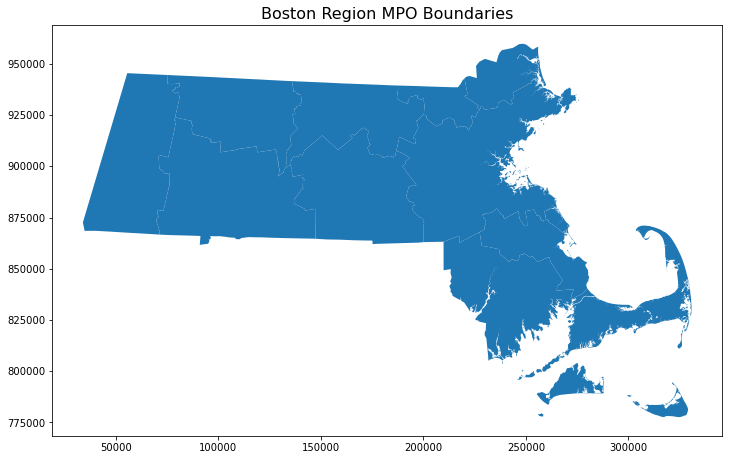

In [10]:
# Convert MPO CRS to EPSG 6491 and plot.
mpo = mpo.to_crs('epsg:6491')
mpo.plot(figsize=(12,12))
plt.title('Boston Region MPO Boundaries', fontsize=16)
plt.show()

In [11]:
# Extract only Boston Region from MPO.
boston_region = mpo.loc[mpo.MPO == 'Boston Region'].reset_index()
boston_region

index  OBJECTID            MPO created_us  created_da last_edite  \
0     10        12  Boston Region       None  1970-01-01   DINOCCOD   

   last_edi_1                                GlobalID    ShapeSTAre  \
0  2018-04-18  {3801574E-3CF1-4344-BE7C-8B2FBA431DD8}  3.524379e+09   

     ShapeSTLen                                           geometry  
0  1.665026e+06  MULTIPOLYGON (((261954.246 925125.468, 261961....

In [12]:
# Extract ZCTAs within the Boston Region using the centroid of the ZCTAs.
boston_zcta = ma_zcta_25k[ma_zcta_25k.centroid.within(boston_region.geometry[0])].reset_index()
boston_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       159 non-null    int64   
 1   STATEFP00   159 non-null    object  
 2   ZCTA5CE00   159 non-null    object  
 3   GEOID00     159 non-null    object  
 4   CLASSFP00   159 non-null    object  
 5   MTFCC00     159 non-null    object  
 6   FUNCSTAT00  159 non-null    object  
 7   ALAND00     159 non-null    int64   
 8   AWATER00    159 non-null    int64   
 9   INTPTLAT00  159 non-null    object  
 10  INTPTLON00  159 non-null    object  
 11  PARTFLG00   159 non-null    object  
 12  geometry    159 non-null    geometry
dtypes: geometry(1), int64(3), object(9)
memory usage: 16.3+ KB


In [13]:
# View the Boston Region ZCTAs.
boston_zcta

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00  \
0       31        25     02458  2502458        B5   G6350          S   
1       32        25     01867  2501867        B5   G6350          S   
2       33        25     01880  2501880        B5   G6350          S   
3       34        25     01730  2501730        B5   G6350          S   
4       35        25     02141  2502141        B5   G6350          S   
..     ...       ...       ...      ...       ...     ...        ...   
154    489        25     02030  2502030        B5   G6350          S   
155    490        25     02052  2502052        B5   G6350          S   
156    493        25     02111  2502111        B5   G6350          S   
157    494        25     02130  2502130        B5   G6350          S   
158    495        25     02222  2502222        B5   G6350          S   

      ALAND00  AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
0     4709183     57045  +42.3541154  -071.1891300         N   
1    25857991     46300  +42.5351829  -071.1054234         N   
2    18969895   1554312  +42.5043600  -071.0640609         N   
3    34703585    424511  +42.4993313  -071.2819054         N   
4     1572423     44304  +42.3702998  -071.0825603         N   
..        ...       ...          ...           ...       ...   
154  39440450    832120  +42.2341291  -071.2834628         N   
155  37335006    608718  +42.1845991  -071.3053065         N   
156    754214     79209  +42.3487843  -071.0589880         N   
157  11393804    369565  +42.3072770  -071.1140555         N   
158     77896         0  +42.3664695  -071.0624939         N   

                                              geometry  
0    MULTIPOLYGON (((227500.026 901300.219, 227482....  
1    POLYGON ((234193.323 919471.462, 234167.381 91...  
2    POLYGON ((233593.527 918646.107, 233786.679 91...  
3    POLYGON ((215991.167 913794.709, 215916.137 91...  
4    POLYGON ((234064.636 902597.603, 234080.228 90...  
..                                                 ...  
154  POLYGON ((215268.989 884982.344, 215020.550 88...  
155  POLYGON ((214616.455 880362.751, 214622.559 88...  
156  POLYGON ((236144.915 900687.565, 236153.840 90...  
157  POLYGON ((231406.529 893484.217, 231413.864 89...  
158  POLYGON ((235839.790 902134.685, 235852.488 90...  

[159 rows x 13 columns]

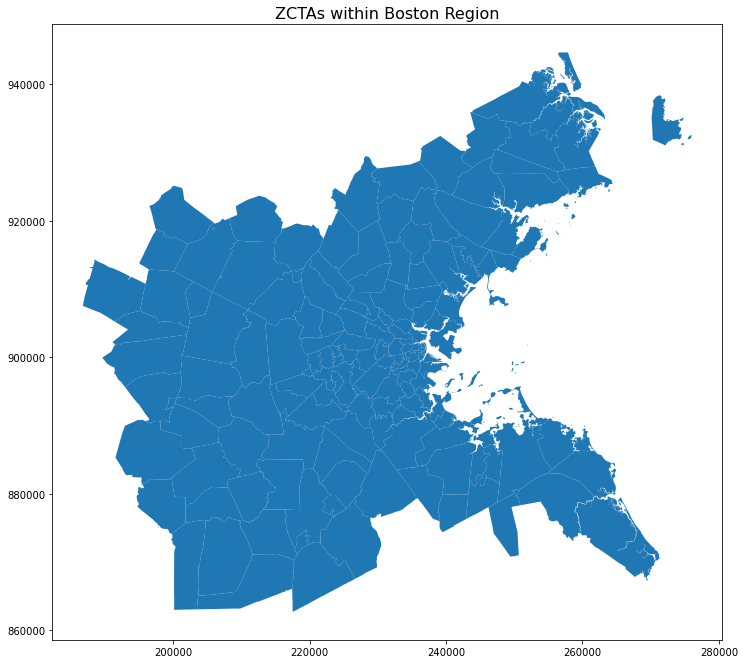

In [14]:
# Plot the Boston Region ZCTAs.
boston_zcta.plot(figsize=(12,12))
plt.title('ZCTAs within Boston Region', fontsize=16)
plt.show()

### Define Functions `convert_n_clip` and `read_n_clip`
These two functions will be used to read in, convert the CRS, and clip the extent of GDFs throughout the analysis.

`convert_n_clip` takes two GeoDataFrames (GDF): one to process (gdf) and one whose extent will be used to clip. The function converts the coordinate reference system (CRS) of the original GDF and clips it to the extent of the extent GDF.

In [15]:
def convert_n_clip(orig_gdf, extent_gdf):
    """
    Takes two GeoDataFrames (GDF): one to process (orig_gdf) and one whose extent will be used to clip (extent_gdf).
    Converts the coordinate reference system (CRS) of the orig_gdf to the CRS of extent_gdf.
    Clips to the extent of orig_gdf to the extent of extent_gdf.
    Returns clipped GDF.
    Requires GeoPandas to run.
    
    Inputs:
    orig_gdf = GDF to process
    extent_gdf = GDF whose extent to use
    
    Example:
    ma_schools = convert_n_clip(usa_schools, ma_boundary)
    """
    orig_gdf = orig_gdf.to_crs(extent_gdf.crs)
    clipped_gdf = gpd.clip(orig_gdf, extent_gdf)
    return clipped_gdf   

`read_n_clip` takes a filepath for a shapefile and a GDF whose extent will be used to clip the shapefile. The function reads in the shapefile and uses `convert_n_clip` to convert the coordinate reference system (CRS) of the original GDF and clip it to the extent of the extent GDF.

In [16]:
def read_n_clip(filepath, extent_gdf):
    """
    Takes a filepath for a shapefile and a GeoDataFrame (GDF).
    Reads in the file.
    Uses convert_n_clip function to convert to the coordinate reference system (CRS)
    of the GDF and clip to the extent of the GDF. 
    Returns clipped GDF.
    Requires GeoPandas to run.
    
    Inputs:
    filepath = relative filepath for shapefile to read
    extent_gdf = GDF whose extent to use
    
    Example:
    ma_water = read_n_clip('./data/usa/water.shp', ma_boundary)
    """
    shapefile = gpd.read_file(filepath)
    clipped_shapefile = convert_n_clip(shapefile, extent_gdf)
    return clipped_shapefile

### Boston Region Surface Water
Though not used for the analysis, surface water in the Boston region is a helpful landmark and reference point for orienting one to the map or for figuring out why some data may appear strange (e.g. why there are no rental points in an area).

Surface water in this analysis is added to some maps for reference, where appropriate.

In [17]:
# read_n_clip Boston surface water.
boston_water = read_n_clip('./data/hydro25k/HYDRO25K_POLY.shp', boston_zcta)
print(boston_water.crs)
boston_water.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 12720 entries, 7279 to 71450
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MINOR_TOT   12720 non-null  object  
 1   POLY_CODE   12720 non-null  int64   
 2   PWSID       87 non-null     object  
 3   PALIS_ID    12720 non-null  int64   
 4   SOURCE      12720 non-null  object  
 5   MINOR_NUM   12720 non-null  float64 
 6   RESOLUTION  12720 non-null  object  
 7   NAME        785 non-null    object  
 8   JOIN_ID     12720 non-null  int64   
 9   COASTAL     12720 non-null  int64   
 10  SHAPE_AREA  12720 non-null  float64 
 11  SHAPE_LEN   12720 non-null  float64 
 12  geometry    12720 non-null  geometry
dtypes: float64(3), geometry(1), int64(4), object(5)
memory usage: 1.4+ MB


In [ ]:
# View first five rows.
boston_water.head()

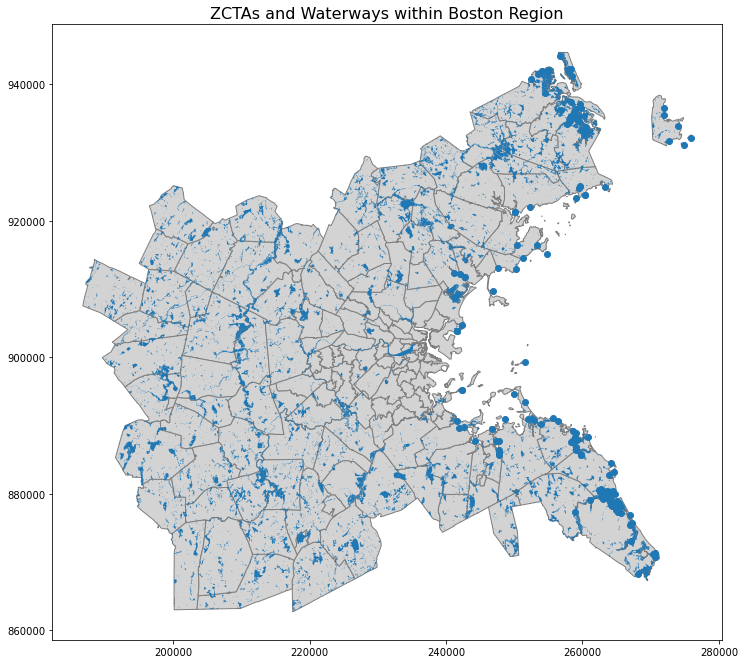

In [18]:
# Plot the Boston Region ZCTAs with surface water.
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax)
plt.title('ZCTAs and Waterways within Boston Region', fontsize=16)
plt.show()

---

## Find Tufts University and Boston University Locations
To find the locations of Tufts University and Boston University (BU), the Massachusetts Colleges and Universities shapefile was processed with `read_n_clip` to read the shapefile and clip it to the extent of `boston_zcta`. Tufts and BU were then extracted into a GeoDataGrame.

Similar to surface water, the locations of Tufts and BU are not explicitely used for analysis. They are instead added to most maps as landmarks and reference points.

In [19]:
# read_n_clip Boston MPO colleges.
colleges = read_n_clip('./data/colleges/COLLEGES_PT.shp', boston_zcta)
print(colleges.crs)
colleges.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 135 entries, 21 to 244
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   COLLEGE     135 non-null    object  
 1   CAMPUS      52 non-null     object  
 2   ADDRESS     135 non-null    object  
 3   CITY        135 non-null    object  
 4   ZIPCODE     135 non-null    object  
 5   PLUS_FOUR   22 non-null     object  
 6   GEOG_TOWN   135 non-null    object  
 7   MAIN_TEL    135 non-null    object  
 8   URL         135 non-null    object  
 9   NCES_ID     120 non-null    object  
 10  TYPE        135 non-null    object  
 11  NCES_TYPE   135 non-null    object  
 12  CATEGORY    135 non-null    object  
 13  DEGREEOFFR  135 non-null    object  
 14  AWARDSOFFR  135 non-null    object  
 15  LARGEPROG   79 non-null     object  
 16  CAMPUSSETT  135 non-null    object  
 17  CAMPUSHOUS  135 non-null    object  
 18  L_SRC       135 non-null    obj

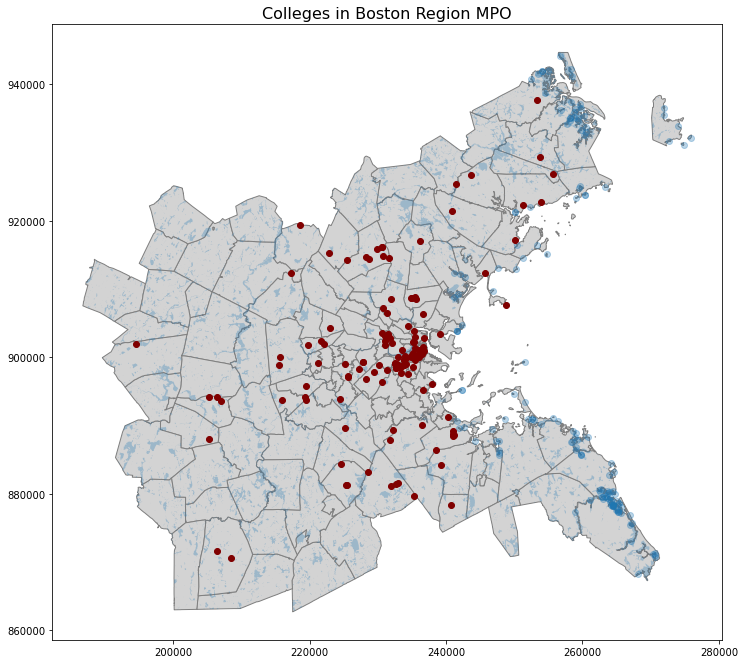

In [20]:
# Plot Boston MPO colleges.
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
colleges.plot(ax=ax, color='maroon')
plt.title('Colleges in Boston Region MPO', fontsize=16)
plt.show()

In [21]:
# List all college names.
college_list = list(colleges.COLLEGE.unique())
college_list

['Dean College',
 "Mafy's Nails Academy",
 'Tri County Regional Vocational Technical High School Adult Education',
 'Toni & Guy Hairdressing Academy',
 'Universal Technical Institute of Massachusetts Inc',
 'University of Phoenix-Boston',
 'Curry College',
 'Massachusetts Bay Community College',
 'Mansfield Beauty Schools',
 'Massachusetts School of Barbering',
 'Newbury College',
 'Boston Career Institute',
 'Boston College',
 'Harvard University',
 'Boston University School of Medicine',
 'Massachusetts College of Pharmacy and Health Science',
 'Massachusetts College of Art and Design',
 'Wentworth Institute of Technology',
 'School of the Museum of Fine Arts',
 'Boston Graduate School of Psychoanalysis Inc',
 'Blessed John Xxiii National Seminary',
 'Simmons College',
 'Northeastern University Professional Advancement Network',
 'Northeastern University',
 'New England Conservatory of Music',
 'Emmanuel College',
 'Ali May Academy',
 'Quincy College',
 'Boston Baptist College',
 'La

In [22]:
# Select only names matching Tufts University or Boston University.
colleges_select = colleges.loc[colleges.COLLEGE.isin(['Tufts University', 'Boston University'])]
colleges_select

COLLEGE                     CAMPUS              ADDRESS  \
136   Tufts University  Medford/Somerville Campus    419 Boston Avenue   
163  Boston University       Charles River Campus         1 Silber Way   
164   Tufts University              Boston Campus  145 Harrison Avenue   

        CITY ZIPCODE PLUS_FOUR GEOG_TOWN        MAIN_TEL  \
136  Medford   02155      None   MEDFORD  (617) 628-5000   
163   Boston   02215      None    BOSTON  (617) 353-2000   
164   Boston   02111      None    BOSTON  (617) 636-7000   

                            URL NCES_ID TYPE                       NCES_TYPE  \
136        http://www.tufts.edu  168148  PRI  4-year, Private not-for-profit   
163           http://www.bu.edu  164988  PRI  4-year, Private not-for-profit   
164  http://medicine.tufts.edu/  168148  PRI  4-year, Private not-for-profit   

                CATEGORY            DEGREEOFFR  \
136  Research University  C, B, PBC, M, PMC, D   
163  Research University  C, B, PBC, M, PMC, D   
164  Research University  C, B, PBC, M, PMC, D   

                                            AWARDSOFFR LARGEPROG  \
136  Two but less than 4 years certificate;Bachelor...      None   
163  Less than one year certificate;One but less th...      None   
164  Two but less than 4 years certificate;Bachelor...      None   

        CAMPUSSETT CAMPUSHOUS        L_SRC                       geometry  
136  Suburb: Large        Yes  nces.ed.gov  POINT (231416.402 906514.073)  
163    City: Large        Yes  nces.ed.gov  POINT (232983.739 899977.282)  
164  Suburb: Large        Yes  nces.ed.gov  POINT (236057.132 900054.525)

In [23]:
# Select only the Medford/Somerville Tufts Campus and the main BU Campus.
tufts_bu = colleges_select.iloc[[0, 1]]
tufts_bu

COLLEGE                     CAMPUS            ADDRESS     CITY  \
136   Tufts University  Medford/Somerville Campus  419 Boston Avenue  Medford   
163  Boston University       Charles River Campus       1 Silber Way   Boston   

    ZIPCODE PLUS_FOUR GEOG_TOWN        MAIN_TEL                   URL NCES_ID  \
136   02155      None   MEDFORD  (617) 628-5000  http://www.tufts.edu  168148   
163   02215      None    BOSTON  (617) 353-2000     http://www.bu.edu  164988   

    TYPE                       NCES_TYPE             CATEGORY  \
136  PRI  4-year, Private not-for-profit  Research University   
163  PRI  4-year, Private not-for-profit  Research University   

               DEGREEOFFR                                         AWARDSOFFR  \
136  C, B, PBC, M, PMC, D  Two but less than 4 years certificate;Bachelor...   
163  C, B, PBC, M, PMC, D  Less than one year certificate;One but less th...   

    LARGEPROG     CAMPUSSETT CAMPUSHOUS        L_SRC  \
136      None  Suburb: Large        Yes  nces.ed.gov   
163      None    City: Large        Yes  nces.ed.gov   

                          geometry  
136  POINT (231416.402 906514.073)  
163  POINT (232983.739 899977.282)

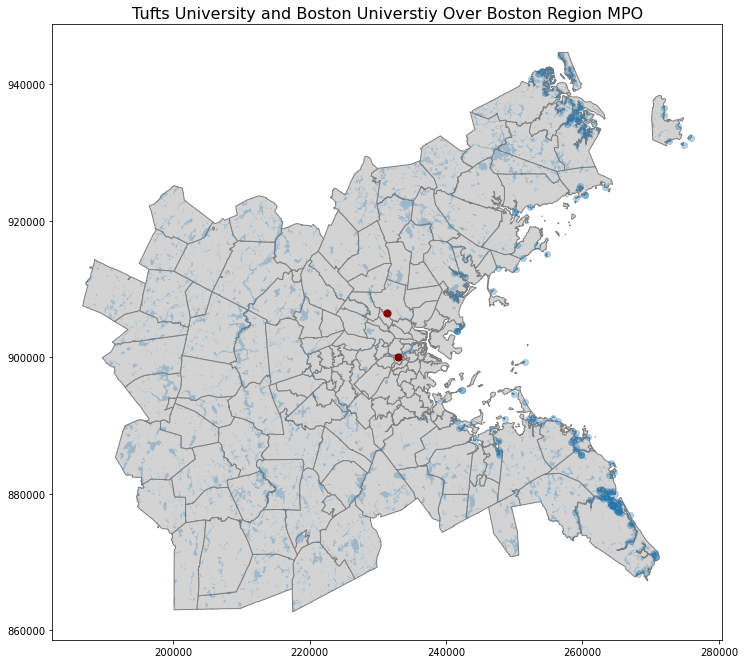

In [24]:
# Plot Tufts and BU on top of the base map.
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
tufts_bu.plot(ax=ax, color='maroon', markersize=50)
plt.title('Tufts University and Boston Universtiy Over Boston Region MPO', fontsize=16)
plt.show()

---

## Import Mass Transit Stops and Routes
Mass/public transit in the Boston area is primarily governed by the Massachusetts Bay Transportation Authority (MBTA) and is available in the form of buses, rapid transit (i.e. the T), and the commuter rail (which is used for traveling to and from the greater metro area). MBTA bus stops data was obtained from MassDOT while MBTA T and Commuter Rail stops and routes data was obtained from MassGIS.

### MBTA Bus Stops

In [25]:
# read_n_clip MBTA bus stops, check CRS, and view info.
bos_bus = read_n_clip('./data/MBTA_Bus_Routes_and_Stops/MBTA_Bus_Routes_and_Stops.shp', boston_zcta)
print(bos_bus.crs)
bos_bus.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 7710 entries, 0 to 7809
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   OBJECTID   7710 non-null   int64   
 1   STOP_ID    7710 non-null   int64   
 2   STOP_NAME  7710 non-null   object  
 3   TOWN       7710 non-null   object  
 4   TOWN_ID    7710 non-null   int64   
 5   geometry   7710 non-null   geometry
dtypes: geometry(1), int64(3), object(2)
memory usage: 421.6+ KB


In [ ]:
bos_bus.head()

### MBTA Rapid Transit (T) Stops and Routes
Stops were read in and processed with `read_n_clip`. However, because routes often go over or under water, routes were read in with `gpd.read_file` and converted to the proper CRS.

In [26]:
# read_n_clip MBTA rapid transit (T) stops, check CRS, and view info.
bos_rt_node = read_n_clip('./data/mbta_rapid_transit/MBTA_NODE.shp', boston_zcta)
print(bos_rt_node.crs)
bos_rt_node.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 166 entries, 0 to 165
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATION   166 non-null    object  
 1   LINE      166 non-null    object  
 2   TERMINUS  166 non-null    object  
 3   ROUTE     166 non-null    object  
 4   geometry  166 non-null    geometry
dtypes: geometry(1), object(4)
memory usage: 7.8+ KB


In [ ]:
# View first five rows.
bos_rt_node.head()

In [27]:
# Read in MBTA rapid transit (T) routes, convert CRS, check CRS, and view info.
bos_rt_route = gpd.read_file('./data/mbta_rapid_transit/MBTA_ARC.shp')
bos_rt_route = bos_rt_route.to_crs(boston_zcta.crs)
print(bos_rt_route.crs)
bos_rt_route.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   LINE       138 non-null    object  
 1   ROUTE      138 non-null    object  
 2   GRADE      138 non-null    int64   
 3   SHAPE_LEN  138 non-null    float64 
 4   geometry   138 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(2)
memory usage: 5.5+ KB


In [ ]:
# View first five rows.
bos_rt_route.head()

### MBTA Commuter Rail Stops and Routes
Stops were read in and processed with `read_n_clip`. Routes were originally read in with `gpd.read_file` and converted to the proper CRS to preserve areas over or under water, but the extent greatly exceeded that of the Boston Region MPO. Therefore, routes were read in and processed with `read_n_clip`.

In [28]:
# read_n_clip Commuter Rail stops, check CRS, and view info.
bos_train_node = read_n_clip('./data/trains/TRAINS_NODE.shp', boston_zcta)
print(bos_train_node.crs)
bos_train_node.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 201 entries, 8 to 386
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATION     201 non-null    object  
 1   C_RAILSTAT  192 non-null    object  
 2   AMTRAK      29 non-null     object  
 3   MAP_STA     109 non-null    object  
 4   LINE_BRNCH  198 non-null    object  
 5   STATE       201 non-null    object  
 6   geometry    201 non-null    geometry
dtypes: geometry(1), object(6)
memory usage: 12.6+ KB


In [ ]:
# View first five rows.
bos_train_node.head()

In [29]:
# read_n_clip Commuter Rail routes, check CRS, and view info.
bos_train_route = read_n_clip('./data/trains/TRAINS_RTE_TRAIN.shp', boston_zcta)
print(bos_train_route.crs)
bos_train_route.info()

epsg:6491
<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 13 entries, 5 to 18
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   COMM_LINE  13 non-null     object  
 1   COMMRAIL   13 non-null     object  
 2   SHAPE_LEN  13 non-null     float64 
 3   geometry   13 non-null     geometry
dtypes: float64(1), geometry(1), object(2)
memory usage: 520.0+ bytes


In [ ]:
# View first five rows.
bos_train_route.head()

### Map Mass Transit with Base Map

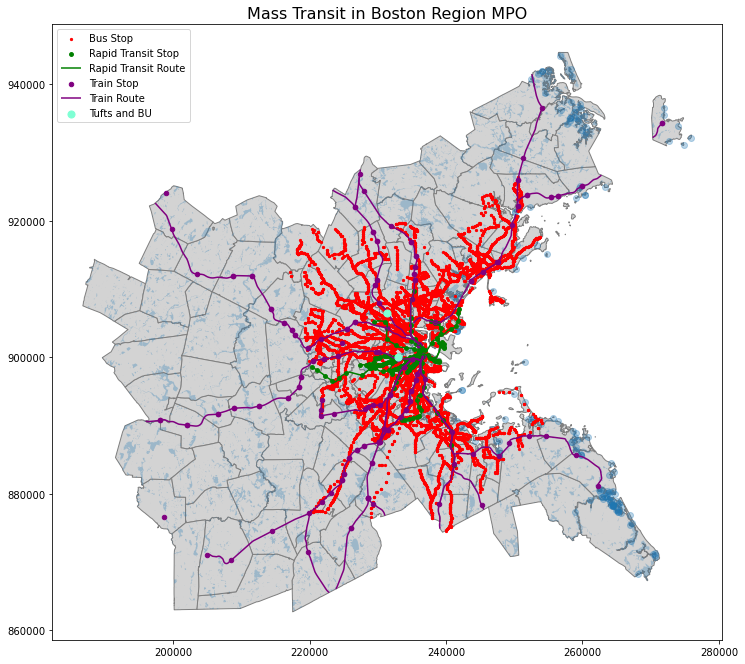

In [30]:
ax = boston_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
bos_bus.plot(ax=ax, color='red', markersize=5, label='Bus Stop')
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
bos_train_node.plot(ax=ax, color='purple', markersize=20, label='Train Stop')
bos_train_route.plot(ax=ax, color='purple', label='Train Route')
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Mass Transit in Boston Region MPO', fontsize=16)
plt.legend()
plt.show()

---

## Limit Study Area to Extent of Rapid Transit
Judging by the vast extent of the commuter rail, the locations of Tufts and BU, and the density of bus and T stops, the outer ZCTAs within the Boston Region MPO are more untenable for regular commutes to work or to campus. Mass transit density analysis that include the outer ZCTAs will skew those within the range of the bus and the T, so they have been excluded from the study by limiting the extent to that of the T.

### Limit with Rectangular Bounds
To limit the study area to the extent of the T for a more realistic comparison of ZCTAs, the following steps were used:
1. Extract the rectangular bounds of MBTA Rapid Transit (T) stops.
1. Create a bounding box with `shapely.geometry.box`.
1. Add a buffer to the bounding box and store as a new extent.
1. Extract Boston Region ZCTAs whose centroids are within the extent.

In [31]:
# Extract bounds of Boston Rapid Transit (T) nodes.
rt_bounds = bos_rt_node.geometry.total_bounds
rt_bounds

array([220391.71303283, 884240.96758161, 241840.82146882, 909753.44856537])

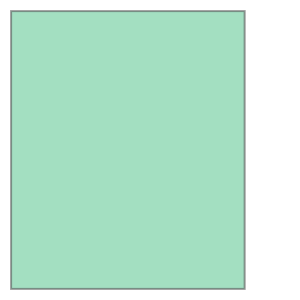

In [32]:
# Creating bounding box with shapely.geometry.box
# shapely.geometry.box(minx, miny, maxx, maxy, ccw=True)
rt_bound_box = box(rt_bounds[0], rt_bounds[1], rt_bounds[2], rt_bounds[3])
rt_bound_box

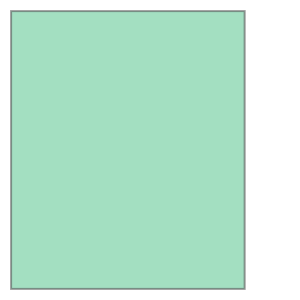

In [33]:
# Store the extent as a Shapely Polygon in a variable called graph_extent.
graph_extent = rt_bound_box.buffer(0.1, join_style=2)
graph_extent

In [34]:
# Extract Boston Region ZCTAs within the graph extent using the centroid of the ZCTAs.
rt_zcta_box = boston_zcta[boston_zcta.centroid.within(graph_extent)]
rt_zcta_box.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 69 entries, 0 to 158
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       69 non-null     int64   
 1   STATEFP00   69 non-null     object  
 2   ZCTA5CE00   69 non-null     object  
 3   GEOID00     69 non-null     object  
 4   CLASSFP00   69 non-null     object  
 5   MTFCC00     69 non-null     object  
 6   FUNCSTAT00  69 non-null     object  
 7   ALAND00     69 non-null     int64   
 8   AWATER00    69 non-null     int64   
 9   INTPTLAT00  69 non-null     object  
 10  INTPTLON00  69 non-null     object  
 11  PARTFLG00   69 non-null     object  
 12  geometry    69 non-null     geometry
dtypes: geometry(1), int64(3), object(9)
memory usage: 7.5+ KB


In [35]:
# View first five rows of rt_zcta_box.
rt_zcta_box.head()

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
0     31        25     02458  2502458        B5   G6350          S   4709183   
4     35        25     02141  2502141        B5   G6350          S   1572423   
5     36        25     02143  2502143        B5   G6350          S   4007477   
6     37        25     02472  2502472        B5   G6350          S  10410330   
7     39        25     02464  2502464        B5   G6350          S   1447706   

   AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
0     57045  +42.3541154  -071.1891300         N   
4     44304  +42.3702998  -071.0825603         N   
5         0  +42.3815721  -071.0969953         N   
6    355268  +42.3694508  -071.1779249         N   
7     29494  +42.3129751  -071.2188818         N   

                                            geometry  
0  MULTIPOLYGON (((227500.026 901300.219, 227482....  
4  POLYGON ((234064.636 902597.603, 234080.228 90...  
5  MULTIPOLYGON (((234059.089 902586.579, 234073....  
6  POLYGON ((223853.273 902504.747, 223982.362 90...  
7  POLYGON ((223497.366 896100.959, 223538.895 89...

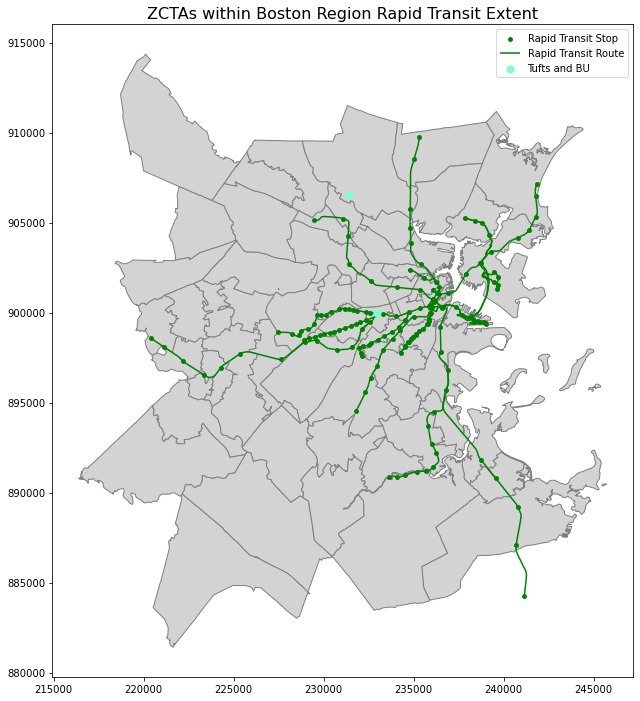

In [36]:
# Plot the Boston Region ZCTAs within graph extent with the T to confirm success.
ax = rt_zcta_box.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('ZCTAs within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

### Limit with Convex Hull
There are a number of ZCTAs that are within the defined rectangular bounds but are not close to a T stop. The extent was further limited to the convex hull of T stops with the following steps:
1. Create a convex hull of T stops with `unary_union.convex_hull`.
1. Add a buffer to the convex hull and store as a new extent.
1. Extract Boston Region ZCTAs that intersect with the extent.

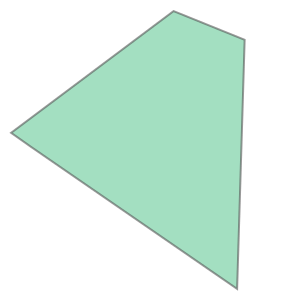

In [37]:
# Create a convex hull from T stops.
convex_bounds = bos_rt_node.unary_union.convex_hull
convex_bounds

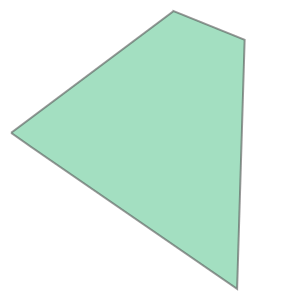

In [38]:
# Store the extent as a Shapely Polygon in a variable called convex_graph_extent.
convex_graph_extent = convex_bounds.buffer(0.1)
convex_graph_extent

In [39]:
# Extract Boston Region ZCTAs that intersect with the graph extent.
rt_zcta = boston_zcta[boston_zcta.intersects(convex_graph_extent)]
rt_zcta.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 62 entries, 0 to 158
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       62 non-null     int64   
 1   STATEFP00   62 non-null     object  
 2   ZCTA5CE00   62 non-null     object  
 3   GEOID00     62 non-null     object  
 4   CLASSFP00   62 non-null     object  
 5   MTFCC00     62 non-null     object  
 6   FUNCSTAT00  62 non-null     object  
 7   ALAND00     62 non-null     int64   
 8   AWATER00    62 non-null     int64   
 9   INTPTLAT00  62 non-null     object  
 10  INTPTLON00  62 non-null     object  
 11  PARTFLG00   62 non-null     object  
 12  geometry    62 non-null     geometry
dtypes: geometry(1), int64(3), object(9)
memory usage: 6.8+ KB


In [35]:
# View first five rows of rt_zcta.
rt_zcta.head()

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
0     31        25     02458  2502458        B5   G6350          S   4709183   
4     35        25     02141  2502141        B5   G6350          S   1572423   
5     36        25     02143  2502143        B5   G6350          S   4007477   
6     37        25     02472  2502472        B5   G6350          S  10410330   
7     39        25     02464  2502464        B5   G6350          S   1447706   

   AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
0     57045  +42.3541154  -071.1891300         N   
4     44304  +42.3702998  -071.0825603         N   
5         0  +42.3815721  -071.0969953         N   
6    355268  +42.3694508  -071.1779249         N   
7     29494  +42.3129751  -071.2188818         N   

                                            geometry  
0  MULTIPOLYGON (((227500.026 901300.219, 227482....  
4  POLYGON ((234064.636 902597.603, 234080.228 90...  
5  MULTIPOLYGON (((234059.089 902586.579, 234073....  
6  POLYGON ((223853.273 902504.747, 223982.362 90...  
7  POLYGON ((223497.366 896100.959, 223538.895 89...

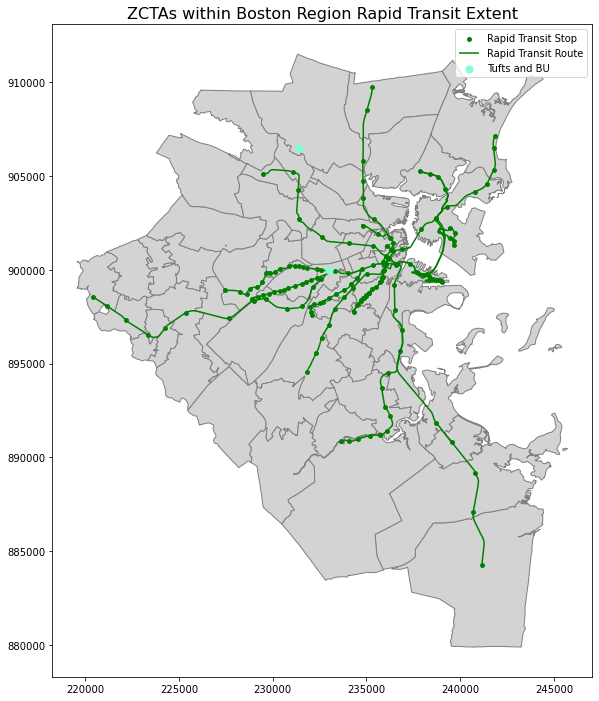

In [40]:
# Plot the Boston Region ZCTAs within convex graph extent to confirm success.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('ZCTAs within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

### Clip All Relevant GDFs
The following GDFs were clipped to the new `rt_zcta` extent:
- `boston_water`
- `bos_bus`
- `bos_train_node`
- `bos_train_route`

Because `bos_rt_node` was used to create the extent and `bos_rt_route` connects all T stops, `bos_rt_route` does not need to be clipped.

In [41]:
# Clip all relevant GDFs.
boston_water = gpd.clip(boston_water, rt_zcta)
bos_bus = gpd.clip(bos_bus, rt_zcta)
bos_train_route = gpd.clip(bos_train_route, rt_zcta)
bos_train_node = gpd.clip(bos_train_node, rt_zcta)

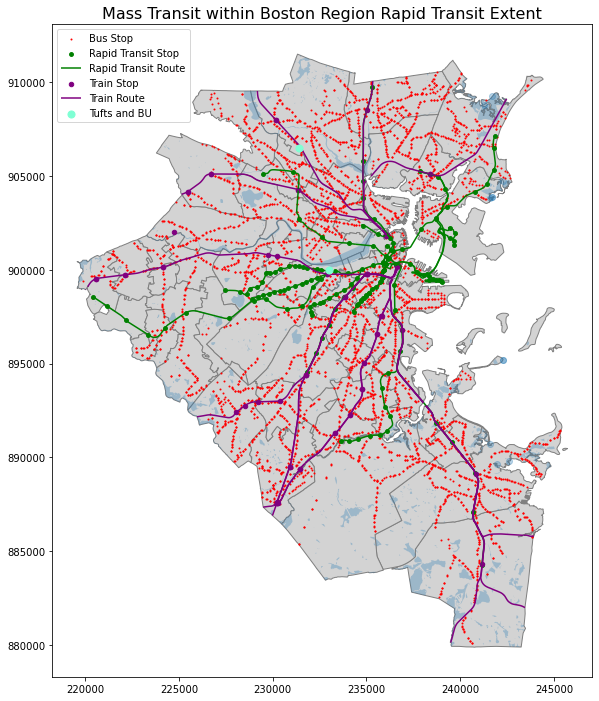

In [42]:
# Plot new extent with mass transit and schools.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
bos_bus.plot(ax=ax, color='red', markersize=1, label='Bus Stop')
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
bos_train_node.plot(ax=ax, color='purple', markersize=20, label='Train Stop')
bos_train_route.plot(ax=ax, color='purple', label='Train Route')
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Mass Transit within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

#### TEST CODE

bos_bus.head()

bos_bus_latlong = bos_bus.to_crs('epsg:4326')
bos_bus_latlong

bos_bus['latitude'] = bos_bus_latlong.geometry.y
bos_bus['longitude'] = bos_bus_latlong.geometry.x
bos_bus.head()

m_1 = folium.Map(location=[42.32, -71.0589], tiles='openstreetmap', zoom_start=20)
mc_1 = MarkerCluster()
for idx, row in bos_bus.iterrows():
    mc_1.add_child(folium.Marker([row['latitude'], row['longitude']], icon=folium.Icon(color='red', icon='bus')))

mc_1.add_to(m_1)
m_1

---

## Mass Transit Accessibility
As the study's premise is living without a car, it is crucial that the home's location be easily accessible by mass transit. Transit stops were selected as an indicator for convenience of mass transit. While the routes are also important to consider, the stops are the on-off points to transit lines and necessary to accessing the transit systems.

The density of mass transit stops was calculated with the following steps:
1. Function `count_records` was created to count the number of records in a GDF within polygons of another GDF (e.g. number of bus stops within a ZCTA).
1. `count_records` was used on the GDFs for bus stops, T stops, and train stops in the limited `rt_zcta` extent.
1. Function `multimerge` was created to merge multiple DataFrames on the same column or list of columns. 
1. `multimerge` was used to add all mass transit stop counts to `rt_zcta` 
1. Total stops and stop density were calculated for all ZCTAs and mapped.

### Count Public Transit Nodes per ZCTA

#### Define Function `count_records`
`count_records` takes a GeoDataFrame and counts the number of records within another GDF of polygons. It outputs a DataFrame with the specified polygon column values and counts column. The optional argument `op` for `gpd.sjoin` defaults to `'within'` unless otherwise specified.

In [43]:
def count_records(records_gdf, polygon_gdf, polygon_col, count_col, op='within'):
    """
    Takes a GeoDataFrame and counts the number of records within another GDF of polygons. 
    Outputs a DataFrame with the specified polygon column values and counts.
    Optional argument op defaults to 'within' unless otherwise specified.
    Requires Pandas and GeoPandas to run.
    
    Inputs:
        records_gdf = GDF of records to count
        polygon_gdf = GDF of polygons to count from
        polygon_col = name of column in polygon_gdf
            e.g. 'name'
        count_col = name of column for counts in output
            e.g. 'tree_count'
        op = op argument for sjoin; defaults to 'within' unless otherwise specified
    
    Example:
    >>> tree_count = count_records(trees, towns, 'name', 'tree_count')
    >>> tree_count
        name          tree_count
    0   Plainsville   68
    1   Springfield   40
    2   Fairfield     81
    3   Greenville    105
    """
    
    # Conduct a spatial join of records and polygons.
    spatial_join = gpd.sjoin(records_gdf, polygon_gdf, how='left', op=op)
    
    # Count the number of records within each polygon.
    records_count = spatial_join[polygon_col].value_counts().reset_index()
    
    # Add columns to the new DF.
    records_count.columns = [polygon_col, count_col]
    
    return records_count

#### Count MBTA Bus Stops per ZCTA

In [44]:
# count_records for bus stops within rt_zcta.
zcta_bus_count = count_records(bos_bus, rt_zcta, 'ZCTA5CE00', 'bus_stop_count')
zcta_bus_count.describe()

bus_stop_count
count       60.000000
mean        81.566667
std         67.974663
min          1.000000
25%         28.750000
50%         76.500000
75%        108.000000
max        334.000000

#### Count MBTA T Stops per ZCTA

In [45]:
# count_records for T stops within rt_zcta.
zcta_rt_count = count_records(bos_rt_node, rt_zcta, 'ZCTA5CE00', 'rt_stop_count')
zcta_rt_count.describe()

rt_stop_count
count      44.000000
mean        3.772727
std         3.678117
min         1.000000
25%         1.000000
50%         2.000000
75%         5.250000
max        15.000000

#### Count Commuter Rail Stops per ZCTA

In [46]:
# count_records for Commuter Rail stops within rt_zcta.
zcta_train_count = count_records(bos_train_node, rt_zcta, 'ZCTA5CE00', 'train_stop_count')
zcta_train_count.describe()

train_stop_count
count         27.000000
mean           2.962963
std            2.608882
min            1.000000
25%            1.500000
50%            2.000000
75%            3.500000
max           10.000000

### Define Function `multimerge`
`multimerge` takes a base DataFrame and merges it with each DataFrame in a list of DataFrames on the specified column or list of columns and with the specified `how`. The function assumes the specified column(s) exist(s) across all DataFrames.

In [47]:
def multimerge(left_df, df_list, on_col, how):
    """
    Takes a base DataFrame and merges with each DataFrame in a list of DataFrames 
    on the specified column or list of columns and with the specified 'how'.
    Assumes on_col exists across all DFs.
    Requires Pandas to run merge method.
    
    Inputs:
        left_df = base DF
        df_list = list of DFs
            e.g. [df1, df2, df3]
        on_col = bracketed column name or list of columns (same across DFs)
            e.g. ['name'], ['name', 'address', 'zip_code']
        how = how argument
            e.g. 'left'
    
    Example:
    >>> town_schools = multimerge(town, [elem, middle, high], ['town_name'], 'left')
    """
    
    # Create a copy of the base DataFrame.
    merge_df = left_df.copy()
    
    # Merge each DataFrame within the list.
    for i in range(len(df_list)):
        merge_df = merge_df.merge(df_list[i], on=on_col, how=how)
        
    return merge_df

### Calculate Mass Transit Density per ZCTA

In [48]:
# Merge rt_zcta with all transit stop counts.
count_list = [zcta_bus_count, zcta_rt_count, zcta_train_count]
zcta_nodes = multimerge(rt_zcta, count_list, ['ZCTA5CE00'], 'left').fillna(0)
zcta_nodes.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   index             62 non-null     int64   
 1   STATEFP00         62 non-null     object  
 2   ZCTA5CE00         62 non-null     object  
 3   GEOID00           62 non-null     object  
 4   CLASSFP00         62 non-null     object  
 5   MTFCC00           62 non-null     object  
 6   FUNCSTAT00        62 non-null     object  
 7   ALAND00           62 non-null     int64   
 8   AWATER00          62 non-null     int64   
 9   INTPTLAT00        62 non-null     object  
 10  INTPTLON00        62 non-null     object  
 11  PARTFLG00         62 non-null     object  
 12  geometry          62 non-null     geometry
 13  bus_stop_count    62 non-null     float64 
 14  rt_stop_count     62 non-null     float64 
 15  train_stop_count  62 non-null     float64 
dtypes: float64(3), geome

In [49]:
# View first five rows of new GDF.
zcta_nodes.head()

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
0     31        25     02458  2502458        B5   G6350          S   4709183   
1     35        25     02141  2502141        B5   G6350          S   1572423   
2     36        25     02143  2502143        B5   G6350          S   4007477   
3     37        25     02472  2502472        B5   G6350          S  10410330   
4     39        25     02464  2502464        B5   G6350          S   1447706   

   AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
0     57045  +42.3541154  -071.1891300         N   
1     44304  +42.3702998  -071.0825603         N   
2         0  +42.3815721  -071.0969953         N   
3    355268  +42.3694508  -071.1779249         N   
4     29494  +42.3129751  -071.2188818         N   

                                            geometry  bus_stop_count  \
0  MULTIPOLYGON (((227500.026 901300.219, 227482....            53.0   
1  POLYGON ((234064.636 902597.603, 234080.228 90...            23.0   
2  MULTIPOLYGON (((234059.089 902586.579, 234073....           108.0   
3  POLYGON ((223853.273 902504.747, 223982.362 90...            99.0   
4  POLYGON ((223497.366 896100.959, 223538.895 89...            22.0   

   rt_stop_count  train_stop_count  
0            0.0               2.0  
1            1.0               0.0  
2            0.0               0.0  
3            0.0               1.0  
4            0.0               0.0

In [50]:
# Calculate total transit stops in each ZCTA.
zcta_nodes['nodes_count'] = zcta_nodes.bus_stop_count + zcta_nodes.rt_stop_count + zcta_nodes.train_stop_count
zcta_nodes

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
0      31        25     02458  2502458        B5   G6350          S   4709183   
1      35        25     02141  2502141        B5   G6350          S   1572423   
2      36        25     02143  2502143        B5   G6350          S   4007477   
3      37        25     02472  2502472        B5   G6350          S  10410330   
4      39        25     02464  2502464        B5   G6350          S   1447706   
..    ...       ...       ...      ...       ...     ...        ...       ...   
57    482        25     02139  2502139        B5   G6350          S   3784723   
58    484        25     02474  2502474        B5   G6350          S   7903556   
59    493        25     02111  2502111        B5   G6350          S    754214   
60    494        25     02130  2502130        B5   G6350          S  11393804   
61    495        25     02222  2502222        B5   G6350          S     77896   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
0      57045  +42.3541154  -071.1891300         N   
1      44304  +42.3702998  -071.0825603         N   
2          0  +42.3815721  -071.0969953         N   
3     355268  +42.3694508  -071.1779249         N   
4      29494  +42.3129751  -071.2188818         N   
..       ...          ...           ...       ...   
57    368360  +42.3622881  -071.1037905         N   
58    518211  +42.4209494  -071.1563695         N   
59     79209  +42.3487843  -071.0589880         N   
60    369565  +42.3072770  -071.1140555         N   
61         0  +42.3664695  -071.0624939         N   

                                             geometry  bus_stop_count  \
0   MULTIPOLYGON (((227500.026 901300.219, 227482....            53.0   
1   POLYGON ((234064.636 902597.603, 234080.228 90...            23.0   
2   MULTIPOLYGON (((234059.089 902586.579, 234073....           108.0   
3   POLYGON ((223853.273 902504.747, 223982.362 90...            99.0   
4   POLYGON ((223497.366 896100.959, 223538.895 89...            22.0   
..                                                ...             ...   
57  POLYGON ((232130.866 902283.249, 232144.254 90...            81.0   
58  POLYGON ((228762.296 906831.977, 228756.803 90...            79.0   
59  POLYGON ((236144.915 900687.565, 236153.840 90...            13.0   
60  POLYGON ((231406.529 893484.217, 231413.864 89...            97.0   
61  POLYGON ((235839.790 902134.685, 235852.488 90...             0.0   

    rt_stop_count  train_stop_count  nodes_count  
0             0.0               2.0         55.0  
1             1.0               0.0         24.0  
2             0.0               0.0        108.0  
3             0.0               1.0        100.0  
4             0.0               0.0         22.0  
..            ...               ...          ...  
57            1.0               0.0         82.0  
58            0.0               0.0         79.0  
59            8.0               9.0         30.0  
60            7.0               3.0        107.0  
61            0.0              10.0         10.0  

[62 rows x 17 columns]

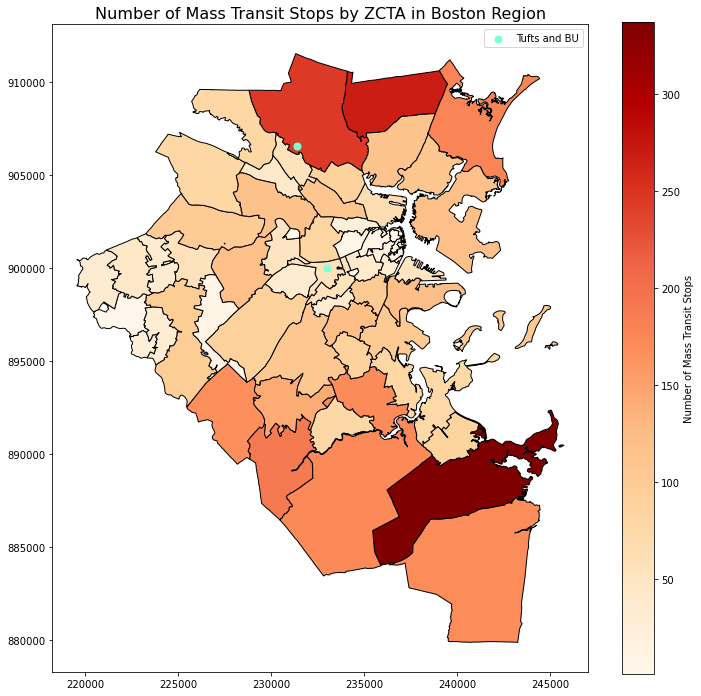

In [51]:
# Map the number of transit stops in each ZCTA.
ax = zcta_nodes.plot(column='nodes_count',
                      legend=True,
                      edgecolor='black',
                      cmap='OrRd',
                      figsize=(12, 12),
                      legend_kwds={'label': "Number of Mass Transit Stops"})
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Number of Mass Transit Stops by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

In [52]:
# Calculate node density in nodes/sqkm.
zcta_nodes['nodes_density'] = zcta_nodes.nodes_count/zcta_nodes.area*(10**6)
zcta_nodes.sort_values(by='nodes_density', ascending=False).head()

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00  ALAND00  \
61    495        25     02222  2502222        B5   G6350          S    77896   
59    493        25     02111  2502111        B5   G6350          S   754214   
49    378        25     02118  2502118        B5   G6350          S  2747439   
33    253        25     02109  2502109        B5   G6350          S   427819   
29    249        25     02119  2502119        B5   G6350          S  4153196   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
61         0  +42.3664695  -071.0624939         N   
59     79209  +42.3487843  -071.0589880         N   
49         0  +42.3378630  -071.0708157         N   
33         0  +42.3626531  -071.0538044         N   
29         0  +42.3238812  -071.0853318         N   

                                             geometry  bus_stop_count  \
61  POLYGON ((235839.790 902134.685, 235852.488 90...             0.0   
59  POLYGON ((236144.915 900687.565, 236153.840 90...            13.0   
49  POLYGON ((235192.725 898164.265, 235174.169 89...            87.0   
33  MULTIPOLYGON (((236437.338 900792.044, 236429....            13.0   
29  POLYGON ((235115.975 898168.657, 235148.036 89...           120.0   

    rt_stop_count  train_stop_count  nodes_count  nodes_density  
61            0.0              10.0         10.0     128.417764  
59            8.0               9.0         30.0      39.540383  
49           15.0               1.0        103.0      37.491925  
33            1.0               0.0         14.0      33.228131  
29            2.0               0.0        122.0      29.376895

In [53]:
# View statistics for nodes_density.
zcta_nodes.nodes_density.describe()

count     62.000000
mean      17.298751
std       16.739132
min        0.478677
25%        9.111375
50%       14.511331
75%       20.553204
max      128.417764
Name: nodes_density, dtype: float64

The top value for `nodes_density` greatly exceeds the next value, despite having a low `nodes_count`, indicating it is an outlier. The ZCTA in question, ZCTA 02222, appears to contain only TD Garden and North Station. Though setting the `nodes_density` value for ZCTA 02222 to the median value to prevent skewing the analysis was contemplated, the decision was ultimately made to allow the outlier as reclassification would nearly negate the skew.

##### ZCTA 02222 value for nodes_density set to median value.
zcta_nodes.loc[61, 'nodes_density'] = zcta_nodes.nodes_density.median()
zcta_nodes.sort_values(by='nodes_density', ascending=False).head()

##### View statistics for nodes_density.
zcta_nodes.nodes_density.describe()

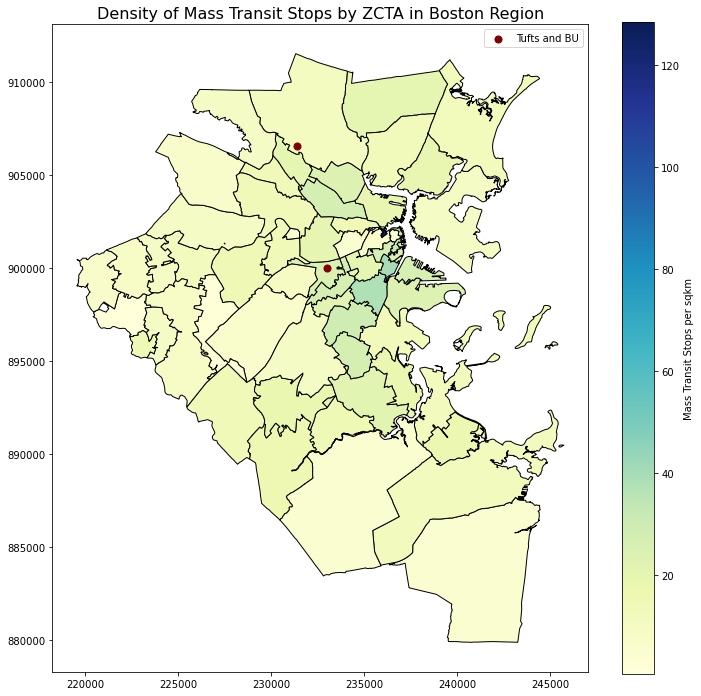

In [54]:
# Map the density of transit nodes in each ZCTA.
ax = zcta_nodes.plot(column='nodes_density',
                      legend=True,
                      edgecolor='black',
                      cmap='YlGnBu',
                      figsize=(12, 12),
                      legend_kwds={'label': "Mass Transit Stops per sqkm"})
tufts_bu.plot(ax=ax, color='maroon', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Density of Mass Transit Stops by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

### Reclassify Mass Transit Density
To reclassify indicators, quantile values need to be found for each indicator and used to reclassify values in roughly equal segments. The `quantiles` function was created to find any number of quantiles, while the `reclass_5` function was created to reclassify indicators into five classes.

#### Define Functions `quantiles` and `reclass_5`
`quantiles` takes a DataFrame, a column name, and a list of quantile thresholds (between 0 and 1) and outputs a list of quantile values for the column.

In [55]:
def quantiles(df, col, threshold_list):
    """
    Takes a DataFrame, a column name, and a list of quantile thresholds 
    (between 0 and 1) and outputs a list of quantile values for the column.
    Requires NumPy to run numpy.quantile function.
    
    Inputs:
        df = DataFrame variable name
        col = column name as a string
            e.g. 'mean'
        threshold list = bracketed list of quantile thresholds between 0 and 1
            e.g. [0.25, 0.5, 0.75], [0.2, 0.4, 0.6, 0.8]
    
    Example:
    >>> quarts = [0.25, 0.5, 0.75]
    >>> quantiles(student, 'grades', quarts)
    [65.6, 80.5, 88.0]
    
    """
    # Create empty list.
    quant_list = []
    
    # Calculate and append quantiles.
    for i in range(len(threshold_list)):
        quant_list.append(np.quantile(df[col], threshold_list[i]))
        
    return quant_list                                       

`reclass_5` takes a value and reclassifies it into 1 of 5 classes given a list of values for class thresholds and order preference.

In [56]:
# Create a function that reclassifies an array into 5 classes.
def reclass_5(val, class_list, order):
    """
    Takes a value and reclassifies it into 1 of 5 classes given a list
    of values for class thresholds and order preference.
    Assumes no overall minimum or maximum.
    Requires NumPy to run to account for np.NaN values.
    
    Inputs:
        val = value to classify
        class_list = numeric list of class thresholds in any order
            e.g. [1.5, 3, 6, 4.5] or [100, 200, 400, 800]
        order = 'low' or 'high' for which values are preferable
            e.g. 'low' indicates lower values are preferable
    
    Example:
    >>> thresholds = [200, 800, 400, 600]
    >>> reclass_5(693, thresholds, 'high')
    4
    
    """
    
    # Assert class_list is a list, has four values, and all values are numeric.
    assert type(class_list)==list, "class_list must be a list."
    assert len(class_list)==4, "class_list must have four values."
    assert all(isinstance(x, (int, float)) for x in class_list), "class_list must be comprised of only numbers."
    
    # Sort class_list descending.
    class_sort = sorted(class_list, reverse=True)
    
    # Return np.NaN if value is np.NaN.
    if np.isnan(val):
        return np.NaN
    
    # Reclassify if lower values are preferred.
    elif order=='low':
        if val >= class_sort[0]:
            return 1
        elif val >= class_sort[1]:
            return 2
        elif val >= class_sort[2]:
            return 3
        elif val >= class_sort[3]:
            return 4
        else:
            return 5
    
    # Reclassify if higher values are preferred.
    elif order=='high':
        if val >= class_sort[0]:
            return 5
        elif val >= class_sort[1]:
            return 4
        elif val >= class_sort[2]:
            return 3
        elif val >= class_sort[3]:
            return 2
        else:
            return 1

In [57]:
# Calculate values to separate median into five quantiles.
quintiles = [0.2, 0.4, 0.6, 0.8]
nodes_quints = quantiles(zcta_nodes, 'nodes_density', quintiles)
nodes_quints

[8.453071120523035, 12.466739130549241, 17.545737265625238, 23.632847480082592]

In [58]:
# Reclassify nodes_density.
zcta_nodes['nodes_density_reclass'] = zcta_nodes['nodes_density'].apply(lambda x: reclass_5(x, nodes_quints, 'high'))

In [59]:
# View top and bottom five transit-dense ZCTAs.
zcta_nodes.sort_values(by='nodes_density_reclass', ascending=False)

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
61    495        25     02222  2502222        B5   G6350          S     77896   
49    378        25     02118  2502118        B5   G6350          S   2747439   
18    116        25     02210  2502210        B5   G6350          S   2023105   
17    115        25     02115  2502115        B5   G6350          S   1979415   
32    252        25     02127  2502127        B5   G6350          S   5184543   
..    ...       ...       ...      ...       ...     ...        ...       ...   
50    379        25     02114  2502114        B5   G6350          S   1065352   
22    176        25     02163  2502163        B5   G6350          S    316665   
43    365        25     02466  2502466        B5   G6350          S   4650253   
46    370        25     02467  2502467        B5   G6350          S   5755959   
21    171        25     02184  2502184        B5   G6350          S  35903196   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
61         0  +42.3664695  -071.0624939         N   
49         0  +42.3378630  -071.0708157         N   
18         0  +42.3476816  -071.0417309         N   
17    162098  +42.3375449  -071.1061732         N   
32    580371  +42.3360044  -071.0386949         N   
..       ...          ...           ...       ...   
50    343761  +42.3631745  -071.0686463         N   
22     32165  +42.3661684  -071.1228503         N   
43    263098  +42.3444566  -071.2486166         N   
46    108004  +42.3220888  -071.1727600         N   
21   2081541  +42.2054158  -071.0021680         N   

                                             geometry  bus_stop_count  \
61  POLYGON ((235839.790 902134.685, 235852.488 90...             0.0   
49  POLYGON ((235192.725 898164.265, 235174.169 89...            87.0   
18  MULTIPOLYGON (((236771.808 900243.394, 236722....            39.0   
17  POLYGON ((233785.591 900215.963, 233773.509 90...            48.0   
32  MULTIPOLYGON (((236779.574 897152.363, 236737....           121.0   
..                                                ...             ...   
50  MULTIPOLYGON (((234691.735 900849.190, 234663....             5.0   
22  POLYGON ((231019.106 902090.531, 231035.630 90...             1.0   
43  POLYGON ((219787.259 899807.604, 219812.724 89...            29.0   
46  POLYGON ((226191.027 898407.653, 226180.838 89...             9.0   
21  MULTIPOLYGON (((237408.847 882805.326, 237292....           167.0   

    rt_stop_count  train_stop_count  nodes_count  nodes_density  \
61            0.0              10.0         10.0     128.417764   
49           15.0               1.0        103.0      37.491925   
18           13.0               0.0         52.0      26.095544   
17            9.0               0.0         57.0      26.618441   
32            2.0               0.0        123.0      23.801115   
..            ...               ...          ...            ...   
50            3.0               0.0          8.0       5.945953   
22            0.0               0.0          1.0       2.866897   
43            1.0               2.0         32.0       6.513284   
46            1.0               0.0         10.0       1.705442   
21            1.0               1.0        169.0       4.494594   

    nodes_density_reclass  
61                      5  
49                      5  
18                      5  
17                      5  
32                      5  
..                    ...  
50                      1  
22                      1  
43                      1  
46                      1  
21                      1  

[62 rows x 19 columns]

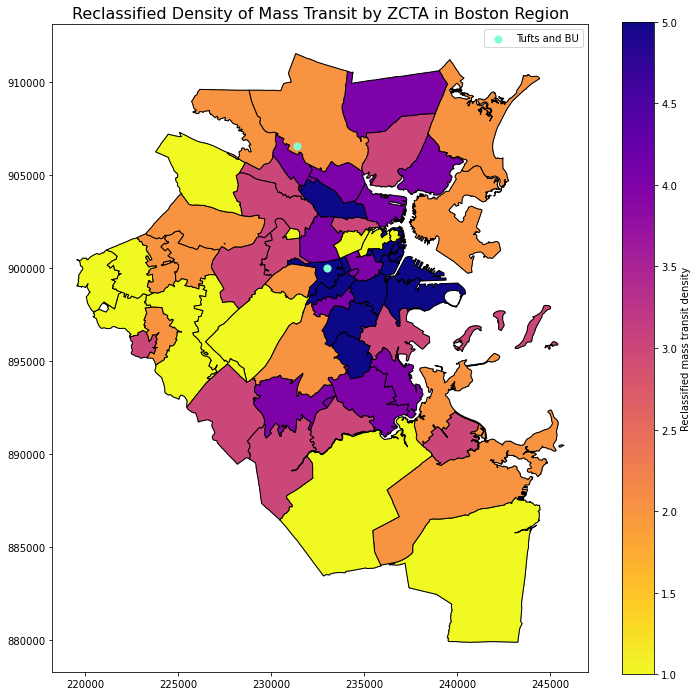

In [60]:
# Map the reclassified mass transit density in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_nodes.plot(column='nodes_density_reclass',
                 legend=True,
                 edgecolor='black',
                 cmap='plasma_r',
                 legend_kwds={'label': "Reclassified mass transit density"},
                 ax=ax)
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Reclassified Density of Mass Transit by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

---

## Rent Affordability
Rent is a crucial expense for any non-homeowner and a large cost-burden, especially in an urban area. Rent affordability in this study was judged by the median rent for a two- or three-bedroom home in each ZCTA. 

Data was obtained from [Jeff Kaufman's Apartment Price Map](https://www.jefftk.com/apartment_prices/details), which scraps data from [Padmapper](https://www.padmapper.com/). Though the dataset does not cover the entire defined extent (53 of 62 ZCTAs are represented), it was the best source of point data found for the Boston Region.

Zillow data was also considered as a source, but it was much more limited in extent. Only 37 of the 62 ZCTAs in question were available in the Zillow dataset. Zillow analysis has been included as an appendix at the end of the study for those who are curious. 

The following steps were used to analyze rental data:
1. Read in CSV file with point data on rental listings.
1. Conduct a spatial join to match listings with ZCTAs.
1. Calculate statistics on rental prices, including `len`, `min`, `max`, `median`, `mean`, `std`. 
1. Reclassify median rent prices in quintiles.

In [61]:
# Read in CSV file of Boston region rental data, obtained from Padmapper via Jeff Kaufman.
rent_df = pd.read_csv('./data/20200919_rental_data.csv')
# Convert to GeoDataFrame, setting CRS to EPSG:4326
rent = gpd.GeoDataFrame(rent_df, geometry=gpd.points_from_xy(rent_df.longitude, rent_df.latitude))
rent = rent.set_crs('epsg:4326')

In [62]:
# View original rent dataset.
rent

price  rooms        ID  longitude   latitude  \
0       2900      1  41791420 -71.172164  42.278143   
1       1960      1  29649753 -71.157981  42.296967   
2       1960      1   5036904 -71.157926  42.296937   
3       2330      1  16243592 -71.157935  42.297520   
4       2770      2  16243593 -71.157935  42.297520   
...      ...    ...       ...        ...        ...   
22345   1550      1  43007574 -71.020512  42.418345   
22346   1800      1  43014171 -71.003435  42.410790   
22347   1950      2  43026486 -71.021522  42.401784   
22348   2400      3  43057610 -70.998380  42.407041   
22349   2982      1  43084453 -70.991490  42.395760   

                         geometry  
0      POINT (-71.17216 42.27814)  
1      POINT (-71.15798 42.29697)  
2      POINT (-71.15793 42.29694)  
3      POINT (-71.15793 42.29752)  
4      POINT (-71.15793 42.29752)  
...                           ...  
22345  POINT (-71.02051 42.41835)  
22346  POINT (-71.00344 42.41079)  
22347  POINT (-71.02152 42.40178)  
22348  POINT (-70.99838 42.40704)  
22349  POINT (-70.99149 42.39576)  

[22350 rows x 6 columns]

In [63]:
# convert_n_clip rental data to CRS and extent of study area rt_zcta.
rent = convert_n_clip(rent, rt_zcta)
rent

price  rooms        ID  longitude   latitude  \
0       2900      1  41791420 -71.172164  42.278143   
1       1960      1  29649753 -71.157981  42.296967   
2       1960      1   5036904 -71.157926  42.296937   
3       2330      1  16243592 -71.157935  42.297520   
4       2770      2  16243593 -71.157935  42.297520   
...      ...    ...       ...        ...        ...   
22345   1550      1  43007574 -71.020512  42.418345   
22346   1800      1  43014171 -71.003435  42.410790   
22347   1950      2  43026486 -71.021522  42.401784   
22348   2400      3  43057610 -70.998380  42.407041   
22349   2982      1  43084453 -70.991490  42.395760   

                            geometry  
0      POINT (227041.857 892015.211)  
1      POINT (228203.365 894110.665)  
2      POINT (228207.914 894107.351)  
3      POINT (228206.913 894172.080)  
4      POINT (228206.913 894172.080)  
...                              ...  
22345  POINT (239463.359 907647.313)  
22346  POINT (240873.695 906816.217)  
22347  POINT (239390.553 905807.311)  
22348  POINT (241292.264 906402.161)  
22349  POINT (241866.889 905152.495)  

[22303 rows x 6 columns]

In [64]:
# Narrow down listings dataset to 2 or 3 bedrooms.
rent_br = rent.loc[rent.rooms.isin([2, 3])]
rent_br

price  rooms        ID  longitude   latitude  \
4       2770      2  16243593 -71.157935  42.297520   
5       2820      2  32940159 -71.157792  42.296119   
6       2850      2  32940162 -71.157792  42.296119   
7       2850      2  32940169 -71.157792  42.296119   
8       3000      2  35159221 -71.157429  42.296666   
...      ...    ...       ...        ...        ...   
22342   1800      2  42980951 -71.024810  42.424957   
22343   2700      3  42995819 -71.015314  42.410007   
22344   2700      3  43004511 -71.015451  42.410235   
22347   1950      2  43026486 -71.021522  42.401784   
22348   2400      3  43057610 -70.998380  42.407041   

                            geometry  
4      POINT (228206.913 894172.080)  
5      POINT (228219.328 894016.525)  
6      POINT (228219.328 894016.525)  
7      POINT (228219.328 894016.525)  
8      POINT (228249.035 894077.370)  
...                              ...  
22342  POINT (239105.533 908379.772)  
22343  POINT (239896.429 906723.576)  
22344  POINT (239885.017 906748.815)  
22347  POINT (239390.553 905807.311)  
22348  POINT (241292.264 906402.161)  

[10437 rows x 6 columns]

In [65]:
# View statistics on price of 2-3BR homes.
rent_br['price'].describe()

count    10437.000000
mean      3109.432021
std       1480.840304
min        800.000000
25%       2400.000000
50%       2850.000000
75%       3465.000000
max      61005.000000
Name: price, dtype: float64

The range of rental prices for 2-3 bedroom homes is very large but the vast majority are concentrated at the lower end. A colormap to map rental prices was accordingly chosen for the most variation at the lower end.

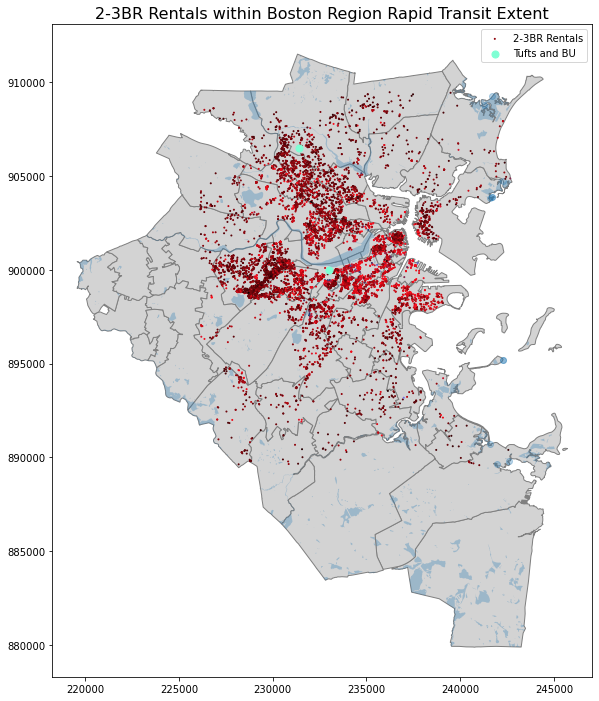

In [66]:
# Plot rental listings by price with schools.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
rent_br.plot(ax=ax, column='price', cmap='gist_stern', markersize=1, label='2-3BR Rentals')
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('2-3BR Rentals within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

### Conduct Spatial Join to Match Rents with ZCTAs

In [67]:
rent_br_zcta = gpd.sjoin(rent_br, rt_zcta, how='left', op='within')
rent_br_zcta

price  rooms        ID  longitude   latitude  \
4       2770      2  16243593 -71.157935  42.297520   
5       2820      2  32940159 -71.157792  42.296119   
6       2850      2  32940162 -71.157792  42.296119   
7       2850      2  32940169 -71.157792  42.296119   
8       3000      2  35159221 -71.157429  42.296666   
...      ...    ...       ...        ...        ...   
22342   1800      2  42980951 -71.024810  42.424957   
22343   2700      3  42995819 -71.015314  42.410007   
22344   2700      3  43004511 -71.015451  42.410235   
22347   1950      2  43026486 -71.021522  42.401784   
22348   2400      3  43057610 -70.998380  42.407041   

                            geometry  index_right  index STATEFP00 ZCTA5CE00  \
4      POINT (228206.913 894172.080)           16     54        25     02132   
5      POINT (228219.328 894016.525)           16     54        25     02132   
6      POINT (228219.328 894016.525)           16     54        25     02132   
7      POINT (228219.328 894016.525)           16     54        25     02132   
8      POINT (228249.035 894077.370)           16     54        25     02132   
...                              ...          ...    ...       ...       ...   
22342  POINT (239105.533 908379.772)           58    177        25     02151   
22343  POINT (239896.429 906723.576)           58    177        25     02151   
22344  POINT (239885.017 906748.815)           58    177        25     02151   
22347  POINT (239390.553 905807.311)           79    254        25     02150   
22348  POINT (241292.264 906402.161)           58    177        25     02151   

       GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  AWATER00   INTPTLAT00  \
4      2502132        B5   G6350          S  11715729    249516  +42.2809050   
5      2502132        B5   G6350          S  11715729    249516  +42.2809050   
6      2502132        B5   G6350          S  11715729    249516  +42.2809050   
7      2502132        B5   G6350          S  11715729    249516  +42.2809050   
8      2502132        B5   G6350          S  11715729    249516  +42.2809050   
...        ...       ...     ...        ...       ...       ...          ...   
22342  2502151        B5   G6350          S  14467229    996735  +42.4182781   
22343  2502151        B5   G6350          S  14467229    996735  +42.4182781   
22344  2502151        B5   G6350          S  14467229    996735  +42.4182781   
22347  2502150        B5   G6350          S   5772123      1921  +42.3966895   
22348  2502151        B5   G6350          S  14467229    996735  +42.4182781   

         INTPTLON00 PARTFLG00  
4      -071.1639646         N  
5      -071.1639646         N  
6      -071.1639646         N  
7      -071.1639646         N  
8      -071.1639646         N  
...             ...       ...  
22342  -071.0050847         N  
22343  -071.0050847         N  
22344  -071.0050847         N  
22347  -071.0327234         N  
22348  -071.0050847         N  

[10437 rows x 19 columns]

### Calculate Statistics for Rent Prices 

In [68]:
# Calculate statistics on price by ZCTA.
zcta_rent_stats = rent_br_zcta.groupby('ZCTA5CE00').price.agg([len, min, max, np.median, np.mean, np.std])
zcta_rent_stats

len   min    max  median         mean          std
ZCTA5CE00                                                     
02108        58  2125  20535  3600.0  4951.155172  3328.894315
02109        84  1800  14500  3600.0  3829.035714  1671.594257
02110        28  3825   8400  3825.0  4413.178571  1081.703425
02111       131  1700  20000  3793.0  4423.022901  2219.974205
02113       340  1700  37775  2800.0  3010.494118  2109.259743
02114       443  1675  13865  3095.0  3350.467269  1212.704073
02115       525  1425  29000  3000.0  3364.878095  1659.890433
02116       317  2095  25000  3930.0  4536.722397  2432.143375
02118       470  1700  12591  3497.5  3655.193617  1135.062965
02119       124  1800   8716  2700.0  2789.048387   834.638638
02120       186  1800   5455  3000.0  3102.408602   683.584420
02121        15  1900   4000  2800.0  2850.000000   670.820393
02122        47  1800  28000  2375.0  2915.531915  3751.447581
02124        62  1400   4000  2450.0  2482.419355   500.719762
02125       104   800   6046  2575.0  2747.125000   692.623655
02126        12  1900   2600  2037.5  2102.083333   233.174324
02127       380  1800  15324  3400.0  3470.139474  1019.342855
02128       224  1650   5791  2500.0  2681.517857   778.424343
02129        91  2000  10251  3300.0  3532.615385  1242.872495
02130       277  1700  15477  2750.0  3290.010830  2082.450936
02131        50  1875   6139  2500.0  2790.240000   965.723702
02132        80  1700   4590  2650.0  2617.887500   513.956926
02134       653  1458   6439  2500.0  2660.522205   685.507412
02135      1052   850   6520  2328.5  2508.267110   642.369844
02136         8  1500   2900  1935.0  2152.500000   529.973045
02138       363  1800   7960  3000.0  3155.355372   787.717616
02139       364  1800   9576  2900.0  3088.434066   878.187583
02140       195  1825   4800  2850.0  2963.651282   675.164723
02141       203  1550  17312  2850.0  3140.295567  1527.734844
02142        41  2920   9950  3415.0  4719.146341  2291.116252
02143       356  1000   6413  2600.0  2686.292135   606.074856
02144       355  1800  12168  2595.0  2668.177465   704.155943
02145       262  1700  12853  2525.0  2715.202290  1029.238874
02148        95  1650   3999  2200.0  2354.926316   516.492101
02149        47  1850   6600  2400.0  2805.404255  1147.863491
02150        39  1700   6854  2400.0  2588.820513   880.597013
02151        29  1700  10085  2502.0  2883.413793  1623.189926
02155       255   950   6935  2300.0  2439.800000   619.721879
02169         8  1650   2950  2494.5  2436.125000   486.600581
02170        10  1595   2995  1900.0  2046.500000   413.729984
02171        10  2100   6995  2500.0  3134.200000  1519.386484
02186         7  2195   4500  2750.0  2956.428571   811.350285
02199         4  4989  16440  7937.5  9326.000000  5221.182561
02210        98  3265  61005  4791.5  5767.857143  6137.020209
02215       677  1750  14967  3116.0  3382.194978  1329.241393
02222         2  2400   5980  4190.0  4190.000000  2531.442277
02445       263  1850  12761  2600.0  2788.733840   837.589096
02446       801  1300  13776  3000.0  3206.340824   985.818593
02458        12  2000   4200  2300.0  2449.166667   578.323727
02467        30  1750   5895  3125.0  3394.000000  1049.389872
02472        55  1750   3625  2400.0  2485.272727   358.625744
02474        47  1775   3600  2400.0  2473.914894   459.374472
02478        48  1900   4030  2200.0  2392.708333   418.349033

In [69]:
# View statistics for median rent prices.
zcta_rent_stats['median'].describe()

count      53.000000
mean     2927.981132
std       912.654323
min      1900.000000
25%      2450.000000
50%      2700.000000
75%      3116.000000
max      7937.500000
Name: median, dtype: float64

In [70]:
# Merge statistics with spatial ZCTA rental GDF.
zcta_rent = rt_zcta.merge(zcta_rent_stats, on='ZCTA5CE00', how='left')
zcta_rent.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 19 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       62 non-null     int64   
 1   STATEFP00   62 non-null     object  
 2   ZCTA5CE00   62 non-null     object  
 3   GEOID00     62 non-null     object  
 4   CLASSFP00   62 non-null     object  
 5   MTFCC00     62 non-null     object  
 6   FUNCSTAT00  62 non-null     object  
 7   ALAND00     62 non-null     int64   
 8   AWATER00    62 non-null     int64   
 9   INTPTLAT00  62 non-null     object  
 10  INTPTLON00  62 non-null     object  
 11  PARTFLG00   62 non-null     object  
 12  geometry    62 non-null     geometry
 13  len         53 non-null     float64 
 14  min         53 non-null     float64 
 15  max         53 non-null     float64 
 16  median      53 non-null     float64 
 17  mean        53 non-null     float64 
 18  std         53 non-null     float64 
dtypes:

In [71]:
# Rename columns to include rent (important for merging data later).
zcta_rent = zcta_rent.rename(columns={'len':'rent_len', 'min':'rent_min', 'max':'rent_max', 'median':'rent_median', 'mean':'rent_mean', 'std':'rent_std'})

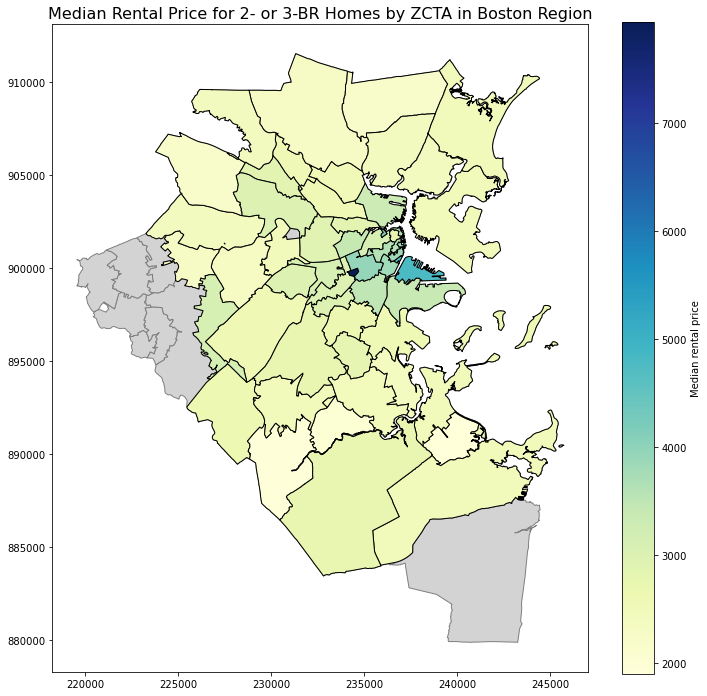

In [72]:
# Map the median rent price in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_rent.plot(column='rent_median',
                 legend=True,
                 edgecolor='black',
                 cmap='YlGnBu',
                 legend_kwds={'label': "Median rental price"},
                 ax=ax)
tufts_bu.plot(ax=ax, color='maroon', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Median Rental Price for 2- or 3-BR Homes by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

### Reclassify Rent Prices

In [73]:
# Calculate values to separate median into five quantiles.
# Use same quintiles list of thresholds from reclassifying transit.
rent_quants = quantiles(zcta_rent_stats, 'median', quintiles)
rent_quants

[2400.0, 2565.0, 2850.0, 3360.0]

In [74]:
# Reclassify median rent prices with reclass_5 function and quintile values.
zcta_rent['rent_median_reclass'] = zcta_rent['rent_median'].apply(lambda x: reclass_5(x, rent_quants, 'low'))

In [75]:
# View top and bottom five median rental ZCTAs.
zcta_rent.sort_values(by='rent_median_reclass', ascending=False)

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
0      31        25     02458  2502458        B5   G6350          S   4709183   
11     58        25     02126  2502126        B5   G6350          S   5260166   
39    305        25     02135  2502135        B5   G6350          S   7222258   
31    251        25     02122  2502122        B5   G6350          S   4420941   
27    237        25     02478  2502478        B5   G6350          S  11967374   
..    ...       ...       ...      ...       ...     ...        ...       ...   
25    229        25     02460  2502460        B5   G6350          S   3651425   
26    236        25     02461  2502461        B5   G6350          S   3263402   
35    285        25     02459  2502459        B5   G6350          S  12417620   
43    365        25     02466  2502466        B5   G6350          S   4650253   
44    366        25     02465  2502465        B5   G6350          S   5288332   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
0      57045  +42.3541154  -071.1891300         N   
11     67030  +42.2748559  -071.0929083         N   
39    469151  +42.3484167  -071.1543392         N   
31      9382  +42.2950881  -071.0525334         N   
27    186828  +42.3953169  -071.1802840         N   
..       ...          ...           ...       ...   
25     20856  +42.3520061  -071.2092424         N   
26     13513  +42.3190310  -071.2081690         N   
35    237715  +42.3142917  -071.1946111         N   
43    263098  +42.3444566  -071.2486166         N   
44       698  +42.3495328  -071.2273393         N   

                                             geometry  rent_len  rent_min  \
0   MULTIPOLYGON (((227500.026 901300.219, 227482....      12.0    2000.0   
11  MULTIPOLYGON (((232299.828 890594.954, 232285....      12.0    1900.0   
39  POLYGON ((227999.354 898147.705, 227992.923 89...    1052.0     850.0   
31  POLYGON ((237311.389 892366.860, 237300.520 89...      47.0    1800.0   
27  POLYGON ((227491.087 906255.384, 227559.274 90...      48.0    1900.0   
..                                                ...       ...       ...   
25  POLYGON ((224712.729 900305.384, 224780.933 90...       NaN       NaN   
26  POLYGON ((223647.892 895122.104, 223644.504 89...       NaN       NaN   
35  MULTIPOLYGON (((226381.301 895402.075, 226417....       NaN       NaN   
43  POLYGON ((219787.259 899807.604, 219812.724 89...       NaN       NaN   
44  POLYGON ((223352.806 900852.454, 223367.983 90...       NaN       NaN   

    rent_max  rent_median    rent_mean     rent_std  rent_median_reclass  
0     4200.0       2300.0  2449.166667   578.323727                  5.0  
11    2600.0       2037.5  2102.083333   233.174324                  5.0  
39    6520.0       2328.5  2508.267110   642.369844                  5.0  
31   28000.0       2375.0  2915.531915  3751.447581                  5.0  
27    4030.0       2200.0  2392.708333   418.349033                  5.0  
..       ...          ...          ...          ...                  ...  
25       NaN          NaN          NaN          NaN                  NaN  
26       NaN          NaN          NaN          NaN                  NaN  
35       NaN          NaN          NaN          NaN                  NaN  
43       NaN          NaN          NaN          NaN                  NaN  
44       NaN          NaN          NaN          NaN                  NaN  

[62 rows x 20 columns]

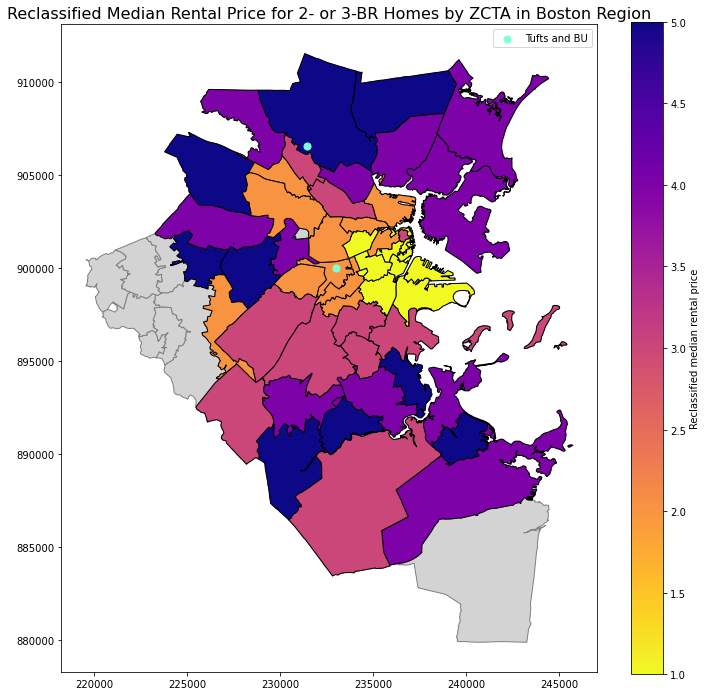

In [166]:
# Map the median rent price in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_rent.plot(column='rent_median_reclass',
                 legend=True,
                 edgecolor='black',
                 cmap='plasma_r', #reverse colormap to indicate lower values are preferable
                 legend_kwds={'label': "Reclassified median rental price"},
                 ax=ax)
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Reclassified Median Rental Price for 2- or 3-BR Homes by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

Though rental data was only available in 53 of the 62 ZCTAs, the remaining indicators will be analyzed for the entire extent. ZCTAs lacking rental data will be excluded in the overall index calculation at the end to ensure fairness across ZCTAs.

---

## Locations and Density of Necessities
Accessibility of necessities and amenities is crucial to living anywhere. For the purposes of this study, necessities were defined as follows:
- Food
    - Groceries (e.g. supermarkets and food purveryors, like  greengrocers, butchers, etc.)
    - Prepared food (e.g. restaurants, cafes, etc.)
    - Farmers markets
- Health Services
    - Community health centers
    - Hospitals
    - Healthcare facilities (e.g. doctors' offices, pharmacies, dentists, etc.)
- Public Services
    - Fire stations
    - Police stations
    - USPS Post Offices
    - Libraries

Some data was imported from sources such as MassGIS while others were retrieved using `OpenStreetMap` and `OSMnx`'s `geometries_from_polygon` function.

### Create Extent in Latitude-Longitude to Use With `OSMnx`
To use `OSMnx geometries_from_polygon`, a polygon needs to be created in latitude-longitude coordinates. This was accomplished with the following steps:
1. Convert the T stops shapefile to `EPSG:4326` for lat-long and extract its rectangular bounds.
1. Create a bounding box with `shapely.geometry.box`.
1. Add a buffer to the bounding box and store as a new extent.

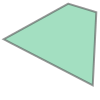

In [77]:
# Extract bounds of T Stops.
rt_bounds_latlong = bos_rt_node.to_crs('epsg:4326').unary_union.convex_hull
rt_bounds_latlong

<class 'shapely.geometry.polygon.Polygon'>


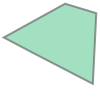

In [78]:
# Store the extent as a Shapely Polygon in a variable called graph_extent:
graph_extent_latlong = rt_bounds_latlong.buffer(0.1, join_style=2)
print(type(graph_extent_latlong))
graph_extent_latlong

### Food Within Extent
Groceries and prepared food establishments within this study were found using `OSMnx` and the appropriate OSM tags. 
- Groceries were defined as shops where one can purchase ingredients or products to prepare one's own meals. 
- Prepared food was defined as establishments where one can purchase already-prepared food to consume, e.g. restaurants, cafes, fast food restaurants. 
- Specialty shops, such as coffee, ice cream, or alcohol shops, were excluded from these categories. 

Farmers markets were obtained from MassGIS.

#### Groceries

In [79]:
# Retrieve groceries features within graph_extent_latlong from OSMnx and view info.
grocery_tags = {'shop':['supermarket', 'grocery', 'greengrocer', 'bakery', 'butcher', 'deli', 'dairy', 'farm', 'seafood']}
grocery = ox.geometries_from_polygon(graph_extent_latlong, grocery_tags)
grocery = convert_n_clip(grocery, rt_zcta)
grocery.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 221 entries, 0 to 330
Columns: 112 entries, unique_id to type
dtypes: geometry(1), int64(1), object(110)
memory usage: 195.1+ KB


In [80]:
# View first five rows of groceries GDF.
grocery.head()

unique_id      osmid element_type        brand brand:wikidata  \
0  node/314092543  314092543         node  Stop & Shop       Q3658429   
1  node/355795164  355795164         node          NaN            NaN   
3  node/431377975  431377975         node          NaN            NaN   
4  node/460001186  460001186         node          NaN            NaN   
5  node/460211013  460211013         node          NaN            NaN   

  brand:wikipedia                            name  \
0  en:Stop & Shop                     Stop & Shop   
1             NaN  La Ronga Bakery & Delicatessen   
3             NaN             Quebrada Baking Co.   
4             NaN                     Star Market   
5             NaN                     Star Market   

                                  note         shop  \
0  store new since 2006 aerial imagery  supermarket   
1                                  NaN       bakery   
3                                  NaN       bakery   
4                                  NaN  supermarket   
5                                  NaN  supermarket   

                        geometry  ... alt_name:ko name:zh-Hans name:zh-Hant  \
0  POINT (235831.905 897407.979)  ...         NaN          NaN          NaN   
1  POINT (232151.416 903802.162)  ...         NaN          NaN          NaN   
3  POINT (229412.784 906211.019)  ...         NaN          NaN          NaN   
4  POINT (231430.529 904430.448)  ...         NaN          NaN          NaN   
5  POINT (228901.367 902823.634)  ...         NaN          NaN          NaN   

  building:colour building:min_level roof:colour short_name landuse ways type  
0             NaN                NaN         NaN        NaN     NaN  NaN  NaN  
1             NaN                NaN         NaN        NaN     NaN  NaN  NaN  
3             NaN                NaN         NaN        NaN     NaN  NaN  NaN  
4             NaN                NaN         NaN        NaN     NaN  NaN  NaN  
5             NaN                NaN         NaN        NaN     NaN  NaN  NaN  

[5 rows x 112 columns]

In [81]:
# Use count_records on groceries GDF.
zcta_grocery_count = count_records(grocery, rt_zcta, 'ZCTA5CE00', 'grocery_count')
zcta_grocery_count

ZCTA5CE00  grocery_count
0      02138             14
1      02143             11
2      02169              9
3      02130              9
4      02139              8
5      02134              8
6      02446              8
7      02472              8
8      02144              7
9      02128              7
10     02148              7
11     02155              7
12     02149              6
13     02115              6
14     02140              6
15     02215              6
16     02478              5
17     02145              5
18     02114              4
19     02113              4
20     02116              4
21     02127              4
22     02474              4
23     02136              3
24     02170              3
25     02118              3
26     02108              3
27     02141              3
28     02184              3
29     02111              3
30     02135              3
31     02465              2
32     02210              2
33     02150              2
34     02186              2
35     02467              2
36     02460              2
37     02445              2
38     02125              2
39     02151              2
40     02132              2
41     02464              2
42     02222              2
43     02122              1
44     02119              1
45     02126              1
46     02466              1
47     02131              1
48     02109              1
49     02110              1
50     02459              1
51     02124              1
52     02142              1
53     02199              1
54     02129              1
55     02121              1
56     02120              1

#### Prepared food

In [82]:
# Retrieve prepared food features within graph_extent_latlong from OSMnx and view info.
prep_food_tags = {'amenity':['cafe', 'restaurant', 'fast_food']}
prep_food = ox.geometries_from_polygon(graph_extent_latlong, prep_food_tags)
prep_food = convert_n_clip(prep_food, rt_zcta)
prep_food.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 2039 entries, 0 to 2778
Columns: 185 entries, unique_id to type
dtypes: geometry(1), int64(1), object(183)
memory usage: 2.9+ MB


In [83]:
# View first five rows of prepared food GDF.
prep_food.head()

unique_id      osmid element_type     amenity  cuisine  \
0  node/325419354  325419354         node  restaurant  chinese   
1  node/326391966  326391966         node  restaurant      NaN   
2  node/329705548  329705548         node   fast_food    pizza   
3  node/345423108  345423108         node  restaurant    pizza   
4  node/345423146  345423146         node   fast_food      NaN   

               name name:zh                       geometry addr:housenumber  \
0           Dar Hee      達熙  POINT (237094.772 907512.932)              NaN   
1     Tawakal Halal     NaN  POINT (238793.752 901798.067)              389   
2       Big Daddy's     NaN  POINT (229587.646 901377.423)              NaN   
3  Romanza Pizzaria     NaN  POINT (233987.726 904915.453)              NaN   
4    Dunkin' Donuts     NaN  POINT (232394.959 903738.778)              519   

       opening_hours  ... restaurant roof:material disused:building  \
0                NaN  ...        NaN           NaN              NaN   
1                NaN  ...        NaN           NaN              NaN   
2  Mo-Su 11:00-22:00  ...        NaN           NaN              NaN   
3                NaN  ...        NaN           NaN              NaN   
4                NaN  ...        NaN           NaN              NaN   

  former:building phone:alternate highway oneway service ways type  
0             NaN             NaN     NaN    NaN     NaN  NaN  NaN  
1             NaN             NaN     NaN    NaN     NaN  NaN  NaN  
2             NaN             NaN     NaN    NaN     NaN  NaN  NaN  
3             NaN             NaN     NaN    NaN     NaN  NaN  NaN  
4             NaN             NaN     NaN    NaN     NaN  NaN  NaN  

[5 rows x 185 columns]

In [84]:
# Use count_records on prepared food GDF.
zcta_prep_food_count = count_records(prep_food, rt_zcta, 'ZCTA5CE00', 'prep_food_count')
zcta_prep_food_count

ZCTA5CE00  prep_food_count
0      02116              136
1      02138              112
2      02139              112
3      02128              108
4      02215               95
5      02115               81
6      02148               75
7      02143               64
8      02446               63
9      02111               61
10     02134               59
11     02144               58
12     02210               56
13     02108               55
14     02114               52
15     02130               44
16     02135               43
17     02113               43
18     02110               41
19     02155               40
20     02184               39
21     02474               38
22     02109               35
23     02142               35
24     02169               33
25     02127               32
26     02472               30
27     02149               30
28     02140               29
29     02145               29
30     02150               28
31     02118               25
32     02478               22
33     02199               21
34     02141               20
35     02445               20
36     02129               16
37     02151               16
38     02120               13
39     02459               12
40     02171               10
41     02125               10
42     02467               10
43     02119                9
44     02124                8
45     02122                8
46     02222                7
47     02465                7
48     02136                7
49     02464                6
50     02461                6
51     02466                6
52     02132                5
53     02170                5
54     02121                4
55     02458                3
56     02460                2
57     02126                2
58     02131                1
59     02468                1

#### Farmers Markets

In [85]:
# read_n_clip farmers markets shapefile from MassGIS and view info.
farmer_mrkt = read_n_clip('./data/farmersmarkets/FARMERSMARKETS_PT.shp', rt_zcta)
farmer_mrkt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 58 entries, 2 to 296
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   MARKET_ID   58 non-null     float64 
 1   NAME        58 non-null     object  
 2   TYPE        58 non-null     object  
 3   ADDR_1      58 non-null     object  
 4   ADDR_2      55 non-null     object  
 5   TOWN        58 non-null     object  
 6   ZIP_CODE    58 non-null     object  
 7   DAY_TIME    58 non-null     object  
 8   DATES       58 non-null     object  
 9   UPDATE_DAT  58 non-null     object  
 10  YEAR_START  57 non-null     object  
 11  WEBSITE     43 non-null     object  
 12  EBT         48 non-null     object  
 13  WIC_CVV     0 non-null      object  
 14  COUPONS     50 non-null     object  
 15  LONGITUDE   58 non-null     float64 
 16  LATITUDE    58 non-null     float64 
 17  geometry    58 non-null     geometry
dtypes: float64(3), geometry(1), object(14)
memo

In [86]:
# View first five rows of farmer_mrkt.
farmer_mrkt.head()

MARKET_ID                         NAME             TYPE  \
2       535.0                  West Newton  Farmers Markets   
15      153.0                      Everett  Farmers Markets   
16      154.0                  East Boston  Farmers Markets   
17      160.0                    Braintree  Farmers Markets   
21      167.0  Dorchester/Dorchester House  Farmers Markets   

                           ADDR_1  \
2                      Elm Street   
15                 Everett Square   
16              209 Sumner Street   
17  1 John F Kennedy Memorial Dr.   
21            1353 Dorchester Ave   

                                          ADDR_2         TOWN ZIP_CODE  \
2                          off Washington Street  West Newton    02465   
15     Municipal Parking Lot next to Braza Grill      Everett    02149   
16  Lewis Mall across from Maverick MBTA Station       Boston    02128   
17                                Town Hall Mall    Braintree    02184   
21                              Dorchester House   Dorchester    02122   

                        DAY_TIME  \
2   Saturday, 10:00 am - 2:00 pm   
15  Wednesday, 1:30 pm - 6:30 pm   
16  Wednesday, 3:00 pm - 6:30 pm   
17   Saturday, 9:00 am - 1:00 pm   
21   Tuesday, 11:30 am - 2:00 pm   

                                            DATES UPDATE_DAT YEAR_START  \
2                            June 18 to October 8       2016       2014   
15                                June to October       2016       2009   
16                           July 6 to October 19       2016       2008   
17  June 18 to October 22, (Holiday Market 11/19)       2016       2009   
21                           July 5 to October 11       2016       2007   

                                              WEBSITE                EBT  \
2                   http://www.newtonma.gov/gov/parks  EBT-SNAP Accepted   
15     http://www.everettfarmersmarket.worldpress.com  EBT-SNAP Accepted   
16             http://www.ebnhc.org/farmersmarket.php  EBT-SNAP Accepted   
17              http://www.braintreefarmersmarket.com  EBT-SNAP Accepted   
21  http://www.dorchesterhouse.org/services/farmer...  EBT-SNAP Accepted   

   WIC_CVV                        COUPONS  LONGITUDE  LATITUDE  \
2     None  WIC & Senior Coupons Accepted  -71.22932  42.34906   
15    None  WIC & Senior Coupons Accepted  -71.05493  42.40779   
16    None  WIC & Senior Coupons Accepted  -71.03940  42.36899   
17    None  WIC & Senior Coupons Accepted  -71.00496  42.20580   
21    None  WIC & Senior Coupons Accepted  -71.05912  42.30453   

                         geometry  
2   POINT (222302.311 899875.783)  
15  POINT (236636.795 906459.547)  
16  POINT (237938.437 902156.590)  
17  POINT (240880.342 884046.442)  
21  POINT (236351.175 894988.130)

In [87]:
# Use count_records on farmer_mrkt.
zcta_farmer_mrkt_count = count_records(farmer_mrkt, rt_zcta, 'ZCTA5CE00', 'farmer_mrkt_count')
zcta_farmer_mrkt_count

ZCTA5CE00  farmer_mrkt_count
0      02124                  5
1      02130                  4
2      02139                  3
3      02118                  3
4      02108                  3
5      02122                  2
6      02131                  2
7      02138                  2
8      02134                  2
9      02143                  2
10     02142                  2
11     02446                  2
12     02115                  1
13     02116                  1
14     02474                  1
15     02144                  1
16     02127                  1
17     02119                  1
18     02478                  1
19     02215                  1
20     02210                  1
21     02129                  1
22     02132                  1
23     02125                  1
24     02170                  1
25     02135                  1
26     02459                  1
27     02151                  1
28     02472                  1
29     02465                  1
30     02149                  1
31     02186                  1
32     02145                  1
33     02128                  1
34     02155                  1
35     02120                  1
36     02126                  1
37     02184                  1

#### Define Function `calc_density`
This function was created to automate density calculations based on counts of records in a dataset (e.g. number of food establishments per square kilometer in each ZCTA).

The purpose of this function is to calculate the density of a set of records in a GeoDataFrame of polygons. It takes a base GeoDataFrame and, using function `multimerge`, merges it with a list of GeoDataFrames on the specified column or columns in the list of `on` columns and with the specified `how`. The GDFs within the list are expected to have columns with counts, and those columns are given in a list. The function then adds together the counts in specified columns and calculates the density.

In [88]:
def calc_density(orig_gdf, gdf_count_list, on_col, how, count_cols, total_count_col, density_col):
    """
    The purpose of this function is to calculate the density of a set of records
    in a GeoDataFrame of polygons.
    Takes a base GeoDataFrame and, using function multimerge, merges it with a list of GDFs 
    on the specified column or list of columns and with the specified 'how'.
    The GDFs within the list are expected to have columns with counts.
    Adds together the counts in specified columns, then calculates the density.
    Assumes on_col exists across all DFs.
    Assumes units of the GDF are in meters, with density output of per sqkm.
    Requires Pandas to run merge method (within multimerge) and fillna().
    
    Inputs:
        orig_gdf = base GDF
        gdf_count_list = list of GDFs with counts to calculate from
            e.g. [gdf1, gdf2, gdf3]
        on_col = bracketed column name or list of columns (same across GDFs)
            e.g. ['name'], ['name', 'address']
        how = how argument
            e.g. 'left'
        count_cols = bracketed list of column names with counts, order does not matter
            e.g. ['gdf1_count', 'gdf2_count', 'gdf3_count']
        total_count_col = string name for new column with total counts
            e.g. 'total_count'
        density_col = string name for new column with density (per sqkm)
            e.g. 'bike_density'
    
    Example:
    >>> schools = [elem, middle, high]
    >>> on_col = ['town_name', 'state']
    >>> count_cols = ['elem_classrooms', 'middle_classrooms', 'high_classrooms']
    >>> town_schools = multimerge(town, 
                                  schools, 
                                  on_col, 
                                  'left', 
                                  count_cols, 
                                  'total_classrooms', 
                                  'classroom_density')
    """
    
    # Run multimerge on the GDFs.
    density_gdf = multimerge(orig_gdf, gdf_count_list, on_col, how).fillna(0)
    
    # Create new total_count_col with dtype float (fill in with 0.0).
    density_gdf[total_count_col] = 0.0
    
    # Add count columns.
    for i in range(len(count_cols)):
        density_gdf[total_count_col] = density_gdf[total_count_col] + density_gdf[count_cols[i]]
    
    # Calculate density.
    density_gdf[density_col] = density_gdf[total_count_col]/density_gdf.area*(10**6)
    
    return density_gdf

#### Calculate Food Density per ZCTA

In [89]:
# Use calc_density to calculate density of food establishments per ZCTA.
food_gdfs = [zcta_grocery_count, zcta_prep_food_count, zcta_farmer_mrkt_count]
food_cols = ['grocery_count', 'prep_food_count', 'farmer_mrkt_count']
zcta_food = calc_density(rt_zcta, food_gdfs, ['ZCTA5CE00'], 'left', food_cols, 'food_count', 'food_density')

In [90]:
# View five most food-dense ZCTAs.
zcta_food.sort_values(by='food_density', ascending=False).head()

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00  ALAND00  \
55    437        25     02113  2502113        B5   G6350          S   272995   
42    308        25     02199  2502199        B5   G6350          S   149678   
61    495        25     02222  2502222        B5   G6350          S    77896   
48    377        25     02110  2502110        B5   G6350          S   428520   
33    253        25     02109  2502109        B5   G6350          S   427819   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
55         0  +42.3651696  -071.0553627         N   
42         0  +42.3474648  -071.0820577         N   
61         0  +42.3664695  -071.0624939         N   
48         0  +42.3573712  -071.0531804         N   
33         0  +42.3626531  -071.0538044         N   

                                             geometry  grocery_count  \
55  POLYGON ((236403.940 901958.860, 236443.429 90...            4.0   
42  POLYGON ((234168.090 899801.270, 234292.861 89...            1.0   
61  POLYGON ((235839.790 902134.685, 235852.488 90...            2.0   
48  POLYGON ((236791.320 900796.888, 236751.472 90...            1.0   
33  MULTIPOLYGON (((236437.338 900792.044, 236429....            1.0   

    prep_food_count  farmer_mrkt_count  food_count  food_density  
55             43.0                0.0        47.0    172.176956  
42             21.0                0.0        22.0    146.992162  
61              7.0                0.0         9.0    115.575988  
48             41.0                0.0        42.0     99.910762  
33             35.0                0.0        36.0     85.443766

In [91]:
# View stats for food_density
zcta_food.food_density.describe()

count     62.000000
mean      21.372276
std       37.098875
min        0.000000
25%        1.550315
50%        5.130476
75%       20.625985
max      172.176956
Name: food_density, dtype: float64

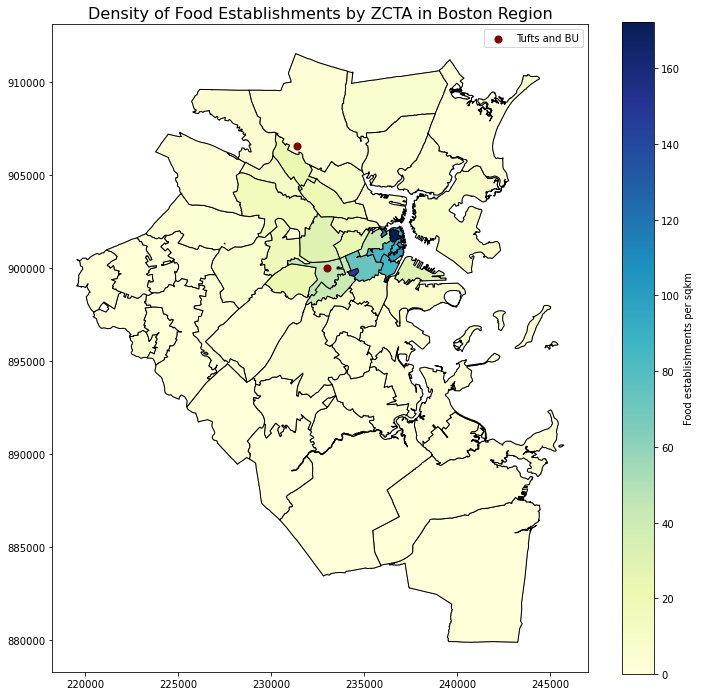

In [92]:
# Map the density of food establishments in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_food.plot(column='food_density',
               legend=True,
               edgecolor='black',
               cmap='YlGnBu',
               legend_kwds={'label': "Food establishments per sqkm"},
               ax=ax)
tufts_bu.plot(ax=ax, color='maroon', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Density of Food Establishments by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

#### Reclassify Food Density

In [93]:
# Calculate values to separate food density into five quantiles.
food_quints = quantiles(zcta_food, 'food_density', quintiles)
food_quints

[1.4331169108386328, 2.3792512364611573, 8.133602216983999, 28.381466858715]

In [94]:
# Reclassify food density with reclass_5 function and quintile values.
zcta_food['food_density_reclass'] = zcta_food['food_density'].apply(lambda x: reclass_5(x, food_quints, 'high'))

In [95]:
# View top and bottom five food dense ZCTAs.
zcta_food.sort_values(by='food_density_reclass', ascending=False)

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
61    495        25     02222  2502222        B5   G6350          S     77896   
17    115        25     02115  2502115        B5   G6350          S   1979415   
18    116        25     02210  2502210        B5   G6350          S   2023105   
48    377        25     02110  2502110        B5   G6350          S    428520   
53    435        25     02116  2502116        B5   G6350          S   1712064   
..    ...       ...       ...      ...       ...     ...        ...       ...   
24    226        25     02468  2502468        B5   G6350          S   4120625   
25    229        25     02460  2502460        B5   G6350          S   3651425   
35    285        25     02459  2502459        B5   G6350          S  12417620   
28    248        25     02136  2502136        B5   G6350          S  11889865   
0      31        25     02458  2502458        B5   G6350          S   4709183   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
61         0  +42.3664695  -071.0624939         N   
17    162098  +42.3375449  -071.1061732         N   
18         0  +42.3476816  -071.0417309         N   
48         0  +42.3573712  -071.0531804         N   
53    222385  +42.3499907  -071.0760802         N   
..       ...          ...           ...       ...   
24     57832  +42.3291748  -071.2315831         N   
25     20856  +42.3520061  -071.2092424         N   
35    237715  +42.3142917  -071.1946111         N   
28    266448  +42.2550833  -071.1292203         N   
0      57045  +42.3541154  -071.1891300         N   

                                             geometry  grocery_count  \
61  POLYGON ((235839.790 902134.685, 235852.488 90...            2.0   
17  POLYGON ((233785.591 900215.963, 233773.509 90...            6.0   
18  MULTIPOLYGON (((236771.808 900243.394, 236722....            2.0   
48  POLYGON ((236791.320 900796.888, 236751.472 90...            1.0   
53  POLYGON ((234702.966 899809.334, 234675.900 89...            4.0   
..                                                ...            ...   
24  POLYGON ((220628.408 897708.340, 220639.271 89...            0.0   
25  POLYGON ((224712.729 900305.384, 224780.933 90...            2.0   
35  MULTIPOLYGON (((226381.301 895402.075, 226417....            1.0   
28  POLYGON ((232000.362 889791.619, 232054.679 88...            3.0   
0   MULTIPOLYGON (((227500.026 901300.219, 227482....            0.0   

    prep_food_count  farmer_mrkt_count  food_count  food_density  \
61              7.0                0.0         9.0    115.575988   
17             81.0                1.0        88.0     41.095138   
18             56.0                1.0        59.0     29.608405   
48             41.0                0.0        42.0     99.910762   
53            136.0                1.0       141.0     72.893469   
..              ...                ...         ...           ...   
24              1.0                0.0         1.0      0.239338   
25              2.0                0.0         4.0      1.089313   
35             12.0                1.0        14.0      1.106327   
28              7.0                0.0        10.0      0.825368   
0               3.0                0.0         3.0      0.629469   

    food_density_reclass  
61                     5  
17                     5  
18                     5  
48                     5  
53                     5  
..                   ...  
24                     1  
25                     1  
35                     1  
28                     1  
0                      1  

[62 rows x 19 columns]

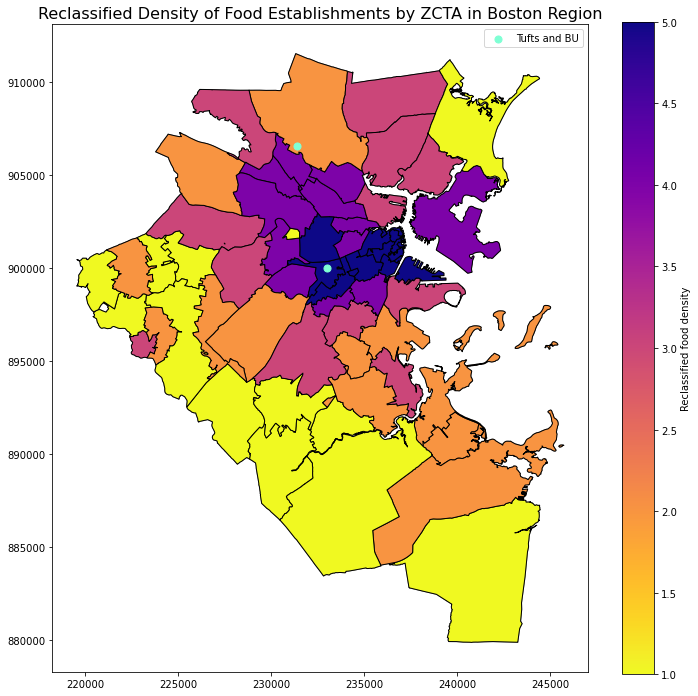

In [96]:
# Map the reclassified food density in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_food.plot(column='food_density_reclass',
               legend=True,
               edgecolor='black',
               cmap='plasma_r',
               legend_kwds={'label': "Reclassified food density"},
               ax=ax)
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Reclassified Density of Food Establishments by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

### Health Services Within Extent
Health services were defined as Community Health Centers and Hospitals from MassGIS and found with the appropriate OSM tags for healthcare and amenities, such as clinics and doctors offices. Social services facilities and veterinary servies were omitted.

#### Community Health Centers

In [97]:
# read_n_clip Community Health Centers shapefile from MassGIS and view info.
comm_health = read_n_clip('./data/chcs/CHCS_PT.shp', rt_zcta)
comm_health.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 84 entries, 1 to 194
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SITE_NAME   84 non-null     object  
 1   SITE_TYPE   84 non-null     object  
 2   ADMIN_ONLY  84 non-null     object  
 3   ADDRESS     84 non-null     object  
 4   ADDRESS_OT  16 non-null     object  
 5   MAIL_CITY   84 non-null     object  
 6   ZIP         84 non-null     object  
 7   PO_BOX      0 non-null      object  
 8   TOWN        84 non-null     object  
 9   TOWN_ID     84 non-null     int64   
 10  SATELLITE   84 non-null     object  
 11  EYE         84 non-null     object  
 12  DENTAL      84 non-null     object  
 13  METHOD      84 non-null     object  
 14  GIS_ID      71 non-null     object  
 15  MCHC_CODE   84 non-null     object  
 16  MAD_ID      84 non-null     int64   
 17  geometry    84 non-null     geometry
dtypes: geometry(1), int64(2), object(15)
memory

In [98]:
# View first five rows of comm_health.
comm_health.head()

SITE_NAME SITE_TYPE ADMIN_ONLY  \
1                                    Chinatown Clinic       NOS          N   
3                            St. Francis House Clinic  HOMELESS          N   
8   Teen Health Center at Cambridge Rindge and Lat...    SCHOOL          N   
9                                      The Great Hall       NOS          N   
11             Upham's Corner Adolescent Health & WIC       NOS          N   

                  ADDRESS ADDRESS_OT   MAIL_CITY    ZIP PO_BOX       TOWN  \
1   885 Washington Street       None      Boston  02111   None     BOSTON   
3      39 Boylston Street       None      Boston  02116   None     BOSTON   
8            459 Broadway       None   Cambridge  02138   None  CAMBRIDGE   
9        6 Norfolk Street       None  Dorchester  02124   None     BOSTON   
11      500 Columbia Road       None  Dorchester  02125   None     BOSTON   

    TOWN_ID SATELLITE EYE DENTAL METHOD GIS_ID MCHC_CODE    MAD_ID  \
1        35         Y   N      N      G    S99     SCCHC  35145770   
3        35         Y   N      N      G   S101     BHCHP  35018316   
8        49         Y   N      N      G   S106       CHA   3624789   
9        35         Y   N      N      G   S107      CSHC  35103391   
11       35         Y   N      N      G   S111      UCHC  35035283   

                         geometry  
1   POINT (235848.295 899811.714)  
3   POINT (235955.316 900313.222)  
8   POINT (231966.092 902732.932)  
9   POINT (235304.694 893366.484)  
11  POINT (235647.822 896122.920)

In [99]:
# Use count_records on comm_health.
zcta_comm_health_count = count_records(comm_health, rt_zcta, 'ZCTA5CE00', 'comm_health_count')
zcta_comm_health_count

ZCTA5CE00  comm_health_count
0      02125                  7
1      02139                  7
2      02111                  5
3      02149                  5
4      02151                  5
5      02118                  4
6      02124                  4
7      02129                  3
8      02150                  3
9      02130                  3
10     02126                  3
11     02143                  3
12     02171                  3
13     02134                  2
14     02215                  2
15     02127                  2
16     02169                  2
17     02135                  2
18     02113                  2
19     02145                  2
20     02122                  2
21     02148                  1
22     02131                  1
23     02119                  1
24     02114                  1
25     02210                  1
26     02140                  1
27     02128                  1
28     02121                  1
29     02138                  1
30     02186                  1
31     02116                  1
32     02120                  1
33     02141                  1

#### Hospitals

In [100]:
# read_n_clip Hospitals shapefile from MassGIS and view info.
hospitals = read_n_clip('./data/acute_care_hospitals/HOSPITALS_PT.shp', rt_zcta)
hospitals.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 20 entries, 0 to 68
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   IDNUMBER    20 non-null     object  
 1   DPHID       20 non-null     int64   
 2   NAME        20 non-null     object  
 3   SHORTNAME   20 non-null     object  
 4   ADDRESS     20 non-null     object  
 5   TOWN        20 non-null     object  
 6   GEOG_TOWN   20 non-null     object  
 7   ZIPCODE     20 non-null     object  
 8   CHIAREGION  20 non-null     object  
 9   TELEPHONE   20 non-null     object  
 10  COHORT      20 non-null     object  
 11  HOSPSYSTEM  20 non-null     object  
 12  TAXSTATUS   20 non-null     object  
 13  BEDCOUNT    20 non-null     int64   
 14  ER_STATUS   20 non-null     object  
 15  TRAUMA_ADU  5 non-null      object  
 16  TRAUMA_PED  4 non-null      object  
 17  SPEPUBFUND  18 non-null     object  
 18  FYE         16 non-null     object  
 19  MA

In [101]:
# View first five rows of hospitals.
hospitals.head()

IDNUMBER  DPHID                                       NAME  \
0     2069   2069  Beth Israel Deaconess Medical Center East   
1     2085   2085     Steward St. Elizabeth's Medical Center   
2     2299   2299                       Tufts Medical Center   
4     2167   2167        Massachusetts Eye and Ear Infirmary   
5     2316   2316    Shriners Hospital For Children - Boston   

                             SHORTNAME                ADDRESS      TOWN  \
0                           BIDMC East   330 Brookline Avenue    Boston   
1       St. Elizabeth's Medical Center   736 Cambridge Street  Brighton   
2                 Tufts Medical Center  800 Washington Street    Boston   
4  Massachusetts Eye and Ear Infirmary     243 Charles Street    Boston   
5                      Shriners Boston      51 Blossom Street    Boston   

  GEOG_TOWN ZIPCODE    CHIAREGION       TELEPHONE  ...   TAXSTATUS BEDCOUNT  \
0    BOSTON   02215  Metro Boston  (617) 667-7000  ...  Non-profit      248   
1    BOSTON   02135  Metro Boston  (617) 789-3000  ...  For profit      252   
2    BOSTON   02111  Metro Boston  (617) 636-5000  ...  Non-profit      415   
4    BOSTON   02114  Metro Boston  (617) 523-7900  ...  Non-profit       41   
5    BOSTON   02114  Metro Boston  (617) 722-3000  ...  Non-profit       30   

  ER_STATUS  TRAUMA_ADU TRAUMA_PED      SPEPUBFUND         FYE     MADID  \
0         N        None       None  Not Applicable  2017-09-30  35022096   
1         Y        None       None  Not Applicable  2017-12-31  35156980   
2         Y     Level 1    Level 1  Not Applicable  2017-09-30  35145764   
4         Y        None       None  Not Applicable  2017-09-30  35163139   
5         N        None       None  Not Applicable  2017-12-31  35016066   

  EMSREGION                       geometry  
0         4  POINT (232494.091 898890.122)  
1         4  POINT (229003.958 899958.291)  
2         4  POINT (235963.109 899998.149)  
4         4  POINT (235396.614 901452.905)  
5         4  POINT (235713.701 901489.419)  

[5 rows x 22 columns]

In [102]:
# Use count_records on hospitals.
zcta_hospitals_count = count_records(hospitals, rt_zcta, 'ZCTA5CE00', 'hospitals_count')
zcta_hospitals_count

ZCTA5CE00  hospitals_count
0      02114                3
1      02115                3
2      02215                2
3      02118                2
4      02120                1
5      02130                1
6      02124                1
7      02149                1
8      02155                1
9      02111                1
10     02186                1
11     02139                1
12     02138                1
13     02135                1

#### Healthcare

In [103]:
# Retrieve healthcare features within graph_extent_latlong from OSMnx and view info.
health_tags = {'healthcare':True, 'amenity':['clinic', 'doctors', 'dentist', 'health_post', 'pharmacy']}
healthcare = ox.geometries_from_polygon(graph_extent_latlong, health_tags)
healthcare = convert_n_clip(healthcare, rt_zcta)
healthcare.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 306 entries, 0 to 457
Columns: 104 entries, unique_id to type
dtypes: geometry(1), int64(1), object(102)
memory usage: 251.0+ KB


In [104]:
# View first five rows of healthcare GDF.
healthcare.head()

unique_id      osmid element_type  \
0   node/61348061   61348061         node   
1  node/257489648  257489648         node   
2  node/358278209  358278209         node   
3  node/367777794  367777794         node   
5  node/391429098  391429098         node   

                                         attribution  \
0  Office of Geographic and Environmental Informa...   
1                                                NaN   
2                                                NaN   
3                                                NaN   
5                                                NaN   

                               source                       geometry  \
0  massgis_import_v0.1_20071008193615  POINT (228225.230 899815.766)   
1                                 NaN  POINT (235923.447 900015.140)   
2                                 NaN  POINT (233490.267 891124.319)   
3                       USGS Geonames  POINT (232386.086 898796.067)   
5                                 NaN  POINT (228374.893 904620.489)   

  addr:city addr:housenumber addr:state        addr:street  ...  \
0  Brighton              438         MA  Washington Street  ...   
1    Boston              755        NaN  Washington Street  ...   
2  Mattapan             1575        NaN   Blue Hill Avenue  ...   
3       NaN              NaN         MA                NaN  ...   
5       NaN              NaN        NaN                NaN  ...   

  disused:amenity old_name internet_access beds height access ways  \
0             NaN      NaN             NaN  NaN    NaN    NaN  NaN   
1             NaN      NaN             NaN  NaN    NaN    NaN  NaN   
2             NaN      NaN             NaN  NaN    NaN    NaN  NaN   
3             NaN      NaN             NaN  NaN    NaN    NaN  NaN   
5             NaN      NaN             NaN  NaN    NaN    NaN  NaN   

  building:material roof:material type  
0               NaN           NaN  NaN  
1               NaN           NaN  NaN  
2               NaN           NaN  NaN  
3               NaN           NaN  NaN  
5               NaN           NaN  NaN  

[5 rows x 104 columns]

In [105]:
# Use count_records on healthcare.
zcta_healthcare_count = count_records(healthcare, rt_zcta, 'ZCTA5CE00', 'healthcare_count')
zcta_healthcare_count

ZCTA5CE00  healthcare_count
0      02116                35
1      02130                19
2      02115                18
3      02135                13
4      02138                12
5      02143                12
6      02139                12
7      02215                11
8      02155                10
9      02114                 9
10     02140                 8
11     02148                 7
12     02145                 7
13     02144                 7
14     02128                 7
15     02445                 7
16     02446                 7
17     02141                 6
18     02169                 6
19     02184                 6
20     02474                 6
21     02134                 5
22     02119                 5
23     02132                 5
24     02478                 4
25     02111                 4
26     02118                 4
27     02120                 4
28     02124                 4
29     02136                 3
30     02150                 3
31     02108                 3
32     02126                 3
33     02459                 3
34     02142                 3
35     02129                 3
36     02472                 3
37     02461                 2
38     02127                 2
39     02466                 2
40     02109                 2
41     02171                 2
42     02149                 2
43     02113                 2
44     02210                 1
45     02199                 1
46     02121                 1
47     02151                 1
48     02465                 1

#### Calculate Health Services Density per ZCTA

In [106]:
# Use calc_density to calculate density of health services per ZCTA.
health_gdfs = [zcta_comm_health_count, zcta_hospitals_count, zcta_healthcare_count]
health_cols = ['comm_health_count', 'hospitals_count', 'healthcare_count']
zcta_health = calc_density(rt_zcta, health_gdfs, ['ZCTA5CE00'], 'left', health_cols, 'health_count', 'health_density')

In [107]:
# View five most food-dense ZCTAs.
zcta_health.sort_values(by='health_density', ascending=False).head()

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00  ALAND00  \
53    435        25     02116  2502116        B5   G6350          S  1712064   
55    437        25     02113  2502113        B5   G6350          S   272995   
59    493        25     02111  2502111        B5   G6350          S   754214   
17    115        25     02115  2502115        B5   G6350          S  1979415   
50    379        25     02114  2502114        B5   G6350          S  1065352   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
53    222385  +42.3499907  -071.0760802         N   
55         0  +42.3651696  -071.0553627         N   
59     79209  +42.3487843  -071.0589880         N   
17    162098  +42.3375449  -071.1061732         N   
50    343761  +42.3631745  -071.0686463         N   

                                             geometry  comm_health_count  \
53  POLYGON ((234702.966 899809.334, 234675.900 89...                1.0   
55  POLYGON ((236403.940 901958.860, 236443.429 90...                2.0   
59  POLYGON ((236144.915 900687.565, 236153.840 90...                5.0   
17  POLYGON ((233785.591 900215.963, 233773.509 90...                0.0   
50  MULTIPOLYGON (((234691.735 900849.190, 234663....                1.0   

    hospitals_count  healthcare_count  health_count  health_density  
53              0.0              35.0          36.0       18.611098  
55              0.0               2.0           4.0       14.653358  
59              1.0               4.0          10.0       13.180128  
17              3.0              18.0          21.0        9.806794  
50              3.0               9.0          13.0        9.662174

In [108]:
# View stats for health_density
zcta_health.health_density.describe()

count    62.000000
mean      2.362879
std       3.733892
min       0.000000
25%       0.278843
50%       0.828034
75%       2.455580
max      18.611098
Name: health_density, dtype: float64

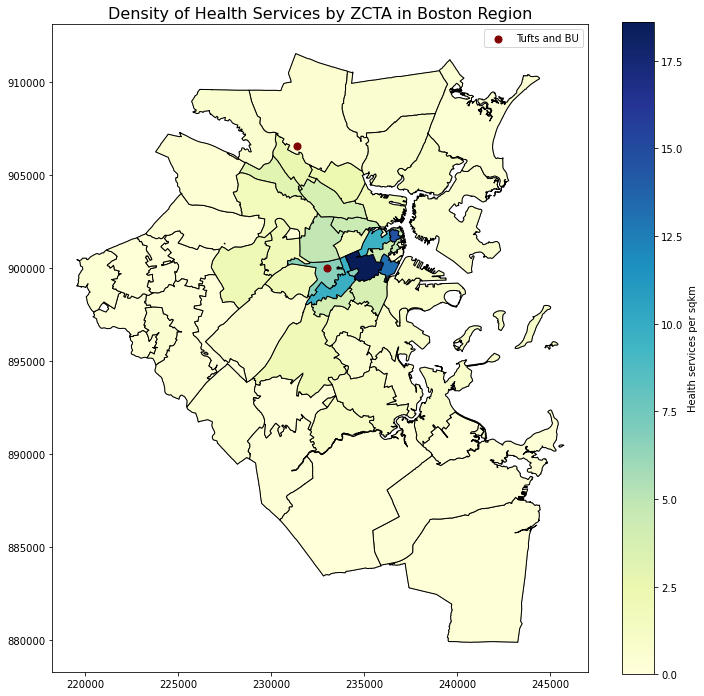

In [109]:
# Map the density of health services in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_health.plot(column='health_density',
                 legend=True,
                 edgecolor='black',
                 cmap='YlGnBu',
                 legend_kwds={'label': "Health services per sqkm"},
                 ax=ax)
tufts_bu.plot(ax=ax, color='maroon', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Density of Health Services by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

#### Reclassify Health Services Density

In [110]:
# Calculate values to separate health density into five quantiles.
health_quints = quantiles(zcta_health, 'health_density', quintiles)
health_quints

[0.1986800423319442,
 0.6037528931486905,
 1.3204051899721023,
 3.7225941851306605]

In [111]:
# Reclassify health density with reclass_5 function and quintile values.
zcta_health['health_density_reclass'] = zcta_health['health_density'].apply(lambda x: reclass_5(x, health_quints, 'high'))

In [112]:
# View top and bottom five health-service-dense ZCTAs.
zcta_health.sort_values(by='health_density_reclass', ascending=False)

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
55    437        25     02113  2502113        B5   G6350          S    272995   
57    482        25     02139  2502139        B5   G6350          S   3784723   
56    438        25     02108  2502108        B5   G6350          S    721093   
59    493        25     02111  2502111        B5   G6350          S    754214   
50    379        25     02114  2502114        B5   G6350          S   1065352   
..    ...       ...       ...      ...       ...     ...        ...       ...   
22    176        25     02163  2502163        B5   G6350          S    316665   
21    171        25     02184  2502184        B5   G6350          S  35903196   
15    103        25     02170  2502170        B5   G6350          S   5031241   
4      39        25     02464  2502464        B5   G6350          S   1447706   
61    495        25     02222  2502222        B5   G6350          S     77896   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
55         0  +42.3651696  -071.0553627         N   
57    368360  +42.3622881  -071.1037905         N   
56         0  +42.3575539  -071.0639133         N   
59     79209  +42.3487843  -071.0589880         N   
50    343761  +42.3631745  -071.0686463         N   
..       ...          ...           ...       ...   
22     32165  +42.3661684  -071.1228503         N   
21   2081541  +42.2054158  -071.0021680         N   
15     25238  +42.2654801  -071.0171436         N   
4      29494  +42.3129751  -071.2188818         N   
61         0  +42.3664695  -071.0624939         N   

                                             geometry  comm_health_count  \
55  POLYGON ((236403.940 901958.860, 236443.429 90...                2.0   
57  POLYGON ((232130.866 902283.249, 232144.254 90...                7.0   
56  POLYGON ((235436.185 900908.999, 235400.476 90...                0.0   
59  POLYGON ((236144.915 900687.565, 236153.840 90...                5.0   
50  MULTIPOLYGON (((234691.735 900849.190, 234663....                1.0   
..                                                ...                ...   
22  POLYGON ((231019.106 902090.531, 231035.630 90...                0.0   
21  MULTIPOLYGON (((237408.847 882805.326, 237292....                0.0   
15  MULTIPOLYGON (((238632.563 889957.081, 238619....                0.0   
4   POLYGON ((223497.366 896100.959, 223538.895 89...                0.0   
61  POLYGON ((235839.790 902134.685, 235852.488 90...                0.0   

    hospitals_count  healthcare_count  health_count  health_density  \
55              0.0               2.0           4.0       14.653358   
57              1.0              12.0          20.0        4.816014   
56              0.0               3.0           3.0        4.160645   
59              1.0               4.0          10.0       13.180128   
50              3.0               9.0          13.0        9.662174   
..              ...               ...           ...             ...   
22              0.0               0.0           0.0        0.000000   
21              0.0               6.0           6.0        0.159571   
15              0.0               0.0           0.0        0.000000   
4               0.0               0.0           0.0        0.000000   
61              0.0               0.0           0.0        0.000000   

    health_density_reclass  
55                       5  
57                       5  
56                       5  
59                       5  
50                       5  
..                     ...  
22                       1  
21                       1  
15                       1  
4                        1  
61                       1  

[62 rows x 19 columns]

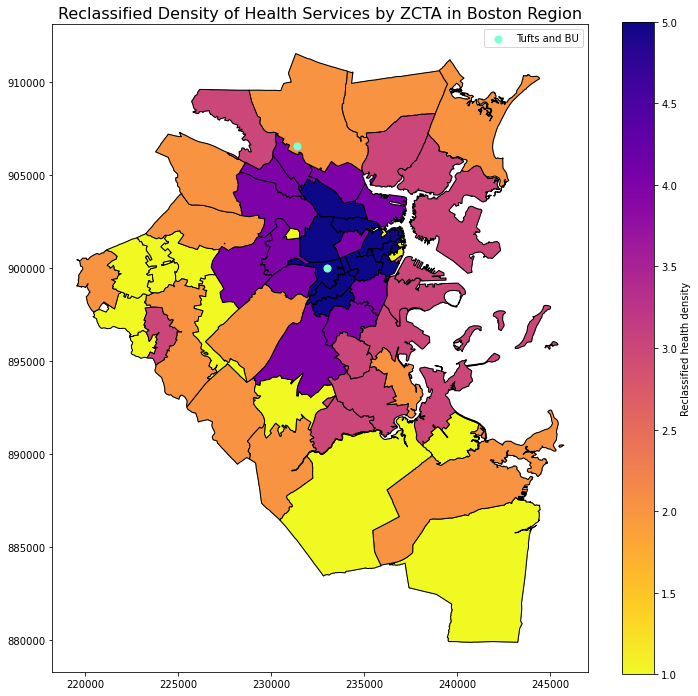

In [113]:
# Map the average rent price in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_health.plot(column='health_density_reclass',
                 legend=True,
                 edgecolor='black',
                 cmap='plasma_r',
                 legend_kwds={'label': "Reclassified health density"},
                 ax=ax)
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Reclassified Density of Health Services by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

### Public Services Within Extent
Public services were defined in terms of safety (fire and police) and availability of public resources (USPS Post Offices and libraries). Fire stations and police stations were obtained from MassGIS. USPS data was obtained from [USPS](https://uspstools.maps.arcgis.com/apps/webappviewer/index.html?id=1fc1c26bb31246b39087606c65b83020) as a CSV of Destination Delivery Units (DDUs) in a specified map extent. Libraries were found using OSM.

#### Fire Stations

In [114]:
# read_n_clip firestations shapefile from MassGIS and view info.
fire = read_n_clip('./data/firestations_pt/FIRESTATIONS_PT_MEMA.shp', rt_zcta)
fire.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 103 entries, 5 to 710
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME      103 non-null    object  
 1   OFFICE    103 non-null    object  
 2   ADDRESS   103 non-null    object  
 3   CITY      103 non-null    object  
 4   STATE     103 non-null    object  
 5   ZIP       103 non-null    object  
 6   L_SRC     103 non-null    object  
 7   SOURCE    103 non-null    object  
 8   L_DATE    103 non-null    object  
 9   geometry  103 non-null    geometry
dtypes: geometry(1), object(9)
memory usage: 8.9+ KB


In [115]:
# View first five rows of fire GDF.
fire.head()

NAME                   OFFICE              ADDRESS  \
5   MILTON FIRE DEPARTMENT                 DEPT E 4   815 Blue Hill Ave.   
6   MILTON FIRE DEPARTMENT  Station 1- Headquarters    515 Canton Avenue   
7   MILTON FIRE DEPARTMENT              Station E 2     525 Adams Street   
38  REVERE FIRE DEPARTMENT                 Engine 1     13 Walden Street   
39  REVERE FIRE DEPARTMENT                 Engine 3  929 Winthrop Avenue   

      CITY STATE    ZIP L_SRC SOURCE      L_DATE  \
5   MILTON    MA  01286  MAPC   MEMA  2006-08-16   
6   MILTON    MA  02186  MAPC   MEMA  2006-08-16   
7   MILTON    MA  02186  MAPC   MEMA  2006-08-16   
38  REVERE    MA  02151  MAPC   MEMA  2006-08-16   
39  REVERE    MA  02151  MAPC   MEMA  2006-08-16   

                         geometry  
5   POINT (232280.004 887730.431)  
6   POINT (234642.734 889410.311)  
7   POINT (237885.224 889826.071)  
38  POINT (241572.264 906537.411)  
39  POINT (242387.724 904981.381)

In [116]:
# Use count_records on fire.
zcta_fire_count = count_records(fire, rt_zcta, 'ZCTA5CE00', 'fire_count')
zcta_fire_count

ZCTA5CE00  fire_count
0      02155           6
1      02151           5
2      02169           5
3      02445           4
4      02118           3
5      02150           3
6      02124           3
7      02149           3
8      02138           3
9      02143           3
10     02459           3
11     02128           3
12     02472           3
13     02184           3
14     02186           3
15     02148           3
16     02139           3
17     02136           2
18     02111           2
19     02446           2
20     02171           2
21     02132           2
22     02129           2
23     02122           2
24     02135           2
25     02115           2
26     02119           2
27     02127           2
28     02478           2
29     02474           1
30     02116           1
31     02131           1
32     02125           1
33     02144           1
34     02109           1
35     02464           1
36     02114           1
37     02134           1
38     02130           1
39     02145           1
40     02140           1
41     02170           1
42     02121           1
43     02460           1
44     02113           1
45     02141           1
46     02465           1
47     02110           1
48     02458           1

#### Police Stations

In [117]:
# read_n_clip police stations shapefile from MassGIS and view info.
police = read_n_clip('./data/policestations/POLICESTATIONS_PT_MEMA.shp', rt_zcta)
police.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 42 entries, 6 to 412
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   NAME      42 non-null     object  
 1   ADDRESS   42 non-null     object  
 2   CITY      42 non-null     object  
 3   STATE     42 non-null     object  
 4   ZIP       42 non-null     object  
 5   JURISDIC  42 non-null     object  
 6   L_SRC     41 non-null     object  
 7   SOURCE    42 non-null     object  
 8   L_DATE    42 non-null     object  
 9   geometry  42 non-null     geometry
dtypes: geometry(1), object(9)
memory usage: 3.6+ KB


In [118]:
# View first five rows of police GDF.
police.head()

NAME                 ADDRESS  \
6                  STATE POLICE STATION H-7, MILTON     685 HILLSIDE STREET   
42            BOSTON POLICE DEPARTMENT DISTRICT E-5      1708 CENTRE STREET   
43  BOSTON POLICE DEPARTMENT DISTRICTS A-1 AND A-15   40 NEW SUDBURY STREET   
44            BOSTON POLICE DEPARTMENT DISTRICT B-2  2400 WASHINGTON STREET   
45           BOSTON POLICE DEPARTMENT DISTRICT C-11        40 GIBSON STREET   

      CITY STATE    ZIP JURISDIC L_SRC SOURCE      L_DATE  \
6   MILTON    MA  02186    STATE  MAPC   MEMA  2006-09-12   
42  BOSTON    MA  02132    LOCAL  MEMA   CITY  2006-09-12   
43  BOSTON    MA  02114    LOCAL  MEMA   CITY  2006-09-12   
44  BOSTON    MA  02119    LOCAL  MEMA   CITY  2014-03-01   
45  BOSTON    MA  02122    LOCAL  MEMA   CITY  2006-09-12   

                         geometry  
6   POINT (233598.434 885007.271)  
42  POINT (229001.867 892986.812)  
43  POINT (236217.474 901349.051)  
44  POINT (234279.794 897624.521)  
45  POINT (236357.494 894265.901)

In [119]:
# Use count_records on police.
zcta_police_count = count_records(police, rt_zcta, 'ZCTA5CE00', 'police_count')
zcta_police_count

ZCTA5CE00  police_count
0      02155             3
1      02118             3
2      02210             3
3      02151             2
4      02114             2
5      02128             2
6      02186             2
7      02465             2
8      02135             2
9      02108             1
10     02148             1
11     02150             1
12     02478             1
13     02474             1
14     02125             1
15     02136             1
16     02169             1
17     02119             1
18     02127             1
19     02132             1
20     02126             1
21     02445             1
22     02143             1
23     02141             1
24     02149             1
25     02130             1
26     02472             1
27     02122             1
28     02120             1
29     02184             1

#### USPS Post Offices

In [120]:
# Read in CSV files of USPS DDUs (Destination Delivery Units) obtained from USPS.
usps_df = pd.read_csv('./data/USPS DDUs.csv')
# Convert to GeoDataFrame, setting CRS to WGS 84 Pseudo Mercator EPSG:3857.
usps = gpd.GeoDataFrame(usps_df, geometry=gpd.points_from_xy(usps_df.x, usps_df.y))
usps = usps.set_crs('epsg:3857')

In [121]:
# View usps GDF.
usps

AREA_ID      AREA_NAME  DISTRICT_ID   DISTRICT_NAME LOCALE_KEY  \
0        4B  NORTHEAST (B)         20.0  GREATER BOSTON     V27697   
1        4B  NORTHEAST (B)         20.0  GREATER BOSTON     V21844   
2        4B  NORTHEAST (B)         20.0  GREATER BOSTON     V21830   
3        4B  NORTHEAST (B)         20.0  GREATER BOSTON     V21975   
4        4B  NORTHEAST (B)         20.0  GREATER BOSTON     V27333   
..      ...            ...          ...             ...        ...   
234      4B  NORTHEAST (B)         20.0  GREATER BOSTON     001823   
235      4B       ATLANTIC          NaN             NaN        NaN   
236      4B       ATLANTIC         22.0  GREATER BOSTON     019298   
237      4B       ATLANTIC          NaN             NaN        NaN   
238      4B       ATLANTIC         20.0  GREATER BOSTON     019091   

               LOCALE_NAME FACILITY_TYPE            ADDRESS        CITY STATE  \
0                 BOYLSTON      POST_OFF   67 SHREWSBURY ST    BOYLSTON    MA   
1                GREENDALE      POST_OFF  290 W BOYLSTON ST   WORCESTER    MA   
2                  GRAFTON      POST_OFF        23 UPTON ST     GRAFTON    MA   
3               LEOMINSTER      POST_OFF         68 MAIN ST  LEOMINSTER    MA   
4             MIDTOWN MALL      POST_OFF        22 FRONT ST   WORCESTER    MA   
..                     ...           ...                ...         ...   ...   
234       WEYMOUTH PHANTOM       NON_FAC  103 WASHINGTON ST    WEYMOUTH    MA   
235                    NaN           NaN                NaN         NaN   NaN   
236            KENMORE NEW   POST OFFICE        512 PARK DR      BOSTON    MA   
237                    NaN           NaN                NaN         NaN   NaN   
238  KENDALL CAMBRIDGESIDE   POST OFFICE          91 1ST ST   CAMBRIDGE    MA   

     ...  DISTRICTID  STFIPS STATE_ABBR CDFIPS               NAME LAST_NAME  \
0    ...      2502.0    25.0         MA    2.0  James P. McGovern  McGovern   
1    ...      2502.0    25.0         MA    2.0  James P. McGovern  McGovern   
2    ...      2502.0    25.0         MA    2.0  James P. McGovern  McGovern   
3    ...      2502.0    25.0         MA    2.0  James P. McGovern  McGovern   
4    ...      2502.0    25.0         MA    2.0  James P. McGovern  McGovern   
..   ...         ...     ...        ...    ...                ...       ...   
234  ...      2508.0    25.0         MA    8.0   Stephen F. Lynch     Lynch   
235  ...         NaN     NaN        NaN    NaN                NaN       NaN   
236  ...         NaN     NaN         MA    NaN                NaN       NaN   
237  ...         NaN     NaN        NaN    NaN                NaN       NaN   
238  ...         NaN     NaN         MA    NaN                NaN       NaN   

        PARTY             x             y                          geometry  
0    Democrat -7.985977e+06  5.211252e+06  POINT (-7985976.557 5211251.950)  
1    Democrat -7.992721e+06  5.206060e+06  POINT (-7992720.737 5206060.432)  
2    Democrat -7.979694e+06  5.191994e+06  POINT (-7979693.796 5191993.618)  
3    Democrat -7.988160e+06  5.240422e+06  POINT (-7988159.533 5240422.163)  
4    Democrat -7.992883e+06  5.200502e+06  POINT (-7992883.375 5200502.471)  
..        ...           ...           ...                               ...  
234  Democrat -7.899976e+06  5.193719e+06  POINT (-7899975.794 5193718.888)  
235       NaN -7.915456e+06  5.213226e+06  POINT (-7915455.605 5213226.381)  
236       NaN -7.915455e+06  5.213226e+06  POINT (-7915455.273 5213225.551)  
237       NaN -7.912334e+06  5.216294e+06  POINT (-7912333.878 5216294.184)  
238       NaN -7.912327e+06  5.216293e+06  POINT (-7912327.309 5216293.188)  

[239 rows x 27 columns]

In [122]:
# convert_n_clip usps using rt_zcta.
usps = convert_n_clip(usps, rt_zcta)
usps.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 101 entries, 44 to 238
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   AREA_ID               101 non-null    object  
 1   AREA_NAME             101 non-null    object  
 2   DISTRICT_ID           99 non-null     float64 
 3   DISTRICT_NAME         99 non-null     object  
 4   LOCALE_KEY            99 non-null     object  
 5   LOCALE_NAME           99 non-null     object  
 6   FACILITY_TYPE         99 non-null     object  
 7   ADDRESS               99 non-null     object  
 8   CITY                  99 non-null     object  
 9   STATE                 99 non-null     object  
 10  ZIP_CODE              99 non-null     float64 
 11  PLUS4_CODE            99 non-null     float64 
 12  FAC_FACILITY_SUBTYPE  99 non-null     object  
 13  LOC_TYPE              97 non-null     object  
 14  Status                101 non-null    object  
 1

In [123]:
# View first five rows of usps GDF.
usps.head()

AREA_ID      AREA_NAME  DISTRICT_ID   DISTRICT_NAME LOCALE_KEY  \
44      4B  NORTHEAST (B)         20.0  GREATER BOSTON     V22169   
46      4B  NORTHEAST (B)         20.0  GREATER BOSTON     000308   
47      4B  NORTHEAST (B)         20.0  GREATER BOSTON     V21442   
49      4B  NORTHEAST (B)         20.0  GREATER BOSTON     V21511   
50      4B  NORTHEAST (B)         20.0  GREATER BOSTON     V21558   

                    LOCALE_NAME FACILITY_TYPE                ADDRESS  \
44  NEWTON CENTER CARRIER ANNEX      POST_OFF          211 SUMNER ST   
46                NEWTON CENTER      POST_OFF          716 BEACON ST   
47                   AUBURNDALE      POST_OFF  2122 COMMONWEALTH AVE   
49               BOSTON COLLEGE      POST_OFF   136 COMMONWEALTH AVE   
50                    BROOKLINE      POST_OFF         1295 BEACON ST   

             CITY STATE  ...  DISTRICTID  STFIPS STATE_ABBR CDFIPS  \
44  NEWTON CENTER    MA  ...      2504.0    25.0         MA    4.0   
46  NEWTON CENTER    MA  ...      2504.0    25.0         MA    4.0   
47     AUBURNDALE    MA  ...      2504.0    25.0         MA    4.0   
49  CHESTNUT HILL    MA  ...      2504.0    25.0         MA    4.0   
50      BROOKLINE    MA  ...      2504.0    25.0         MA    4.0   

                     NAME LAST_NAME     PARTY             x             y  \
44  Joseph P. Kennedy III   Kennedy  Democrat -7.925125e+06  5.210698e+06   
46  Joseph P. Kennedy III   Kennedy  Democrat -7.924838e+06  5.210626e+06   
47  Joseph P. Kennedy III   Kennedy  Democrat -7.931349e+06  5.213212e+06   
49  Joseph P. Kennedy III   Kennedy  Democrat -7.922825e+06  5.211033e+06   
50  Joseph P. Kennedy III   Kennedy  Democrat -7.917012e+06  5.212370e+06   

                         geometry  
44  POINT (225334.181 897885.006)  
46  POINT (225547.173 897832.905)  
47  POINT (220720.874 899723.988)  
49  POINT (227036.290 898138.159)  
50  POINT (231335.285 899142.486)  

[5 rows x 27 columns]

In [124]:
# Use count_records on usps.
zcta_usps_count = count_records(usps, rt_zcta, 'ZCTA5CE00', 'usps_count')
zcta_usps_count

ZCTA5CE00  usps_count
0      02215           4
1      02151           4
2      02155           4
3      02186           3
4      02141           3
5      02136           3
6      02474           3
7      02478           3
8      02111           3
9      02459           3
10     02184           3
11     02139           3
12     02150           3
13     02472           3
14     02122           2
15     02149           2
16     02120           2
17     02138           2
18     02124           2
19     02170           2
20     02143           2
21     02467           2
22     02114           2
23     02446           2
24     02148           2
25     02169           2
26     02131           1
27     02109           1
28     02125           1
29     02144           1
30     02199           1
31     02128           1
32     02465           1
33     02468           1
34     02171           1
35     02140           1
36     02458           1
37     02118           1
38     02129           1
39     02116           1
40     02460           1
41     02113           1
42     02130           1
43     02461           1
44     02142           1
45     02135           1
46     02121           1
47     02132           1
48     02127           1
49     02134           1
50     02464           1
51     02145           1
52     02108           1
53     02445           1
54     02126           1
55     02466           1
56     02115           1
57     02163           1

#### Libraries

In [125]:
# Retrieve library features within graph_extent_latlong from OSMnx and view info.
library_tags = {'amenity':['library']}
library = ox.geometries_from_polygon(graph_extent_latlong, library_tags)
library = convert_n_clip(library, rt_zcta)
library.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 258 entries, 0 to 331
Data columns (total 81 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   unique_id               258 non-null    object  
 1   osmid                   258 non-null    int64   
 2   element_type            258 non-null    object  
 3   addr:city               141 non-null    object  
 4   addr:housenumber        155 non-null    object  
 5   addr:postcode           102 non-null    object  
 6   addr:state              195 non-null    object  
 7   addr:street             156 non-null    object  
 8   amenity                 258 non-null    object  
 9   attribution             109 non-null    object  
 10  name                    257 non-null    object  
 11  office                  105 non-null    object  
 12  region                  113 non-null    object  
 13  source_url              54 non-null     object  
 14  type              

In [126]:
# View first five rows of library GDF.
library.head()

unique_id      osmid element_type   addr:city addr:housenumber  \
0  node/257535578  257535578         node  Dorchester             1216   
1  node/257535610  257535610         node      Boston              621   
2  node/257535635  257535635         node      Boston              154   
3  node/257535636  257535636         node      Boston                1   
4  node/257535644  257535644         node      Boston               55   

  addr:postcode addr:state        addr:street  amenity  \
0         02125         MA  Dorchester Avenue  library   
1           NaN         MA  Huntington Avenue  library   
2           NaN         MA      Stuart Street  library   
3         02135         MA       Guest Street  library   
4           NaN         MA       Fruit Street  library   

                                         attribution  ... opening_date layer  \
0  Office of Geographic and Environmental Informa...  ...          NaN   NaN   
1  Office of Geographic and Environmental Informa...  ...          NaN   NaN   
2  Office of Geographic and Environmental Informa...  ...          NaN   NaN   
3                                                NaN  ...          NaN   NaN   
4  Office of Geographic and Environmental Informa...  ...          NaN   NaN   

  air_conditioning architect official_name contact:fax tourism ways  \
0              NaN       NaN           NaN         NaN     NaN  NaN   
1              NaN       NaN           NaN         NaN     NaN  NaN   
2              NaN       NaN           NaN         NaN     NaN  NaN   
3              NaN       NaN           NaN         NaN     NaN  NaN   
4              NaN       NaN           NaN         NaN     NaN  NaN   

  heritage:website ref:nrhp  
0              NaN      NaN  
1              NaN      NaN  
2              NaN      NaN  
3              NaN      NaN  
4              NaN      NaN  

[5 rows x 81 columns]

In [127]:
# Use count_records on library.
zcta_library_count = count_records(library, rt_zcta, 'ZCTA5CE00', 'library_count')
zcta_library_count

ZCTA5CE00  library_count
0      02138             30
1      02115             24
2      02215             16
3      02459             11
4      02108             10
5      02116              9
6      02458              8
7      02114              8
8      02135              7
9      02142              7
10     02125              6
11     02169              6
12     02472              6
13     02130              6
14     02124              5
15     02109              5
16     02155              5
17     02143              4
18     02186              4
19     02478              4
20     02445              4
21     02118              4
22     02132              4
23     02210              3
24     02467              3
25     02119              3
26     02149              3
27     02139              3
28     02184              3
29     02446              3
30     02141              3
31     02122              3
32     02111              3
33     02121              3
34     02129              3
35     02120              2
36     02144              2
37     02113              2
38     02140              2
39     02170              2
40     02148              2
41     02134              2
42     02474              2
43     02151              1
44     02127              1
45     02465              1
46     02136              1
47     02163              1
48     02128              1
49     02468              1
50     02145              1
51     02171              1
52     02131              1
53     02150              1
54     02126              1
55     02466              1

#### Calculate Public Services Density per ZCTA

In [128]:
# Use calc_density to calculate density of public services per ZCTA.
public_service_gdfs = [zcta_fire_count, zcta_police_count, zcta_usps_count, zcta_library_count]
public_service_cols = ['fire_count', 'police_count', 'usps_count', 'library_count']
zcta_public_service = calc_density(rt_zcta, public_service_gdfs, ['ZCTA5CE00'], 'left', public_service_cols, 'public_service_count', 'public_service_density')

In [129]:
# View five most public-service-dense ZCTAs.
zcta_public_service.sort_values(by='public_service_density', ascending=False).head()

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00  ALAND00  \
56    438        25     02108  2502108        B5   G6350          S   721093   
33    253        25     02109  2502109        B5   G6350          S   427819   
55    437        25     02113  2502113        B5   G6350          S   272995   
17    115        25     02115  2502115        B5   G6350          S  1979415   
59    493        25     02111  2502111        B5   G6350          S   754214   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
56         0  +42.3575539  -071.0639133         N   
33         0  +42.3626531  -071.0538044         N   
55         0  +42.3651696  -071.0553627         N   
17    162098  +42.3375449  -071.1061732         N   
59     79209  +42.3487843  -071.0589880         N   

                                             geometry  fire_count  \
56  POLYGON ((235436.185 900908.999, 235400.476 90...         0.0   
33  MULTIPOLYGON (((236437.338 900792.044, 236429....         1.0   
55  POLYGON ((236403.940 901958.860, 236443.429 90...         1.0   
17  POLYGON ((233785.591 900215.963, 233773.509 90...         2.0   
59  POLYGON ((236144.915 900687.565, 236153.840 90...         2.0   

    police_count  usps_count  library_count  public_service_count  \
56           1.0         1.0           10.0                  12.0   
33           0.0         1.0            5.0                   7.0   
55           0.0         1.0            2.0                   4.0   
17           0.0         1.0           24.0                  27.0   
59           0.0         3.0            3.0                   8.0   

    public_service_density  
56               16.642580  
33               16.614066  
55               14.653358  
17               12.608735  
59               10.544102

In [130]:
# View stats for public_service_density
zcta_public_service.public_service_density.describe()

count    62.000000
mean      2.902508
std       3.978494
min       0.000000
25%       0.736921
50%       1.295884
75%       2.882142
max      16.642580
Name: public_service_density, dtype: float64

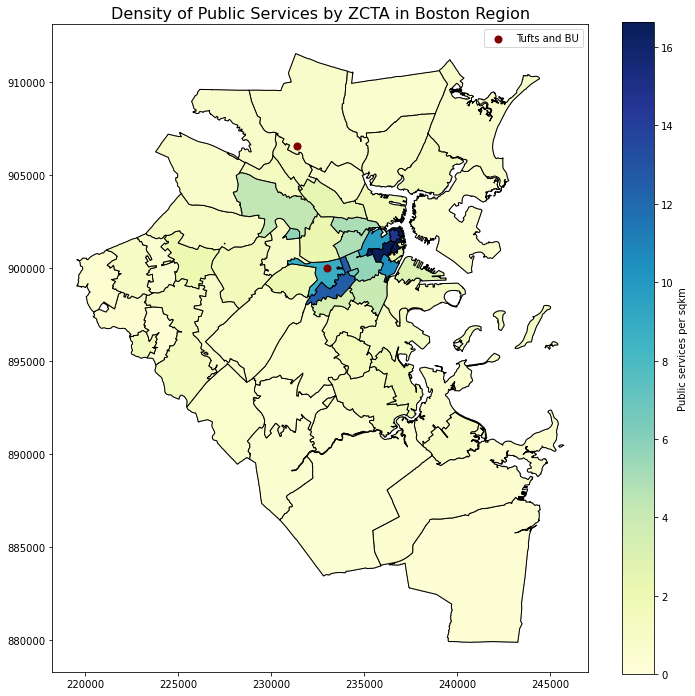

In [131]:
# Map the density of public services in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_public_service.plot(column='public_service_density',
                         legend=True,
                         edgecolor='black',
                         cmap='YlGnBu',
                         legend_kwds={'label': "Public services per sqkm"},
                         ax=ax)
tufts_bu.plot(ax=ax, color='maroon', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Density of Public Services by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

#### Reclassify Public Services Density

In [132]:
# Calculate values to separate public service density into five quantiles.
public_service_quints = quantiles(zcta_public_service, 'public_service_density', quintiles)
public_service_quints

[0.6056462665565777, 0.9774365423711138, 1.48365394150584, 4.264038265779278]

In [133]:
# Reclassify public service density with reclass_5 function and quintile values.
zcta_public_service['public_service_density_reclass'] = zcta_public_service['public_service_density'].apply(lambda x: reclass_5(x, public_service_quints, 'high'))

In [134]:
# View top and bottom five health-service-dense ZCTAs.
zcta_public_service.sort_values(by='public_service_density_reclass', ascending=False)

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
1      35        25     02141  2502141        B5   G6350          S   1572423   
40    306        25     02215  2502215        B5   G6350          S   1984378   
59    493        25     02111  2502111        B5   G6350          S    754214   
33    253        25     02109  2502109        B5   G6350          S    427819   
56    438        25     02108  2502108        B5   G6350          S    721093   
..    ...       ...       ...      ...       ...     ...        ...       ...   
28    248        25     02136  2502136        B5   G6350          S  11889865   
26    236        25     02461  2502461        B5   G6350          S   3263402   
25    229        25     02460  2502460        B5   G6350          S   3651425   
24    226        25     02468  2502468        B5   G6350          S   4120625   
61    495        25     02222  2502222        B5   G6350          S     77896   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
1      44304  +42.3702998  -071.0825603         N   
40    279591  +42.3470532  -071.1019853         N   
59     79209  +42.3487843  -071.0589880         N   
33         0  +42.3626531  -071.0538044         N   
56         0  +42.3575539  -071.0639133         N   
..       ...          ...           ...       ...   
28    266448  +42.2550833  -071.1292203         N   
26     13513  +42.3190310  -071.2081690         N   
25     20856  +42.3520061  -071.2092424         N   
24     57832  +42.3291748  -071.2315831         N   
61         0  +42.3664695  -071.0624939         N   

                                             geometry  fire_count  \
1   POLYGON ((234064.636 902597.603, 234080.228 90...         1.0   
40  POLYGON ((230882.811 900191.721, 230873.568 90...         0.0   
59  POLYGON ((236144.915 900687.565, 236153.840 90...         2.0   
33  MULTIPOLYGON (((236437.338 900792.044, 236429....         1.0   
56  POLYGON ((235436.185 900908.999, 235400.476 90...         0.0   
..                                                ...         ...   
28  POLYGON ((232000.362 889791.619, 232054.679 88...         2.0   
26  POLYGON ((223647.892 895122.104, 223644.504 89...         0.0   
25  POLYGON ((224712.729 900305.384, 224780.933 90...         1.0   
24  POLYGON ((220628.408 897708.340, 220639.271 89...         0.0   
61  POLYGON ((235839.790 902134.685, 235852.488 90...         0.0   

    police_count  usps_count  library_count  public_service_count  \
1            1.0         3.0            3.0                   8.0   
40           0.0         4.0           16.0                  20.0   
59           0.0         3.0            3.0                   8.0   
33           0.0         1.0            5.0                   7.0   
56           1.0         1.0           10.0                  12.0   
..           ...         ...            ...                   ...   
28           1.0         3.0            1.0                   7.0   
26           0.0         1.0            0.0                   1.0   
25           0.0         1.0            0.0                   2.0   
24           0.0         1.0            1.0                   2.0   
61           0.0         0.0            0.0                   0.0   

    public_service_density  public_service_density_reclass  
1                 4.992734                               5  
40                8.834564                               5  
59               10.544102                               5  
33               16.614066                               5  
56               16.642580                               5  
..                     ...                             ...  
28                0.577757                               1  
26                0.305185                               1  
25                0.544656                               1  
24                0.478677                               1  
61                0.000000                               1  

[62

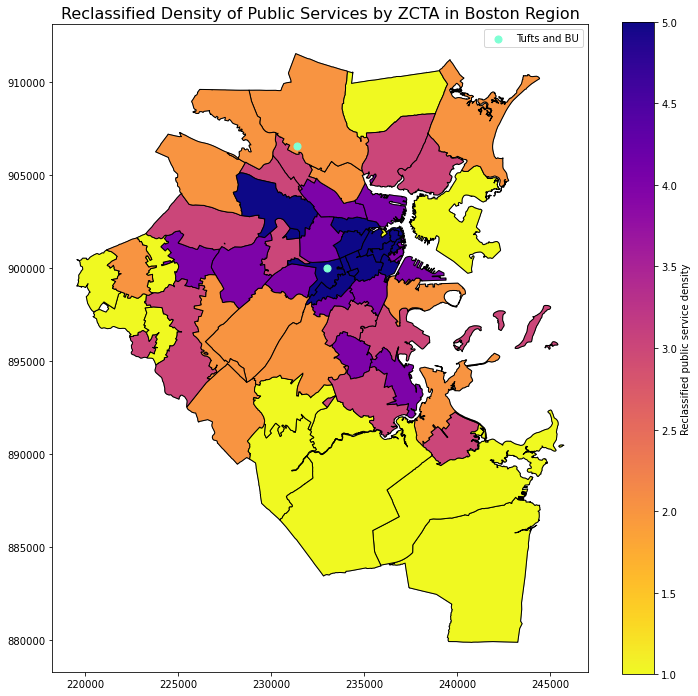

In [135]:
# Map reclassified public service density in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_public_service.plot(column='public_service_density_reclass',
                         legend=True,
                         edgecolor='black',
                         cmap='plasma_r',
                         legend_kwds={'label': "Reclassified public service density"},
                         ax=ax)
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Reclassified Density of Public Services by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
boston_water.plot(ax=ax, alpha=0.3)
grocery.plot(ax=ax, markersize=15, color='yellow', label='Groceries')
healthcare.plot(ax=ax, markersize=15, color='aquamarine', label='Healthcare')
comm_health.plot(ax=ax, markersize=15, color='coral', label='Community Health Centers')
hospitals.plot(ax=ax, markersize=20, color='orangered', label='Hospitals')
public_service.plot(ax=ax, markersize=10, color='dodgerblue', label='Public Services')
plt.title('Necessary Amenities within Boston Region Rapid Transit Extent', fontsize=16)
plt.legend()
plt.show()

---

## Calculate Weighted Suitability Index
Analyzing the reclassification maps of each indicator (mass transit, rent affordability, food establishment, health services, and public services), there is significant variation in desirable ZCTAs for each indicator. A weighted index was created to compare overall suitability across all indicators.

### Add Reclassification Columns to ZCTAs

In [136]:
# Add analysis and reclass columns to base rt_zcta using function multimerge and view info to confirm success.
indicators_list = [zcta_nodes, zcta_rent, zcta_food, zcta_health, zcta_public_service]
on_cols = ['index', 'STATEFP00', 'ZCTA5CE00', 'GEOID00', 'CLASSFP00', 'MTFCC00', 'FUNCSTAT00', 'ALAND00', 'AWATER00', 'INTPTLAT00', 'INTPTLON00', 'PARTFLG00', 'geometry']
zcta_index = multimerge(rt_zcta, indicators_list, on_cols, 'left')
zcta_index.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 45 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   index                           62 non-null     int64   
 1   STATEFP00                       62 non-null     object  
 2   ZCTA5CE00                       62 non-null     object  
 3   GEOID00                         62 non-null     object  
 4   CLASSFP00                       62 non-null     object  
 5   MTFCC00                         62 non-null     object  
 6   FUNCSTAT00                      62 non-null     object  
 7   ALAND00                         62 non-null     int64   
 8   AWATER00                        62 non-null     int64   
 9   INTPTLAT00                      62 non-null     object  
 10  INTPTLON00                      62 non-null     object  
 11  PARTFLG00                       62 non-null     object  
 12  geometry        

### Calculate Weighted Index
A weighted index is highly subjective. Some may value availability of food over cost of rent, while others may value convenience of public transit over all else. For the purposes of this study (ostensibly concerned with living as a student without a car), rent affordability was given the most weight (35%) while transit and food were given equal weights (20% each). Health services were valued next (15%) and public services last (10%). 

Because rental data was only available in a segment of ZCTAs, `NaN` values were preserved across index calculations to ensure a fair comparison.

In [137]:
# Calculate weighted index and view info.
zcta_index['weighted'] = zcta_index.nodes_density_reclass*0.2 + zcta_index.rent_median_reclass*0.35 + zcta_index.food_density_reclass*0.2 + zcta_index.health_density_reclass*0.15 + zcta_index.public_service_density_reclass*0.1
zcta_index.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 46 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   index                           62 non-null     int64   
 1   STATEFP00                       62 non-null     object  
 2   ZCTA5CE00                       62 non-null     object  
 3   GEOID00                         62 non-null     object  
 4   CLASSFP00                       62 non-null     object  
 5   MTFCC00                         62 non-null     object  
 6   FUNCSTAT00                      62 non-null     object  
 7   ALAND00                         62 non-null     int64   
 8   AWATER00                        62 non-null     int64   
 9   INTPTLAT00                      62 non-null     object  
 10  INTPTLON00                      62 non-null     object  
 11  PARTFLG00                       62 non-null     object  
 12  geometry        

In [138]:
# View top and bottom five weighted ZCTAs.
zcta_index.sort_values(by='weighted', ascending=False)

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
2      36        25     02143  2502143        B5   G6350          S   4007477   
40    306        25     02215  2502215        B5   G6350          S   1984378   
39    305        25     02135  2502135        B5   G6350          S   7222258   
17    115        25     02115  2502115        B5   G6350          S   1979415   
31    251        25     02122  2502122        B5   G6350          S   4420941   
..    ...       ...       ...      ...       ...     ...        ...       ...   
25    229        25     02460  2502460        B5   G6350          S   3651425   
26    236        25     02461  2502461        B5   G6350          S   3263402   
35    285        25     02459  2502459        B5   G6350          S  12417620   
43    365        25     02466  2502466        B5   G6350          S   4650253   
44    366        25     02465  2502465        B5   G6350          S   5288332   

    AWATER00   INTPTLAT00  ... health_density health_density_reclass  \
2          0  +42.3815721  ...       3.743245                      5   
40    279591  +42.3470532  ...       6.625923                      5   
39    469151  +42.3484167  ...       2.080378                      4   
17    162098  +42.3375449  ...       9.806794                      5   
31      9382  +42.2950881  ...       0.453151                      2   
..       ...          ...  ...            ...                    ...   
25     20856  +42.3520061  ...       0.000000                      1   
26     13513  +42.3190310  ...       0.610370                      3   
35    237715  +42.3142917  ...       0.237070                      2   
43    263098  +42.3444566  ...       0.407080                      2   
44       698  +42.3495328  ...       0.189083                      1   

   fire_count  police_count  usps_count  library_count  public_service_count  \
2         3.0           1.0         2.0            4.0                  10.0   
40        0.0           0.0         4.0           16.0                  20.0   
39        2.0           2.0         1.0            7.0                  12.0   
17        2.0           0.0         1.0           24.0                  27.0   
31        2.0           1.0         2.0            3.0                   8.0   
..        ...           ...         ...            ...                   ...   
25        1.0           0.0         1.0            0.0                   2.0   
26        0.0           0.0         1.0            0.0                   1.0   
35        3.0           0.0         3.0           11.0                  17.0   
43        0.0           0.0         1.0            1.0                   2.0   
44        1.0           2.0         1.0            1.0                   5.0   

    public_service_density  public_service_density_reclass  weighted  
2                 2.495496                               4      4.00  
40                8.834564                               5      3.95  
39                1.560284                               4      3.95  
17               12.608735                               5      3.95  
31                1.812604                               4      3.85  
..                     ...                             ...       ...  
25                0.544656                               1       NaN  
26                0.305185                               1       NaN  
35                1.343397                               3       NaN  
43                0.407080                               1       NaN  
44                0.945413                               2       NaN  

[62 rows x 46 columns]

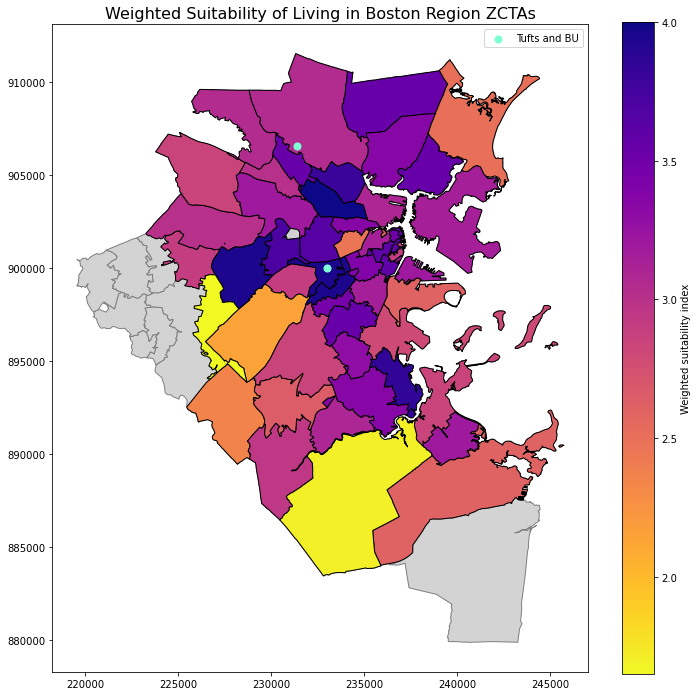

In [139]:
# Map the weighted index in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
zcta_index.plot(column='weighted',
                 legend=True,
                 edgecolor='black',
                 cmap='plasma_r',
                 legend_kwds={'label': "Weighted suitability index"},
                 ax=ax)
plt.title('Weighted Suitability of Living in Boston Region ZCTAs', fontsize=16)
plt.legend()
plt.show()

## Beyond Necessities

### Bike Facilities

### Leisure

#### Find Leisure Features with OSMnx

In [140]:
# Retrieve leisure features within graph_extent_latlong from OSMnx and view info.
leisure_tags = {'leisure':True, 'amenity':['bar', 'biergarten', 'ice_cream', 'pub', 'bicycle_rental', 'arts_centre', 'cinema', 'nightclub', 'planetarium', 'social_centre', 'theatre', 'bbq']}
leisure = ox.geometries_from_polygon(graph_extent_latlong, leisure_tags)
leisure = convert_n_clip(leisure, rt_zcta)
leisure.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 5140 entries, 0 to 8949
Columns: 366 entries, unique_id to golf:course
dtypes: geometry(1), int64(1), object(364)
memory usage: 14.4+ MB


In [141]:
# View first five rows of leisure GDF.
leisure.head()

unique_id      osmid element_type highway  \
0   node/61341459   61341459         node     NaN   
2  node/313552811  313552811         node     NaN   
3  node/316901780  316901780         node     NaN   
4  node/316902218  316902218         node     NaN   
5  node/317333141  317333141         node     NaN   

                        geometry  \
0  POINT (234531.223 895737.946)   
2  POINT (232410.376 901897.970)   
3  POINT (240363.907 891417.444)   
4  POINT (240432.614 891290.145)   
5  POINT (232997.005 901526.956)   

                                         attribution        leisure  \
0  Office of Geographic and Environmental Informa...            yes   
2                                                NaN  sports_centre   
3                                                NaN  sports_centre   
4                                                NaN            NaN   
5                                                NaN            NaN   

                               source barrier      created_by  ...  \
0  massgis_import_v0.1_20071008193615     NaN             NaN  ...   
2                       USGS Geonames     NaN             NaN  ...   
3                                 NaN     NaN  Potlatch 0.10f  ...   
4                                 NaN     NaN             NaN  ...   
5                                 NaN     NaN             NaN  ...   

  name:signed theatre heating ways leisure_1 history operation  \
0         NaN     NaN     NaN  NaN       NaN     NaN       NaN   
2         NaN     NaN     NaN  NaN       NaN     NaN       NaN   
3         NaN     NaN     NaN  NaN       NaN     NaN       NaN   
4         NaN     NaN     NaN  NaN       NaN     NaN       NaN   
5         NaN     NaN     NaN  NaN       NaN     NaN       NaN   

  massgis:BOND_ACCT lanes:sprint golf:course  
0               NaN          NaN         NaN  
2               NaN          NaN         NaN  
3               NaN          NaN         NaN  
4               NaN          NaN         NaN  
5               NaN          NaN         NaN  

[5 rows x 366 columns]

#### Calculate Leisure Density

In [142]:
# Use count_records on leisure.
zcta_leisure_count = count_records(leisure, rt_zcta, 'ZCTA5CE00', 'leisure_count')
zcta_leisure_count

ZCTA5CE00  leisure_count
0      02139            218
1      02116            203
2      02138            201
3      02128            185
4      02445            168
..       ...            ...
57     02113             21
58     02468             15
59     02222             11
60     02163              7
61     02464              6

[62 rows x 2 columns]

In [143]:
# Merge statistics with spatial ZCTA rental GDF.
zcta_leisure = rt_zcta.merge(zcta_leisure_count, on='ZCTA5CE00', how='left')
zcta_leisure.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   index          62 non-null     int64   
 1   STATEFP00      62 non-null     object  
 2   ZCTA5CE00      62 non-null     object  
 3   GEOID00        62 non-null     object  
 4   CLASSFP00      62 non-null     object  
 5   MTFCC00        62 non-null     object  
 6   FUNCSTAT00     62 non-null     object  
 7   ALAND00        62 non-null     int64   
 8   AWATER00       62 non-null     int64   
 9   INTPTLAT00     62 non-null     object  
 10  INTPTLON00     62 non-null     object  
 11  PARTFLG00      62 non-null     object  
 12  geometry       62 non-null     geometry
 13  leisure_count  62 non-null     int64   
dtypes: geometry(1), int64(4), object(9)
memory usage: 7.3+ KB


In [144]:
# Calculate node density in leisure/sqkm.
zcta_leisure['leisure_density'] = zcta_leisure.leisure_count/zcta_leisure.area*(10**6)
zcta_leisure.sort_values(by='leisure_density', ascending=False).head()

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00  ALAND00  \
42    308        25     02199  2502199        B5   G6350          S   149678   
61    495        25     02222  2502222        B5   G6350          S    77896   
48    377        25     02110  2502110        B5   G6350          S   428520   
53    435        25     02116  2502116        B5   G6350          S  1712064   
56    438        25     02108  2502108        B5   G6350          S   721093   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
42         0  +42.3474648  -071.0820577         N   
61         0  +42.3664695  -071.0624939         N   
48         0  +42.3573712  -071.0531804         N   
53    222385  +42.3499907  -071.0760802         N   
56         0  +42.3575539  -071.0639133         N   

                                             geometry  leisure_count  \
42  POLYGON ((234168.090 899801.270, 234292.861 89...             36   
61  POLYGON ((235839.790 902134.685, 235852.488 90...             11   
48  POLYGON ((236791.320 900796.888, 236751.472 90...             51   
53  POLYGON ((234702.966 899809.334, 234675.900 89...            203   
56  POLYGON ((235436.185 900908.999, 235400.476 90...             67   

    leisure_density  
42       240.532628  
61       141.259541  
48       121.320211  
53       104.945916  
56        92.921070

In [145]:
# View statistics for leisure_density.
zcta_leisure.leisure_density.describe()

count     62.000000
mean      29.549776
std       40.607613
min        2.594062
25%        7.201755
50%       14.062325
75%       33.348924
max      240.532628
Name: leisure_density, dtype: float64

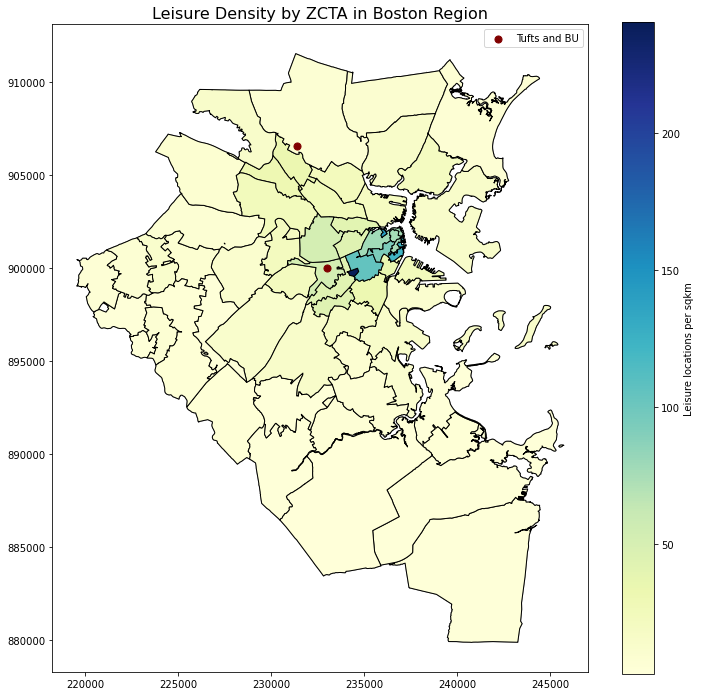

In [146]:
# Map the leisure density in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_leisure.plot(column='leisure_density',
                 legend=True,
                 edgecolor='black',
                 cmap='YlGnBu',
                 legend_kwds={'label': "Leisure locations per sqkm"},
                 ax=ax)
tufts_bu.plot(ax=ax, color='maroon', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Leisure Density by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

#### Reclassify Leisure Density

In [147]:
# Calculate values to separate leisure into five quantiles.
# Use same quintiles list of thresholds from reclassifying transit.
leisure_quants = quantiles(zcta_leisure, 'leisure_density', quintiles)
leisure_quants

[5.768754823961562, 10.503707514921755, 20.23402403963464, 42.60849011005875]

In [148]:
# Reclassify leisure density with reclass_5 function and quintile values.
zcta_leisure['leisure_density_reclass'] = zcta_leisure['leisure_density'].apply(lambda x: reclass_5(x, leisure_quants, 'high'))

In [149]:
# View top and bottom five median rental ZCTAs.
zcta_leisure.sort_values(by='leisure_density_reclass', ascending=False)

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
61    495        25     02222  2502222        B5   G6350          S     77896   
56    438        25     02108  2502108        B5   G6350          S    721093   
50    379        25     02114  2502114        B5   G6350          S   1065352   
48    377        25     02110  2502110        B5   G6350          S    428520   
45    369        25     02142  2502142        B5   G6350          S   1053187   
..    ...       ...       ...      ...       ...     ...        ...       ...   
21    171        25     02184  2502184        B5   G6350          S  35903196   
38    298        25     02171  2502171        B5   G6350          S   6439951   
24    226        25     02468  2502468        B5   G6350          S   4120625   
35    285        25     02459  2502459        B5   G6350          S  12417620   
46    370        25     02467  2502467        B5   G6350          S   5755959   

    AWATER00   INTPTLAT00    INTPTLON00 PARTFLG00  \
61         0  +42.3664695  -071.0624939         N   
56         0  +42.3575539  -071.0639133         N   
50    343761  +42.3631745  -071.0686463         N   
48         0  +42.3573712  -071.0531804         N   
45    577829  +42.3612796  -071.0837525         N   
..       ...          ...           ...       ...   
21   2081541  +42.2054158  -071.0021680         N   
38    110355  +42.2861505  -071.0259433         N   
24     57832  +42.3291748  -071.2315831         N   
35    237715  +42.3142917  -071.1946111         N   
46    108004  +42.3220888  -071.1727600         N   

                                             geometry  leisure_count  \
61  POLYGON ((235839.790 902134.685, 235852.488 90...             11   
56  POLYGON ((235436.185 900908.999, 235400.476 90...             67   
50  MULTIPOLYGON (((234691.735 900849.190, 234663....            104   
48  POLYGON ((236791.320 900796.888, 236751.472 90...             51   
45  POLYGON ((234327.174 901947.740, 234397.406 90...             71   
..                                                ...            ...   
21  MULTIPOLYGON (((237408.847 882805.326, 237292....            144   
38  MULTIPOLYGON (((239149.911 894448.989, 239180....             27   
24  POLYGON ((220628.408 897708.340, 220639.271 89...             15   
35  MULTIPOLYGON (((226381.301 895402.075, 226417....             67   
46  POLYGON ((226191.027 898407.653, 226180.838 89...             24   

    leisure_density  leisure_density_reclass  
61       141.259541                        5  
56        92.921070                        5  
50        77.297392                        5  
48       121.320211                        5  
45        43.533997                        5  
..              ...                      ...  
21         3.829714                        1  
38         4.140655                        1  
24         3.590076                        1  
35         5.294565                        1  
46         4.093062                        1  

[62 rows x 16 columns]

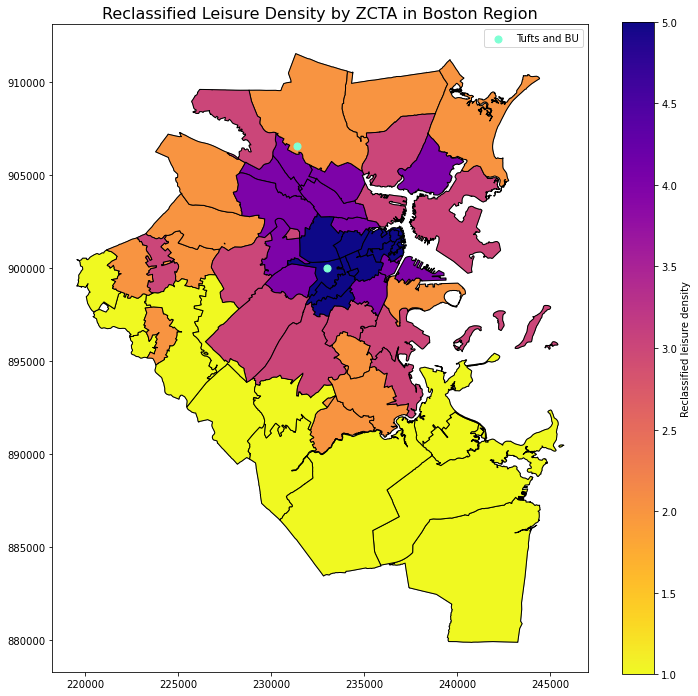

In [150]:
# Map the median rent price in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_leisure.plot(column='leisure_density_reclass',
                 legend=True,
                 edgecolor='black',
                 cmap='plasma_r',
                 legend_kwds={'label': "Reclassified leisure density"},
                 ax=ax)
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
plt.title('Reclassified Leisure Density by ZCTA in Boston Region', fontsize=16)
plt.legend()
plt.show()

### Recalculate Weighted Index
The weighted index was recalculated to account for leisure. Rent affordability was still given the most weight (35%) while transit and food were remained equal (20% each). Health services were valued next (12%), then public services (8%), and leisure last (5%). 

Because rental data was only available in a segment of ZCTAs, `NaN` values were preserved across index calculations to ensure a fair comparison.

In [151]:
# Add analysis and reclass columns to base rt_zcta using function multimerge and view info to confirm success.
on_cols = ['index', 'STATEFP00', 'ZCTA5CE00', 'GEOID00', 'CLASSFP00', 'MTFCC00', 'FUNCSTAT00', 'ALAND00', 'AWATER00', 'INTPTLAT00', 'INTPTLON00', 'PARTFLG00', 'geometry']
zcta_index = zcta_index.merge(zcta_leisure, on=on_cols, how='left')
zcta_index.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   index                           62 non-null     int64   
 1   STATEFP00                       62 non-null     object  
 2   ZCTA5CE00                       62 non-null     object  
 3   GEOID00                         62 non-null     object  
 4   CLASSFP00                       62 non-null     object  
 5   MTFCC00                         62 non-null     object  
 6   FUNCSTAT00                      62 non-null     object  
 7   ALAND00                         62 non-null     int64   
 8   AWATER00                        62 non-null     int64   
 9   INTPTLAT00                      62 non-null     object  
 10  INTPTLON00                      62 non-null     object  
 11  PARTFLG00                       62 non-null     object  
 12  geometry        

In [152]:
# Calculate weighted index and view info.
zcta_index['weighted_leisure'] = zcta_index.nodes_density_reclass*0.2 + zcta_index.rent_median_reclass*0.35 + zcta_index.food_density_reclass*0.2 + zcta_index.health_density_reclass*0.12 + zcta_index.public_service_density_reclass*0.08 + zcta_index.leisure_density_reclass*0.05
zcta_index.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 50 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   index                           62 non-null     int64   
 1   STATEFP00                       62 non-null     object  
 2   ZCTA5CE00                       62 non-null     object  
 3   GEOID00                         62 non-null     object  
 4   CLASSFP00                       62 non-null     object  
 5   MTFCC00                         62 non-null     object  
 6   FUNCSTAT00                      62 non-null     object  
 7   ALAND00                         62 non-null     int64   
 8   AWATER00                        62 non-null     int64   
 9   INTPTLAT00                      62 non-null     object  
 10  INTPTLON00                      62 non-null     object  
 11  PARTFLG00                       62 non-null     object  
 12  geometry        

In [153]:
# View top and bottom five weighted ZCTAs.
zcta_index.sort_values(by='weighted_leisure', ascending=False)

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
2      36        25     02143  2502143        B5   G6350          S   4007477   
17    115        25     02115  2502115        B5   G6350          S   1979415   
40    306        25     02215  2502215        B5   G6350          S   1984378   
39    305        25     02135  2502135        B5   G6350          S   7222258   
31    251        25     02122  2502122        B5   G6350          S   4420941   
..    ...       ...       ...      ...       ...     ...        ...       ...   
25    229        25     02460  2502460        B5   G6350          S   3651425   
26    236        25     02461  2502461        B5   G6350          S   3263402   
35    285        25     02459  2502459        B5   G6350          S  12417620   
43    365        25     02466  2502466        B5   G6350          S   4650253   
44    366        25     02465  2502465        B5   G6350          S   5288332   

    AWATER00   INTPTLAT00  ... usps_count library_count public_service_count  \
2          0  +42.3815721  ...        2.0           4.0                 10.0   
17    162098  +42.3375449  ...        1.0          24.0                 27.0   
40    279591  +42.3470532  ...        4.0          16.0                 20.0   
39    469151  +42.3484167  ...        1.0           7.0                 12.0   
31      9382  +42.2950881  ...        2.0           3.0                  8.0   
..       ...          ...  ...        ...           ...                  ...   
25     20856  +42.3520061  ...        1.0           0.0                  2.0   
26     13513  +42.3190310  ...        1.0           0.0                  1.0   
35    237715  +42.3142917  ...        3.0          11.0                 17.0   
43    263098  +42.3444566  ...        1.0           1.0                  2.0   
44       698  +42.3495328  ...        1.0           1.0                  5.0   

    public_service_density  public_service_density_reclass  weighted  \
2                 2.495496                               4      4.00   
17               12.608735                               5      3.95   
40                8.834564                               5      3.95   
39                1.560284                               4      3.95   
31                1.812604                               4      3.85   
..                     ...                             ...       ...   
25                0.544656                               1       NaN   
26                0.305185                               1       NaN   
35                1.343397                               3       NaN   
43                0.407080                               1       NaN   
44                0.945413                               2       NaN   

    leisure_count  leisure_density  leisure_density_reclass  weighted_leisure  
2             107        26.701811                        4              3.97  
17             92        42.963098                        5              3.95  
40            119        52.565656                        5              3.95  
39             89        11.572103                        3              3.90  
31             48        10.875621                        3              3.86  
..            ...              ...                      ...               ...  
25             45        12.254766                        3               NaN  
26             24         7.324442                        2               NaN  
35             67         5.294565                        1               NaN  
43             28         5.699124                        1               NaN  
44             39         7.374219                        2               NaN  

[62 rows x 50 columns]

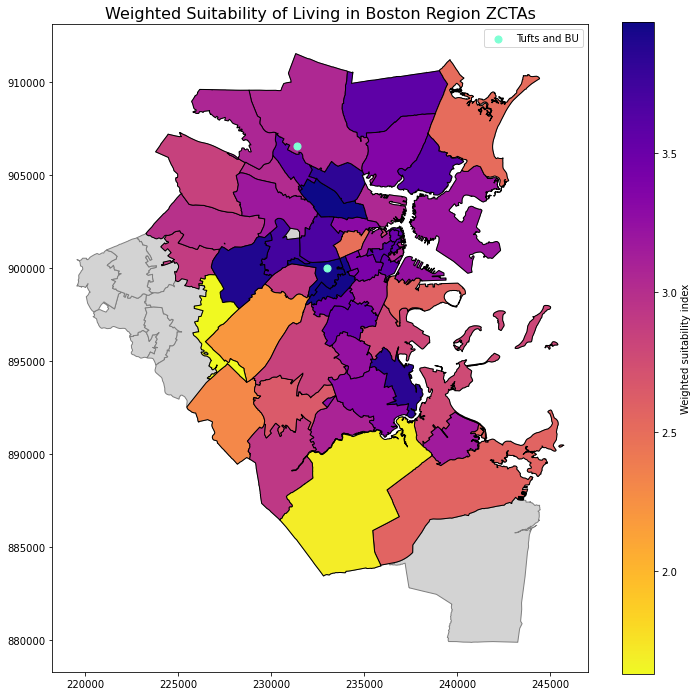

In [154]:
# Map the weighted index in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
tufts_bu.plot(ax=ax, color='aquamarine', markersize=50, zorder=10, label='Tufts and BU')
zcta_index.plot(column='weighted_leisure',
                 legend=True,
                 edgecolor='black',
                 cmap='plasma_r',
                 legend_kwds={'label': "Weighted suitability index"},
                 ax=ax)
plt.title('Weighted Suitability of Living in Boston Region ZCTAs', fontsize=16)
plt.legend()
plt.show()

---

# Appendix

## Zillow Data Analysis
Zillow data was analyzed but ultimately not used for the following reasons:
- The dataset is national and has limited information--only zipcodes, region names, and average monthly rental values.
- Fewer zipcodes were represented in Zillow data than Padmapper data.
- Zillow data represents only an average across entire zipcodes. Analyzing specific home types (such as defining numbers of bedrooms) was not possible with this data.

The analysis was preserved in the Appendix as an example and to compare with Padmapper data for those interested.

### Read In and Pre-Process National Zillow Data

In [155]:
# Read in CSV file of Zillow rental data.
zillow_df = pd.read_csv('./data/Zip_ZORI_AllHomesPlusMultifamily_SSA.csv')
zillow_df

RegionID  RegionName  SizeRank           MsaName  2014-01  2014-02  \
0        61639       10025         1      New York, NY   3001.0   3014.0   
1        84654       60657         2       Chicago, IL   1508.0   1514.0   
2        61637       10023         3      New York, NY   3098.0   3109.0   
3        91982       77494         4       Houston, TX   1620.0   1623.0   
4        84616       60614         5       Chicago, IL   1703.0   1708.0   
...        ...         ...       ...               ...      ...      ...   
2373     71856       32202      8772  Jacksonville, FL   1133.0   1137.0   
2374     58623        2109      8792        Boston, MA      NaN   2680.0   
2375     58622        2108      8986        Boston, MA   2519.0   2517.0   
2376     66128       20004      9592    Washington, DC      NaN      NaN   
2377     84604       60602     10262       Chicago, IL   2387.0      NaN   

      2014-03  2014-04  2014-05  2014-06  ...  2020-06  2020-07  2020-08  \
0      3027.0   3040.0   3053.0   3066.0  ...   3125.0   3084.0   3043.0   
1      1519.0   1524.0   1529.0   1534.0  ...   1727.0   1720.0   1714.0   
2      3120.0   3131.0   3142.0   3152.0  ...   3217.0   3177.0   3135.0   
3      1626.0   1629.0   1632.0   1635.0  ...   1645.0   1648.0   1652.0   
4      1713.0   1718.0   1723.0   1727.0  ...   1952.0   1939.0   1926.0   
...       ...      ...      ...      ...  ...      ...      ...      ...   
2373   1141.0      NaN   1148.0   1152.0  ...   1411.0   1415.0   1420.0   
2374   2684.0   2689.0   2694.0   2698.0  ...   2852.0   2820.0   2785.0   
2375   2516.0   2515.0   2514.0   2514.0  ...   2880.0   2856.0   2823.0   
2376   2311.0   2321.0      NaN   2337.0  ...   2478.0   2468.0   2456.0   
2377      NaN   2289.0      NaN   2225.0  ...   2227.0   2195.0   2166.0   

      2020-09  2020-10  2020-11  2020-12  2021-01  2021-02  2021-03  
0      3002.0   2961.0   2919.0   2877.0   2835.0   2794.0   2752.0  
1      1708.0   1702.0   1695.0   1689.0   1683.0   1677.0   1671.0  
2      3094.0   3053.0   3010.0   2968.0   2926.0   2883.0   2841.0  
3      1657.0   1661.0   1665.0   1670.0   1674.0   1679.0   1684.0  
4      1912.0   1899.0   1885.0   1871.0   1857.0   1842.0   1828.0  
...       ...      ...      ...      ...      ...      ...      ...  
2373   1424.0   1429.0   1434.0   1438.0   1443.0   1448.0   1453.0  
2374   2749.0   2714.0   2678.0   2642.0   2606.0   2570.0   2535.0  
2375   2789.0   2755.0   2721.0   2686.0   2651.0   2615.0   2579.0  
2376   2444.0   2432.0   2419.0   2407.0   2394.0   2381.0   2368.0  
2377   2136.0   2107.0   2079.0   2051.0   2023.0   1997.0   1971.0  

[2378 rows x 91 columns]

In [156]:
# View columns.
zillow_df.columns

Index(['RegionID', 'RegionName', 'SizeRank', 'MsaName', '2014-01', '2014-02',
       '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12', '2018-01', '2018-02',
       '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
       '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
       '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
       '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02',
       '2020-03', '2020-04', '2020-05', '2020-

In [157]:
# Narrow down to three years of data.
zillow_df = zillow_df.drop(columns=['2014-01', '2014-02',
       '2014-03', '2014-04', '2014-05', '2014-06', '2014-07', '2014-08',
       '2014-09', '2014-10', '2014-11', '2014-12', '2015-01', '2015-02',
       '2015-03', '2015-04', '2015-05', '2015-06', '2015-07', '2015-08',
       '2015-09', '2015-10', '2015-11', '2015-12', '2016-01', '2016-02',
       '2016-03', '2016-04', '2016-05', '2016-06', '2016-07', '2016-08',
       '2016-09', '2016-10', '2016-11', '2016-12', '2017-01', '2017-02',
       '2017-03', '2017-04', '2017-05', '2017-06', '2017-07', '2017-08',
       '2017-09', '2017-10', '2017-11', '2017-12'])
zillow_df

RegionID  RegionName  SizeRank           MsaName  2018-01  2018-02  \
0        61639       10025         1      New York, NY   3213.0   3214.0   
1        84654       60657         2       Chicago, IL   1686.0   1687.0   
2        61637       10023         3      New York, NY   3285.0   3288.0   
3        91982       77494         4       Houston, TX   1600.0   1602.0   
4        84616       60614         5       Chicago, IL   1909.0   1911.0   
...        ...         ...       ...               ...      ...      ...   
2373     71856       32202      8772  Jacksonville, FL   1310.0   1317.0   
2374     58623        2109      8792        Boston, MA   2848.0   2847.0   
2375     58622        2108      8986        Boston, MA   2701.0   2704.0   
2376     66128       20004      9592    Washington, DC   2471.0   2466.0   
2377     84604       60602     10262       Chicago, IL   2316.0   2318.0   

      2018-03  2018-04  2018-05  2018-06  ...  2020-06  2020-07  2020-08  \
0      3214.0   3215.0   3218.0   3221.0  ...   3125.0   3084.0   3043.0   
1      1687.0   1687.0   1688.0   1688.0  ...   1727.0   1720.0   1714.0   
2      3290.0   3292.0   3298.0   3303.0  ...   3217.0   3177.0   3135.0   
3      1604.0   1606.0   1606.0   1607.0  ...   1645.0   1648.0   1652.0   
4      1912.0   1914.0   1915.0   1916.0  ...   1952.0   1939.0   1926.0   
...       ...      ...      ...      ...  ...      ...      ...      ...   
2373   1324.0   1330.0   1336.0   1342.0  ...   1411.0   1415.0   1420.0   
2374   2846.0   2845.0   2844.0   2843.0  ...   2852.0   2820.0   2785.0   
2375   2708.0   2711.0   2715.0   2719.0  ...   2880.0   2856.0   2823.0   
2376   2461.0   2455.0   2454.0   2453.0  ...   2478.0   2468.0   2456.0   
2377   2321.0      NaN      NaN   2335.0  ...   2227.0   2195.0   2166.0   

      2020-09  2020-10  2020-11  2020-12  2021-01  2021-02  2021-03  
0      3002.0   2961.0   2919.0   2877.0   2835.0   2794.0   2752.0  
1      1708.0   1702.0   1695.0   1689.0   1683.0   1677.0   1671.0  
2      3094.0   3053.0   3010.0   2968.0   2926.0   2883.0   2841.0  
3      1657.0   1661.0   1665.0   1670.0   1674.0   1679.0   1684.0  
4      1912.0   1899.0   1885.0   1871.0   1857.0   1842.0   1828.0  
...       ...      ...      ...      ...      ...      ...      ...  
2373   1424.0   1429.0   1434.0   1438.0   1443.0   1448.0   1453.0  
2374   2749.0   2714.0   2678.0   2642.0   2606.0   2570.0   2535.0  
2375   2789.0   2755.0   2721.0   2686.0   2651.0   2615.0   2579.0  
2376   2444.0   2432.0   2419.0   2407.0   2394.0   2381.0   2368.0  
2377   2136.0   2107.0   2079.0   2051.0   2023.0   1997.0   1971.0  

[2378 rows x 43 columns]

In [158]:
# Before merging, view datatypes for zip code columns in zillow_df and rt_zcta.
print(rt_zcta.ZCTA5CE00.dtype)
print(zillow_df.RegionName.dtype)

object
int64


In [159]:
# Convert Zillow's zipcode column to string and fill in leading zeroes.
zillow_df.RegionName = zillow_df.RegionName.astype('string').str.zfill(5)
zillow_df

RegionID RegionName  SizeRank           MsaName  2018-01  2018-02  \
0        61639      10025         1      New York, NY   3213.0   3214.0   
1        84654      60657         2       Chicago, IL   1686.0   1687.0   
2        61637      10023         3      New York, NY   3285.0   3288.0   
3        91982      77494         4       Houston, TX   1600.0   1602.0   
4        84616      60614         5       Chicago, IL   1909.0   1911.0   
...        ...        ...       ...               ...      ...      ...   
2373     71856      32202      8772  Jacksonville, FL   1310.0   1317.0   
2374     58623      02109      8792        Boston, MA   2848.0   2847.0   
2375     58622      02108      8986        Boston, MA   2701.0   2704.0   
2376     66128      20004      9592    Washington, DC   2471.0   2466.0   
2377     84604      60602     10262       Chicago, IL   2316.0   2318.0   

      2018-03  2018-04  2018-05  2018-06  ...  2020-06  2020-07  2020-08  \
0      3214.0   3215.0   3218.0   3221.0  ...   3125.0   3084.0   3043.0   
1      1687.0   1687.0   1688.0   1688.0  ...   1727.0   1720.0   1714.0   
2      3290.0   3292.0   3298.0   3303.0  ...   3217.0   3177.0   3135.0   
3      1604.0   1606.0   1606.0   1607.0  ...   1645.0   1648.0   1652.0   
4      1912.0   1914.0   1915.0   1916.0  ...   1952.0   1939.0   1926.0   
...       ...      ...      ...      ...  ...      ...      ...      ...   
2373   1324.0   1330.0   1336.0   1342.0  ...   1411.0   1415.0   1420.0   
2374   2846.0   2845.0   2844.0   2843.0  ...   2852.0   2820.0   2785.0   
2375   2708.0   2711.0   2715.0   2719.0  ...   2880.0   2856.0   2823.0   
2376   2461.0   2455.0   2454.0   2453.0  ...   2478.0   2468.0   2456.0   
2377   2321.0      NaN      NaN   2335.0  ...   2227.0   2195.0   2166.0   

      2020-09  2020-10  2020-11  2020-12  2021-01  2021-02  2021-03  
0      3002.0   2961.0   2919.0   2877.0   2835.0   2794.0   2752.0  
1      1708.0   1702.0   1695.0   1689.0   1683.0   1677.0   1671.0  
2      3094.0   3053.0   3010.0   2968.0   2926.0   2883.0   2841.0  
3      1657.0   1661.0   1665.0   1670.0   1674.0   1679.0   1684.0  
4      1912.0   1899.0   1885.0   1871.0   1857.0   1842.0   1828.0  
...       ...      ...      ...      ...      ...      ...      ...  
2373   1424.0   1429.0   1434.0   1438.0   1443.0   1448.0   1453.0  
2374   2749.0   2714.0   2678.0   2642.0   2606.0   2570.0   2535.0  
2375   2789.0   2755.0   2721.0   2686.0   2651.0   2615.0   2579.0  
2376   2444.0   2432.0   2419.0   2407.0   2394.0   2381.0   2368.0  
2377   2136.0   2107.0   2079.0   2051.0   2023.0   1997.0   1971.0  

[2378 rows x 43 columns]

In [160]:
# Merge zillow_df and rt_zcta on zipcode columns and view info.
zcta_zillow = rt_zcta.merge(zillow_df, left_on='ZCTA5CE00', right_on='RegionName', how='left')
zcta_zillow.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 62 entries, 0 to 61
Data columns (total 56 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   index       62 non-null     int64   
 1   STATEFP00   62 non-null     object  
 2   ZCTA5CE00   62 non-null     object  
 3   GEOID00     62 non-null     object  
 4   CLASSFP00   62 non-null     object  
 5   MTFCC00     62 non-null     object  
 6   FUNCSTAT00  62 non-null     object  
 7   ALAND00     62 non-null     int64   
 8   AWATER00    62 non-null     int64   
 9   INTPTLAT00  62 non-null     object  
 10  INTPTLON00  62 non-null     object  
 11  PARTFLG00   62 non-null     object  
 12  geometry    62 non-null     geometry
 13  RegionID    37 non-null     float64 
 14  RegionName  37 non-null     string  
 15  SizeRank    37 non-null     float64 
 16  MsaName     37 non-null     object  
 17  2018-01     37 non-null     float64 
 18  2018-02     37 non-null     float64 
 19  20

In [161]:
# View first and last five columns of Zillow data.
zcta_zillow

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
0      31        25     02458  2502458        B5   G6350          S   4709183   
1      35        25     02141  2502141        B5   G6350          S   1572423   
2      36        25     02143  2502143        B5   G6350          S   4007477   
3      37        25     02472  2502472        B5   G6350          S  10410330   
4      39        25     02464  2502464        B5   G6350          S   1447706   
..    ...       ...       ...      ...       ...     ...        ...       ...   
57    482        25     02139  2502139        B5   G6350          S   3784723   
58    484        25     02474  2502474        B5   G6350          S   7903556   
59    493        25     02111  2502111        B5   G6350          S    754214   
60    494        25     02130  2502130        B5   G6350          S  11393804   
61    495        25     02222  2502222        B5   G6350          S     77896   

    AWATER00   INTPTLAT00  ... 2020-06 2020-07 2020-08  2020-09 2020-10  \
0      57045  +42.3541154  ...     NaN     NaN     NaN      NaN     NaN   
1      44304  +42.3702998  ...  2770.0  2744.0  2714.0   2684.0  2653.0   
2          0  +42.3815721  ...  2651.0  2631.0  2614.0   2596.0  2579.0   
3     355268  +42.3694508  ...  2271.0  2260.0  2250.0   2239.0  2229.0   
4      29494  +42.3129751  ...     NaN     NaN     NaN      NaN     NaN   
..       ...          ...  ...     ...     ...     ...      ...     ...   
57    368360  +42.3622881  ...  2713.0  2688.0  2663.0   2637.0  2612.0   
58    518211  +42.4209494  ...  2199.0  2194.0  2188.0   2182.0  2177.0   
59     79209  +42.3487843  ...  3362.0  3317.0  3270.0   3224.0  3177.0   
60    369565  +42.3072770  ...  2419.0  2407.0  2395.0   2383.0  2371.0   
61         0  +42.3664695  ...     NaN     NaN     NaN      NaN     NaN   

    2020-11 2020-12  2021-01  2021-02  2021-03  
0       NaN     NaN      NaN      NaN      NaN  
1    2622.0  2591.0   2560.0   2529.0   2497.0  
2    2561.0  2542.0   2524.0   2507.0   2489.0  
3    2218.0  2207.0   2196.0   2185.0   2174.0  
4       NaN     NaN      NaN      NaN      NaN  
..      ...     ...      ...      ...      ...  
57   2585.0  2558.0   2531.0   2503.0   2476.0  
58   2170.0  2164.0   2158.0   2151.0   2145.0  
59   3129.0  3081.0   3032.0   2984.0   2935.0  
60   2359.0  2346.0   2334.0   2321.0   2309.0  
61      NaN     NaN      NaN      NaN      NaN  

[62 rows x 56 columns]

### Calculate Average Rent Across Years

In [162]:
# Define column lists for years.
cols_rent = ['2018-01', '2018-02',
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
             '2018-09', '2018-10', '2018-11', '2018-12', '2019-01', '2019-02',
             '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
             '2019-09', '2019-10', '2019-11', '2019-12', '2020-01', '2020-02',
             '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08',
             '2020-09', '2020-10', '2020-11', '2020-12', '2021-01', '2021-02',
             '2021-03']
cols_2018 = ['2018-01', '2018-02', 
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
             '2018-09', '2018-10', '2018-11', '2018-12']
cols_2019 = ['2019-01', '2019-02',
             '2019-03', '2019-04', '2019-05', '2019-06', '2019-07', '2019-08',
             '2019-09', '2019-10', '2019-11', '2019-12']
cols_2020 = ['2020-01', '2020-02',
             '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08',
             '2020-09', '2020-10', '2020-11', '2020-12']
cols_2021 = ['2021-01', '2021-02', '2021-03']

In [163]:
# Calculate yearly and overall average rental prices.
zcta_zillow['avg_2018'] = zcta_zillow[cols_2018].mean(axis=1)
zcta_zillow['avg_2019'] = zcta_zillow[cols_2019].mean(axis=1)
zcta_zillow['avg_2020'] = zcta_zillow[cols_2020].mean(axis=1)
zcta_zillow['avg_2021'] = zcta_zillow[cols_2021].mean(axis=1)
zcta_zillow['avg_rent'] = zcta_zillow[cols_rent].mean(axis=1)
zcta_zillow

index STATEFP00 ZCTA5CE00  GEOID00 CLASSFP00 MTFCC00 FUNCSTAT00   ALAND00  \
0      31        25     02458  2502458        B5   G6350          S   4709183   
1      35        25     02141  2502141        B5   G6350          S   1572423   
2      36        25     02143  2502143        B5   G6350          S   4007477   
3      37        25     02472  2502472        B5   G6350          S  10410330   
4      39        25     02464  2502464        B5   G6350          S   1447706   
..    ...       ...       ...      ...       ...     ...        ...       ...   
57    482        25     02139  2502139        B5   G6350          S   3784723   
58    484        25     02474  2502474        B5   G6350          S   7903556   
59    493        25     02111  2502111        B5   G6350          S    754214   
60    494        25     02130  2502130        B5   G6350          S  11393804   
61    495        25     02222  2502222        B5   G6350          S     77896   

    AWATER00   INTPTLAT00  ... 2020-11 2020-12 2021-01  2021-02 2021-03  \
0      57045  +42.3541154  ...     NaN     NaN     NaN      NaN     NaN   
1      44304  +42.3702998  ...  2622.0  2591.0  2560.0   2529.0  2497.0   
2          0  +42.3815721  ...  2561.0  2542.0  2524.0   2507.0  2489.0   
3     355268  +42.3694508  ...  2218.0  2207.0  2196.0   2185.0  2174.0   
4      29494  +42.3129751  ...     NaN     NaN     NaN      NaN     NaN   
..       ...          ...  ...     ...     ...     ...      ...     ...   
57    368360  +42.3622881  ...  2585.0  2558.0  2531.0   2503.0  2476.0   
58    518211  +42.4209494  ...  2170.0  2164.0  2158.0   2151.0  2145.0   
59     79209  +42.3487843  ...  3129.0  3081.0  3032.0   2984.0  2935.0   
60    369565  +42.3072770  ...  2359.0  2346.0  2334.0   2321.0  2309.0   
61         0  +42.3664695  ...     NaN     NaN     NaN      NaN     NaN   

       avg_2018     avg_2019     avg_2020     avg_2021     avg_rent  
0           NaN          NaN          NaN          NaN          NaN  
1   2694.250000  2807.666667  2745.250000  2528.666667  2732.102564  
2   2642.416667  2718.833333  2640.583333  2506.666667  2654.923077  
3   2184.833333  2271.416667  2262.750000  2185.000000  2235.461538  
4           NaN          NaN          NaN          NaN          NaN  
..          ...          ...          ...          ...          ...  
57  2773.333333  2794.833333  2691.750000  2503.333333  2734.076923  
58  2112.500000  2194.750000  2193.500000  2151.333333  2165.717949  
59  3422.583333  3523.916667  3328.833333  2983.666667  3391.153846  
60  2402.833333  2454.833333  2411.000000  2321.333333  2415.076923  
61          NaN          NaN          NaN          NaN          NaN  

[62 rows x 61 columns]

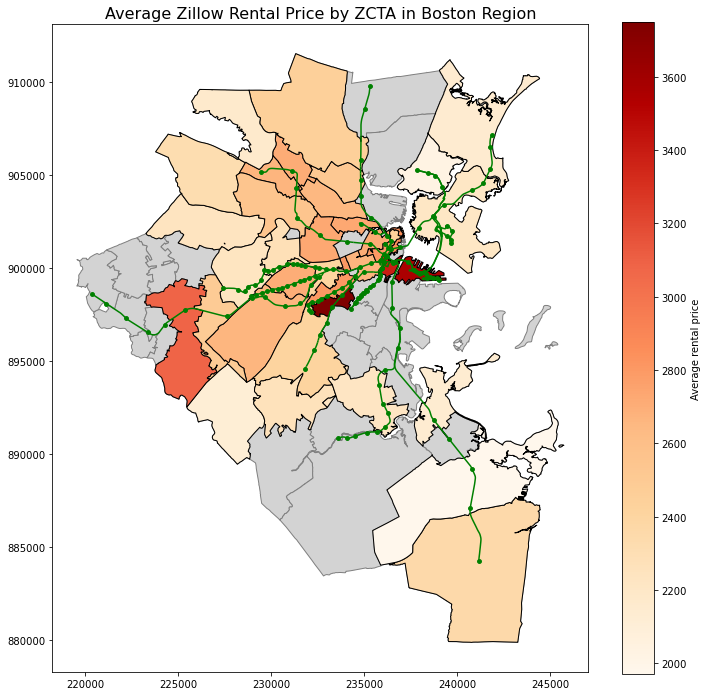

In [164]:
# Map the average Zillow rent price in each ZCTA.
ax = rt_zcta.plot(color='lightgrey', edgecolor='grey', figsize=(12,12))
zcta_zillow.plot(column='avg_rent',
                 legend=True,
                 edgecolor='black',
                 cmap='OrRd',
                 legend_kwds={'label': "Average rental price"},
                 ax=ax)
bos_rt_node.plot(ax=ax, color='green', markersize=15, label='Rapid Transit Stop')
bos_rt_route.plot(ax=ax, color='green', label='Rapid Transit Route')
plt.title('Average Zillow Rental Price by ZCTA in Boston Region', fontsize=16)
plt.show()